# Parse AutoCellLabeler Live Output

This notebook takes as input AutoCellLabeler output data - saved as an intermediary from ACLL. It parses the output to produce label CSV files formatted equivalently to human CSV files. It then compares the network outputs to the human labels for testing data to compute accuracy.

In [100]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import pandas as pd 

import nrrd
import numpy as np

import h5py

from tqdm import tqdm

from matplotlib import pyplot as plt

import openpyxl
import csv
import re

import itertools

from functools import reduce

from autolabel import *

from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.patches as patches

from scipy.stats import wilcoxon, ttest_rel, mannwhitneyu

import random
import math
import copy


firstTime = True
num_timepoints = 1600

def paired_permutation_test(data1, data2, num_rounds=100000):
    data1 = np.array(data1)
    data2 = np.array(data2)
    assert len(data1) == len(data2)

    # Calculate the observed differences
    observed_diff = np.mean(data1 - data2)
    
    # Initialize count for extreme values
    count = 0
    
    # Perform permutations
    for _ in range(num_rounds):
        # Randomly flip signs
        signs = np.random.choice([-1, 1], size=len(data1))
        permuted_diff = np.mean((data1 - data2) * signs)
        
        # Count if the permuted difference is at least as extreme as the observed difference
        if np.abs(permuted_diff) >= np.abs(observed_diff):
            count += 1
    
    # Calculate p-value
    p_value = count / num_rounds
    return p_value



In [101]:
# import requests

# requests.put("https://ntfy.sh/brians-flv_alerts",
# #   data="Second TEST MESSAGE!".encode(encoding='utf-8'),
#     data=open("/home/brian/notebooks/brian/CellAutoLab_FreelyMoving/AutoCellLabeler/notebook/TRADEOFFPLOT.png", 'rb'),
#   headers={ "Filename": "TRADEOFFPLOT.png" })

In [102]:
def formatROIPredictions(out_dict, prob_dict, timepoints):
    ''' Takes the output and probability dicts for the timepoints to be aggregated and returns a collapsed version ''' #  and ordered 
    possibilities_dict = {}
    timepoint_info_dict = {"unknowns": np.zeros(num_timepoints),
                           "total_confidence": np.zeros(num_timepoints),
                           "neurons_detected": np.zeros(num_timepoints)}

    dataset = timepoints[0].split("_")[0]
    for i in range(len(out_dict)):
        d, t = timepoints[i].split("_")
        t = int(t)
        if d != dataset:
            raise KeyError("Attempting to aggregate timepoints across multiple datasets")
        for neuron in out_dict[i]:
            if neuron["neuron_class"] == "UNKNOWN":
                timepoint_info_dict["unknowns"][t] += 1
                continue
            timepoint_info_dict["neurons_detected"][t] += 1
            timepoint_info_dict["total_confidence"][t] += neuron["max_prob"]
            neuron["t"] = t
            if neuron["roi_id"] not in possibilities_dict:
                possibilities_dict[neuron["roi_id"]] = {} 
            if neuron["neuron_class"] not in possibilities_dict[neuron["roi_id"]]:
                possibilities_dict[neuron["roi_id"]][neuron["neuron_class"]] = [neuron] 
            else:
                possibilities_dict[neuron["roi_id"]][neuron["neuron_class"]].append(neuron)


    return possibilities_dict, timepoint_info_dict



## Initialize settings

### Initialize data paths

In [103]:
# path_human_labels = "/data3/adam/new_unet_train/csv_paper_2" # path to human labels
# path_CellDiscoveryNet_labels = "/data4/prj_register/data_processed/multicolor_deepreg_test_6_output/csv_deepreg" # path to CellDiscoveryNet labels generated via ANTSUN 2U
# path_roi_crop = "/data3/adam/new_unet_train/roi_paper_crop/" # path to cropped ROI images (they need to be cropped to the same size as the inputs to AutoCellLabeler)
# path_roi_uncrop = "/data3/adam/new_unet_train/NeuroPAL_roi_images/" # path to uncropped ROI images
# path_root = "/data3/adam/new_unet_train/" # path to root directory containing testing data folders

contamination_threshold = 0.75 # for detecting contaminated ROIs (that may contain multiple neurons), minimum confidence to consider a pixel
path_extracted_neuron_ids = "/data3/adam/new_unet_train/extracted_neuron_ids_final_1.h5" # path to extracted neuron IDs

path_human_labels = "/store1/PublishedData/Data/prj_register/AutoCellLabeler/train_val_test_data/csv_paper_2"
# path_roi_crop = "/home/brian/data4/brian/freelyMoving/data/processed/roi_crop" # path to cropped ROI images (they need to be cropped to the same size as the inputs to AutoCellLabeler)
path_roi_crop = "/home/brian/data4/brian/freelyMoving/data/ACLL_unsheared/roi_crop"
path_root = "/home/brian/data4/brian/freelyMoving/data/ACLL_unsheared/NRRD_raw_preds/"
path_root = "/home/brian/data4/brian/freelyMoving/data/ACLL_unsheared/"

# path_root_alt = "/data4/brian/fullyCollapsed/predictions"
path_root_alt = "/home/brian/data4/brian/freelyMoving/data/processed_all"

# path_test_datasets = "/home/brian/data4/brian/freelyMoving/data/processed/test"
path_test_datasets = "/home/brian/data4/brian/freelyMoving/data/ACLL_unsheared/train"
path_test_datasets = "/home/brian/data4/brian/freelyMoving/data/ACLL_unsheared/test"

# path_roi_crop = "/home/brian/data4/brian/freelyMoving/data/processed_all/roi_crop" # path to cropped ROI images (they need to be cropped to the same size as the inputs to AutoCellLabeler)
# path_roi_uncrop = "/home/brian/data4/brian/freelyMoving/data/raw/roi" # path to uncropped ROI images
# path_test_datasets = "/home/brian/data4/brian/freelyMoving/data/processed_all/inital_1dataset"


# prediction_paths = {"old_model":"/data4/brian/original_unet_clean_train/", # Adam's Paper Model
#                         "collapsed_weights":"/data4/brian/original_unet_clean_train/tempSingleton/" # The same model with collapsed weights 
# }



### Specify datasets

This code specifies which datasets you are using and how they were allocated between training, validation, and testing data. However, datasets `2023-08-15-01` and `2023-12-11-01` were found to have incorrect labels. In `csv_label_2` (used by this notebook by default) the labels for `2023-08-15-01` were fixed, but `2023-12-11-01` labels are still incorrect.


In [104]:
θh_pos_is_ventral = {
    "2023-06-09-01": True,
    "2023-06-24-02": False,
    "2023-06-24-28": True,
    "2023-07-01-01": True,
    "2023-07-01-09": False,
    "2023-07-07-01": False,
    "2023-07-07-18": True,
    "2023-07-11-02": False,
    "2023-07-28-04": True,
    "2023-07-07-11": False,
    "2023-07-12-01": True,
    "2023-08-07-01": False,
    "2023-08-22-08": True,
    "2023-08-18-11": False,
    "2023-06-24-11": True,
    "2023-07-13-01": False,
    "2023-08-07-16": False,
    "2023-06-09-10": True,
    "2023-08-22-01": False,
    "2023-08-23-23": False,
    "2023-08-25-02": True,
    "2023-09-15-01": True,
    "2023-09-15-08": True,
    "2023-08-18-18": False,
    "2023-08-19-01": True,
    "2023-08-23-09": True,
    "2023-09-02-10": True,
    "2023-08-25-09": False,
    "2023-09-01-01": True,
    "2023-08-31-03": False,
    "2023-07-01-23": False,
    "2021-05-26-07": True,
    "2021-06-11-01": True,
    "2021-08-04-06": False,
    "2021-08-17-01": True,
    "2021-08-18-01": True,
    "2021-09-06-09": True,
    "2021-09-14-01": True,
    "2021-09-14-05": False,
    "2021-09-22-05": True,
    "2021-09-23-01": True,
    "2021-09-30-01": False,
    "2021-10-26-01": False,
    "2021-11-12-01": True,
    "2021-11-12-05": False,
    "2022-01-07-03": True, # NOT ACTUALLY COMPUTED
    "2022-01-09-01": False,
    "2022-01-17-01": False,
    "2022-01-23-01": True,
    "2022-01-26-01": True,
    "2022-01-27-01": False,
    "2022-01-27-04": True,
    "2022-02-08-01": True,
    "2022-02-08-04": False,
    "2022-02-16-01": False,
    "2022-02-16-04": True,
    "2022-03-15-04": True,
    "2022-03-16-01": True, # NOT ACTUALLY COMPUTED
    "2022-03-16-02": True, # NOT ACTUALLY COMPUTED
    "2022-03-22-01": True,
    "2022-04-05-01": True,
    "2022-04-12-04": True,
    "2022-04-14-04": True,
    "2022-04-18-04": False,
    "2022-05-17-01": False,
    "2022-05-17-06": False,
    "2022-05-25-02": False,
    "2022-06-14-01": True,
    "2022-06-14-07": True,
    "2022-06-14-13": True,
    "2022-06-28-01": True,
    "2022-06-28-07": True,
    "2022-07-15-06": True,
    "2022-07-15-12": True,
    "2022-07-20-01": True,
    "2022-07-26-01": True,
    "2022-07-29-08": True,
    "2022-08-02-01": True,
    "2022-12-21-06": True,
    "2023-01-05-01": True,
    "2023-01-05-18": True,
    "2023-01-06-01": True,
    "2023-01-06-08": True,
    "2023-01-06-15": True,
    "2023-01-09-08": True,
    "2023-01-09-15": True,
    "2023-01-09-22": True,
    "2023-01-09-28": True,
    "2023-01-10-07": True,
    "2023-01-10-14": True,
    "2023-01-13-07": True,
    "2023-01-16-01": True,
    "2023-01-16-08": True,
    "2023-01-16-15": True,
    "2023-01-16-22": True,
    "2023-01-17-01": True,
    "2023-01-17-07": True,
    "2023-01-17-14": True,
    "2023-01-18-01": True,
    "2023-01-19-01": False,
    "2023-01-19-08": True,
    "2023-01-19-15": False,
    "2023-01-19-22": True,
    "2023-01-23-01": True,
    "2023-01-23-08": True,
    "2023-01-23-15": True,
    "2023-01-23-21": True,
    "2023-03-07-01": True,
    '2022-07-26-31': True,
    '2022-07-26-38': True,
    '2022-07-27-31': True,
    '2022-07-27-38': True,
    '2022-07-27-45': True,
    '2022-08-02-31': True,
    '2022-08-02-38': True,
    '2022-08-03-31': False,
    "2023-03-30-01": True,
    "2023-06-21-01": False,
    "2023-06-23-08": True,
    "2023-06-29-01": False,
    "2023-06-29-13": True,
    "2023-07-14-08": True,
    "2023-07-14-14": False,
    "2023-07-27-01": True,
    "2023-07-27-08": True,
    "2023-08-08-07": False,
    "2023-08-14-01": True,
    "2023-08-15-01": False,
    "2023-08-16-01": True,
    "2023-08-21-01": True,
    "2023-09-07-01": False,
    "2023-09-14-01": True,
    "2023-09-25-01": True,
    "2023-10-05-01": False,
    "2023-12-11-01": True,
    "2023-05-25-08": False,
    "2023-05-26-08": False,
    "2023-06-05-10": True,
    "2023-06-05-17": False,
    "2023-07-24-27": True,
    "2023-09-27-14": False,
    "2023-05-25-01": False,
    "2023-05-26-01": False,
    "2023-05-30-14": False,
    "2023-07-24-12": False,
    "2023-07-24-20": False,
    "2023-09-12-01": False,
    "2023-09-19-01": False,
    "2023-09-29-19": False,
    "2023-10-09-01": False,
    "2023-10-09-07": False,
    "2023-09-13-02": False
}

In [105]:
datasets_prj_neuropal = ["2022-07-15-06", "2022-07-15-12", "2022-07-20-01", "2022-07-26-01", "2022-08-02-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21", "2023-01-19-08", "2023-01-19-22", "2023-01-09-28", "2023-01-17-01", "2023-01-19-15", "2023-01-23-01", "2023-03-07-01", "2022-12-21-06", "2023-01-05-18", "2023-01-06-01", "2023-01-06-08", "2023-01-09-08", "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14", "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15", "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"]
datasets_prj_rim = ["2023-06-09-01", "2023-07-28-04", "2023-06-24-02", "2023-07-07-11", "2023-08-07-01", "2023-06-24-11", "2023-07-07-18", "2023-08-18-11", "2023-06-24-28", "2023-07-11-02", "2023-08-22-08", "2023-07-12-01", "2023-07-01-09", "2023-07-13-01", "2023-06-09-10", "2023-07-07-01", "2023-08-07-16", "2023-08-22-01", "2023-08-23-23", "2023-08-25-02", "2023-09-15-01", "2023-09-15-08", "2023-08-18-18", "2023-08-19-01", "2023-08-23-09", "2023-08-25-09", "2023-09-01-01", "2023-08-31-03", "2023-07-01-01", "2023-07-01-23"]

datasets_prj_aversion = ["2023-03-30-01", "2023-06-29-01", "2023-06-29-13", "2023-07-14-08", "2023-07-14-14", "2023-07-27-01", "2023-08-08-07", "2023-08-14-01", "2023-08-16-01", "2023-08-21-01", "2023-09-07-01", "2023-09-14-01", "2023-08-15-01", "2023-10-05-01", "2023-06-23-08", #"2023-12-11-01", # Incorrect
                                                                                                                 "2023-06-21-01"]
datasets_prj_5ht = ["2022-07-26-31", "2022-07-26-38", "2022-07-27-31", "2022-07-27-38", "2022-07-27-45", "2022-08-02-31", "2022-08-02-38", "2022-08-03-31"]
datasets_prj_starvation = ["2023-05-25-08", "2023-05-26-08", "2023-06-05-10", "2023-06-05-17", "2023-07-24-27", "2023-09-27-14", "2023-05-25-01", "2023-05-26-01", "2023-07-24-12", "2023-07-24-20", "2023-09-12-01", "2023-09-19-01", "2023-09-29-19", "2023-10-09-01", "2023-09-13-02"]

datasets = datasets_prj_neuropal + datasets_prj_rim + datasets_prj_aversion + datasets_prj_5ht + datasets_prj_starvation
print(len(set(datasets)) == len(datasets))

datasets_val = ['2023-06-24-02', '2023-08-07-01', '2023-08-19-01', # RIM datasets
                '2022-07-26-01', '2023-01-23-21', '2023-01-23-01', # NeuroPAL datasets
                '2023-07-14-08', # Aversion datasets
                '2022-08-02-31', # 5-HT datasets
                '2023-07-24-27', '2023-07-24-20'] # Starvation datasets
datasets_test = ['2023-08-22-01', '2023-07-07-18', '2023-07-01-23',  # RIM datasets
                 '2023-01-06-01', '2023-01-10-07', '2023-01-17-07', # Neuropal datasets
                 '2023-08-21-01', "2023-06-23-08", # Aversion datasets
                 '2022-07-27-38', # 5-HT datasets
                 '2023-10-09-01', '2023-09-13-02' # Starvation datasets
                 ]
# Past Problematic Datasets ["2023-08-15-01", "2023-12-11-01"]

datasets_test_noisy = datasets_test # datasets where low-SNR data is present

datasets_train = [dataset for dataset in datasets if dataset not in datasets_val and dataset not in datasets_test]

# there should be no overlapping datasets between train, val, test
assert(len([d for d in datasets_val if d in datasets_test]) == 0)
assert(len([d for d in datasets_train if d in datasets_val]) == 0)
assert(len([d for d in datasets_train if d in datasets_test]) == 0)

print("Number of train/val/test datasets:", len(datasets_train), len(datasets_val), len(datasets_test))

# all datasets should have orientation label
assert(len([d for d in datasets if not d in θh_pos_is_ventral]) == 0)

print("Number of train/val/test datasets in common orientation:", len([d for d in datasets_train if d in θh_pos_is_ventral and θh_pos_is_ventral[d]]), len([d for d in datasets_val if d in θh_pos_is_ventral and θh_pos_is_ventral[d]]), len([d for d in datasets_test if d in θh_pos_is_ventral and θh_pos_is_ventral[d]]))

True
Number of train/val/test datasets: 80 10 11
Number of train/val/test datasets in common orientation: 50 7 7


In [121]:
# timepoints = [os.path.splitext(f)[0] for f in os.listdir(path_test_datasets)]

# timepoints_test = [timepoint for timepoint in timepoints if timepoint.split("_")[0] in datasets_test]
# timepoints_val = [timepoint for timepoint in timepoints if timepoint.split("_")[0] in datasets_val]
# timepoints_train = [timepoint for timepoint in timepoints if timepoint not in timepoints_test and timepoint not in timepoints_val]

timepoints_test = [os.path.splitext(f)[0].replace("predictions_","") for f in os.listdir(path_test_datasets)]
timepoints_test = [x for x in timepoints_test if "Trace" not in x]
# timepoints_test = [x for x in timepoints_test if "2022-07-27-31" in x]

# timepoints_test = ["2022-07-27-38_116", "2022-07-27-38_149", "2022-07-27-38_166"]
# timepoints_test = ["2022-07-27-38_47","2022-07-27-38_116","2022-07-27-38_149","2022-07-27-38_166","2022-07-27-38_228","2022-07-27-38_377","2022-07-27-38_493","2022-07-27-38_616","2022-07-27-38_720","2022-07-27-38_790"]
# timepoints_test = ["2022-07-27-38_1","2022-07-27-38_11","2022-07-27-38_17","2022-07-27-38_19","2022-07-27-38_27","2022-07-27-38_29","2022-07-27-38_41","2022-07-27-38_47","2022-07-27-38_55","2022-07-27-38_62","2022-07-27-38_64","2022-07-27-38_70","2022-07-27-38_74","2022-07-27-38_78","2022-07-27-38_79","2022-07-27-38_80","2022-07-27-38_99","2022-07-27-38_103","2022-07-27-38_116","2022-07-27-38_117","2022-07-27-38_141","2022-07-27-38_149","2022-07-27-38_151","2022-07-27-38_166","2022-07-27-38_175","2022-07-27-38_199","2022-07-27-38_205","2022-07-27-38_223","2022-07-27-38_226","2022-07-27-38_228","2022-07-27-38_233","2022-07-27-38_244","2022-07-27-38_246","2022-07-27-38_261","2022-07-27-38_264","2022-07-27-38_278","2022-07-27-38_286","2022-07-27-38_314","2022-07-27-38_320","2022-07-27-38_323","2022-07-27-38_326","2022-07-27-38_332","2022-07-27-38_343","2022-07-27-38_344","2022-07-27-38_347","2022-07-27-38_348","2022-07-27-38_377","2022-07-27-38_398","2022-07-27-38_410","2022-07-27-38_415","2022-07-27-38_433","2022-07-27-38_436","2022-07-27-38_466","2022-07-27-38_468","2022-07-27-38_470","2022-07-27-38_476","2022-07-27-38_482","2022-07-27-38_493","2022-07-27-38_499","2022-07-27-38_511","2022-07-27-38_516","2022-07-27-38_531","2022-07-27-38_532","2022-07-27-38_535","2022-07-27-38_536","2022-07-27-38_541","2022-07-27-38_543","2022-07-27-38_548","2022-07-27-38_554","2022-07-27-38_583","2022-07-27-38_586","2022-07-27-38_591","2022-07-27-38_597","2022-07-27-38_599","2022-07-27-38_616","2022-07-27-38_618","2022-07-27-38_632","2022-07-27-38_633","2022-07-27-38_636","2022-07-27-38_679","2022-07-27-38_680","2022-07-27-38_705","2022-07-27-38_711","2022-07-27-38_720","2022-07-27-38_724","2022-07-27-38_725","2022-07-27-38_730","2022-07-27-38_734","2022-07-27-38_737","2022-07-27-38_760","2022-07-27-38_763","2022-07-27-38_765","2022-07-27-38_777","2022-07-27-38_778","2022-07-27-38_786","2022-07-27-38_790","2022-07-27-38_791"]

print("Number of test timepoints:", len(timepoints_test))

# all datasets should have orientation label
assert(len([d for d in datasets if not d in θh_pos_is_ventral]) == 0)

print("Number of test datasets in common orientation:", len([d for d in timepoints_test if d.split("_")[0] in θh_pos_is_ventral and θh_pos_is_ventral[d.split("_")[0]]]))

Number of test timepoints: 1100
Number of test datasets in common orientation: 700


In [122]:
# import random, os
# path = "/home/brian/data4/brian/freelyMoving/data/processed/train"
# sample = os.listdir(path)
# random.shuffle(sample)
# sample = sample[:50]
# for x in sample:
#     print(f"- '{path}/{x}'")

In [123]:
# # Check that none of the test datasets are unrepresented
# checklist = copy.deepcopy(datasets_test)
# for ds in datasets_test:
#     for tp in timepoints_test:
#         if os.path.splitext(tp)[0].split("_")[0] == ds:
#             checklist.remove(ds)
#             break

# print(checklist)
# assert len(checklist) == 0        

## Load label data

### Load human labels

In [124]:
dict_roi_to_neuron_all = {} # dictionary of medium-to-high confidence human labels

for dataset in tqdm(datasets):
    dict_roi_to_neuron_all[dataset] = map_roi_to_neuron(os.path.join(path_human_labels, dataset + " Neuron ID.csv"))

extracted_neuron_ids = [] # list of all valid neuron labels
with h5py.File(path_extracted_neuron_ids, 'r') as f:
    extracted_neuron_ids = [name.decode('utf-8') for name in f['neuron_ids'][:]]

100%|██████████| 101/101 [00:00<00:00, 175.43it/s]


In [125]:
dict_roi_to_neuron_everything = {} # ALL human labels

for dataset in tqdm(datasets):
    dict_roi_to_neuron_everything[dataset] = map_roi_to_neuron(os.path.join(path_human_labels, dataset + " Neuron ID.csv"), confidence_threshold=1)


100%|██████████| 101/101 [00:00<00:00, 224.80it/s]


### Load Behavior Data

In [126]:
paths_behavior = ["/store1/prj_rim/processed_h5", "/store1/prj_neuropal/reprocessed_h5", "/data1/prj_starvation/processed_h5", 
                  "/data3/prj_5ht/published_data/data/processed_h5","/data1/prj_aversion/processed_h5"]
interested_behaviors = ["worm_curvature", "velocity", "head_angle"]
behavior_dict = {}
for dataset in tqdm(datasets, desc="Datasets", leave=False):
    behavior_path = None
    if dataset in datasets_prj_aversion:
        name = f"{dataset}-cudata.h5"
    else:
        name = f"{dataset}-data.h5"
    for path in paths_behavior:
        if os.path.exists(os.path.join(path, name)):
            behavior_path = os.path.join(path, name)
            break
    if behavior_path == None:
        print(f"No processed H5 File Found for dataset {dataset}")
        # Potential TODO: write something to get it from the jld2 file
        continue

    behavior_dict[dataset] = {}
    with h5py.File(behavior_path, 'r') as f:
        for behavior in interested_behaviors:
            if behavior == "velocity":
                behavior_dict[dataset]["speed"] = np.abs(f["behavior"][behavior])
            else:
                behavior_dict[dataset][behavior] = np.array(f["behavior"][behavior])


No processed H5 File Found for dataset 2022-12-21-06


### Load CellDiscoveryNet labels generated via ANTSUN 2U

If you're not using CellDiscoveryNet, you can comment out this code.

In [127]:
# dict_roi_to_neuron_CellDiscoveryNet = {} # Labels imported from ANTSUN 2 with CellDiscoveryNet

# for dataset in tqdm(datasets):
#     dict_roi_to_neuron_CellDiscoveryNet[dataset] = map_roi_to_neuron(os.path.join(path_CellDiscoveryNet_labels, dataset + " Neuron ID.csv"), confidence_threshold=1)


In [128]:
def create_probability_dict_from_csv(csv_path, extracted_neuron_ids, keys):
    roi_map = map_roi_to_neuron(csv_path)
    probability_dict = {}
    for roi in keys:
        probability_dict[roi] = np.zeros(len(extracted_neuron_ids) + 1)
        probability_dict[roi][0] = 1
        if roi not in roi_map[0]:
            continue
        if len(roi_map[0][roi]) > 1:
            continue
        for neuron in roi_map[0][roi]:
            if neuron in extracted_neuron_ids:
                probability_dict[roi][extracted_neuron_ids.index(neuron) + 1] = 1
                probability_dict[roi][0] = 0
    return probability_dict

### Load AutoCellLabeler labels

This code loads the AutoCellLabeler labels for different versions of the network. Available versions include:

- `paper_all`: Full AutoCellLabeler network
- `paper_all_red`: AutoCellLabeler network trained on only TagRFP (all-red) fluorophore.
- `paper_nocustomaug`: AutoCellLabeler network trained with a limited set of data augmentations.
- `paper_noweight`: AutoCellLabeler network trained with all pixels weighted equally in the loss function.
- `paper_mNeptune`: AutoCellLabeler network trained on only TagRFP and mNeptune fluorophores.
- `paper_OFP`: AutoCellLabeler network trained on only TagRFP and OFP fluorophores.
- `paper_BFP`: AutoCellLabeler network trained on only TagRFP and BFP fluorophores.
- `paper_noisy_all_red`: AutoCellLabeler network trained on only TagRFP (all-red) fluorophore with lower SNR. Typically, 60 images are averaged together to produce one image, but the lower-SNR data only uses one of these images.

Comment out any code for loading data from networks that you are not interested in analyzing. You may need to modify the paths (eg: `test_paper_all_eval`) to point to where your network outputs are stored.

In [129]:
# prob_dict_paper_all = {}
# contaminated_neurons_paper_all = {}
# prob_dict_gt_paper_all = {}
# # for dataset_test in tqdm(datasets):
# for dataset_test in tqdm(datasets_test):
#     prob_dict_paper_all[dataset_test], contaminated_neurons_paper_all[dataset_test] = create_probability_dict(os.path.join(path_roi_crop, dataset_test + ".h5"), os.path.join(path_root, "test", dataset_test + "_predictions.h5"), contamination_threshold=contamination_threshold)
#     prob_dict_gt_paper_all[dataset_test] = create_probability_dict_from_csv(os.path.join(path_human_labels, dataset_test + " Neuron ID.csv"), extracted_neuron_ids, prob_dict_paper_all[dataset_test].keys())

In [130]:

networks = [ 
            # "collapsedWeights_model", "old_model", "onlyCollapsed", "int8expand", "onlyCollapsed32"
            # "old_model", "fullyCollapsed", "changedEncode", "changedEncodePossiblyCorrected"
            # "old_model", "changedEncode", "apatheticFixed", "pathetic", "patheticAdj", "patheticAdjNewSeed", "patheticOrgAMP"
            # "initialRun"
            # "inital_1dataset"
            # "initialRun"
            # "NRRD_raw_preds", "NRRD_raw_preds-CrEnRe", "NRRD_raw_preds-CrEnRe_noshear"
            "predictions_mergeshear"
            ]

In [131]:
contaminated_neurons = {}
prob_dicts = {}
network_data_dict = {}
prob_dict_gts = {}

In [132]:
# for network in tqdm(networks, desc="Networks"):
from autolabel.unet_outputGPU import create_probability_dict as create_probability_dictGPU
for network in networks:
    # if network in prob_dicts.keys():
    #     continue
    prob_dicts[network] = {}
    contaminated_neurons[network] = {}
    prob_dict_gts[network] = {}
    network_path = os.path.join(path_root, network)
    if not os.path.exists(network_path):
        network_path = os.path.join(path_root_alt, network)
        if not os.path.exists(network_path):
            print(f'WARNING: Network {network} was not found in either of the provided root paths')

    for timepoint_test in tqdm(timepoints_test, desc="Datasets", leave=False):
        dataset, t = os.path.splitext(timepoint_test)[0].split("_")
        # prediction_file = os.path.join(network_path, timepoint_test + "_predictions.h5")
        prediction_file = os.path.join(network_path, timepoint_test + ".h5")
        # prediction_file = os.path.join(network_path, f"preds_{t}.h5")
        prob_dicts[network][timepoint_test], contaminated_neurons[network][timepoint_test] = create_probability_dictGPU(os.path.join(path_roi_crop, timepoint_test + ".h5"), prediction_file, contamination_threshold=contamination_threshold)
        prob_dict_gts[network][timepoint_test] = create_probability_dict_from_csv(os.path.join(path_human_labels, dataset + " Neuron ID.csv"), extracted_neuron_ids, prob_dicts[network][timepoint_test].keys())



In [133]:
import torch
torch.cuda.empty_cache()

In [134]:
# for roi in prob_dicts['initialRun']['2023-06-23-08_1013'].keys():
#     assert np.all(abs(prob_dicts['initialRun']['2023-06-23-08_1013'][roi] - prob_dicts2['initialRun']['2023-06-23-08_1013'][roi]) < 0.000001)

# # print([np.max(prob_dicts['initialRun']['2023-06-23-08_1013'][roi]) for roi in prob_dicts['initialRun']['2023-06-23-08_1013'].keys()])
# # print([np.min(prob_dicts['initialRun']['2023-06-23-08_1013'][roi]) for roi in prob_dicts['initialRun']['2023-06-23-08_1013'].keys()])

In [135]:
# print(prob_dicts['initialRun']['2023-06-23-08_1013'].keys())
# print(prob_dicts2['initialRun']['2023-06-23-08_1013'].keys())

# print(prob_dicts['initialRun']['2023-06-23-08_1013'][2])
# print(prob_dicts2['initialRun']['2023-06-23-08_1013'][2])

In [136]:
# network = "old_model"
# prob_dicts[network] = {}
# contaminated_neurons[network] = {}
# prob_dict_gts[network] = {}
# for dataset_test in tqdm(datasets_test, desc="Datasets", leave=False):
#     prob_dicts[network][dataset_test], contaminated_neurons[network][dataset_test] = create_probability_dict(os.path.join(path_roi_crop, dataset_test + ".h5"), os.path.join(path_root, network, dataset_test + "_predictions.h5"), contamination_threshold=contamination_threshold)
#     prob_dict_gts[network][dataset_test] = create_probability_dict_from_csv(os.path.join(path_human_labels, dataset_test + " Neuron ID.csv"), extracted_neuron_ids, prob_dicts[network][dataset_test].keys())

### Find number of instances of labels in the training data

Neurons with too few labels in the training data will be excluded from the network output as there is not enough evidence that the network has learned them correctly.

In [137]:
roi_train_label_count = {}
label_conf_thresh = 2

for neuron in extracted_neuron_ids:
    roi_train_label_count[neuron] = 0

for dataset in datasets_train:
    neurons_found = []
    for roi in dict_roi_to_neuron_all[dataset][0]:
        neuron = dict_roi_to_neuron_all[dataset][0][roi]
        if len(neuron) > 1:
            continue
        neuron = neuron[0]
        if neuron in neurons_found:
            continue
        neurons_found.append(neuron)
        if dict_roi_to_neuron_all[dataset][1][roi] >= label_conf_thresh and neuron in extracted_neuron_ids:
            roi_train_label_count[neuron] += 1

In [138]:
neuron_ids_nolr = ["I3", "MI", "M4", "RMED", "RMEV", "ALA", "RID", "M1", "I6", "RIS", "RIH", "M5", "I4", "AQR", "RIR", "VB02", "VB01", "I5", "AVL", "VA01", "VD01", "AVG", "DD01", "DB02", "SABD", "glia", "granule"] # all neurons that do not have L/R distinction
excluded_classes = ["glia", "granule"] # we don't care if the network successfully labeled these classes since they aren't neurons
excluded_classes += [id for id in extracted_neuron_ids if id not in excluded_classes and roi_train_label_count[id] < 10] # also exclude neurons with too few training data labels
neuron_classes = [id[:-1] for id in extracted_neuron_ids if id not in neuron_ids_nolr and id not in excluded_classes]
excluded_classes = [(id if id in neuron_ids_nolr else id[:-1]) for id in excluded_classes]
neuron_classes = np.unique(neuron_classes + [n for n in neuron_ids_nolr if n not in excluded_classes])
neuron_classes_all = [id[:-1] for id in extracted_neuron_ids if id not in neuron_ids_nolr]
neuron_classes_all = np.unique(neuron_classes_all + neuron_ids_nolr)

excluded_classes_lr = []
for cl in excluded_classes:
    if cl in extracted_neuron_ids:
        excluded_classes_lr.append(cl)
    if cl + "L" in extracted_neuron_ids:
        excluded_classes_lr.append(cl + "L")
    if cl + "R" in extracted_neuron_ids:
        excluded_classes_lr.append(cl + "R")

neuron_classes = [neuron for neuron in neuron_classes if neuron not in excluded_classes]
# neuron_classes += excluded_classes

### Get sizes of ROIs for contamination detection

Contamination happens when an ROI is too large and includes multiple neurons.

In [139]:
roi_sizes = {}

for timepoint_test in tqdm(timepoints_test):
    # dataset, t = os.path.splitext(timepoint_test)[0].split("_")
    roi_sizes[timepoint_test] = get_roi_size(os.path.join(path_roi_crop, timepoint_test + ".h5"))

100%|██████████| 1100/1100 [05:20<00:00,  3.43it/s]


### Post-process AutoCellLabeler labels

The post-processing step involves contamination detection, L/R disambiguation, and outputting to CSV files.

The keyword argument `max_prob_decrease` controls what happens if the network tries to label a neuron again that it's already labeled. At default (0), it will label the second instance with `-alt`. If this argument is increased, it will sometimes switch to its second-most-likely guess for that neuron.

The argument `confidence_demote` quantifies what integer confidence value is assigned to neurons that are assigned `-alt` labels or otherwise deleted during post-processing. Default is -1 which will cause these neurons to not appear in any analysis.

As before, comment out any code for networks you are not interested in analyzing.


In [140]:
max_prob_decrease = 0.0
confidence_demote = -1

In [141]:
output_dicts = {}
# for network in tqdm(networks, desc="Networks"):
for network in networks:
    output_dicts[network] = {}
    for timepoint_test in tqdm(timepoints_test, desc="Timepoints"):
        dataset, t = os.path.splitext(timepoint_test)[0].split("_")
        output_dicts[network][timepoint_test] = output_label_file(prob_dicts[network][timepoint_test], 
                                                                  contaminated_neurons[network][timepoint_test], 
                                                                  roi_sizes[timepoint_test], path_extracted_neuron_ids, 
                                                                  os.path.join(path_roi_crop, timepoint_test + ".h5"), 
                                                                  os.path.join(path_root, "csv_extracted_paper_all" , dataset + ".csv"), 
                                                                  max_prob_decrease=max_prob_decrease, confidence_demote=confidence_demote)

## WHY ARE THERE -1 ROIs all of a sudden?!!!?

Timepoints:   0%|          | 1/1100 [00:00<13:18,  1.38it/s]

Timepoints:   0%|          | 2/1100 [00:01<11:19,  1.62it/s]

Timepoints:   0%|          | 3/1100 [00:01<11:17,  1.62it/s]

Timepoints:   0%|          | 4/1100 [00:02<12:05,  1.51it/s]

Timepoints:   0%|          | 5/1100 [00:03<11:28,  1.59it/s]

Timepoints:   1%|          | 6/1100 [00:03<11:54,  1.53it/s]

Timepoints:   1%|          | 7/1100 [00:04<11:02,  1.65it/s]

Timepoints:   1%|          | 8/1100 [00:05<12:07,  1.50it/s]

Timepoints:   1%|          | 9/1100 [00:05<12:19,  1.48it/s]

Timepoints:   1%|          | 10/1100 [00:06<10:59,  1.65it/s]

Timepoints:   1%|          | 11/1100 [00:07<11:26,  1.59it/s]

Timepoints:   1%|          | 12/1100 [00:07<11:27,  1.58it/s]

Timepoints:   1%|          | 13/1100 [00:08<11:40,  1.55it/s]

Timepoints:   1%|▏         | 14/1100 [00:08<11:39,  1.55it/s]

Timepoints:   1%|▏         | 15/1100 [00:09<12:22,  1.46it/s]

Timepoints:   1%|▏         | 16/1100 [00:10<12:02,  1.50it/s]

Timepoints:   2%|▏         | 17/1100 [00:10<11:24,  1.58it/s]

Timepoints:   2%|▏         | 18/1100 [00:11<09:35,  1.88it/s]

Timepoints:   2%|▏         | 19/1100 [00:11<10:03,  1.79it/s]

Timepoints:   2%|▏         | 20/1100 [00:12<10:19,  1.74it/s]

Timepoints:   2%|▏         | 21/1100 [00:13<10:26,  1.72it/s]

Timepoints:   2%|▏         | 22/1100 [00:13<10:55,  1.64it/s]

Timepoints:   2%|▏         | 23/1100 [00:14<11:07,  1.61it/s]

Timepoints:   2%|▏         | 24/1100 [00:15<11:34,  1.55it/s]

Timepoints:   2%|▏         | 25/1100 [00:15<11:07,  1.61it/s]

Timepoints:   2%|▏         | 26/1100 [00:16<11:10,  1.60it/s]

Timepoints:   2%|▏         | 27/1100 [00:16<11:39,  1.53it/s]

Timepoints:   3%|▎         | 28/1100 [00:17<12:13,  1.46it/s]

Timepoints:   3%|▎         | 29/1100 [00:18<12:36,  1.42it/s]

Timepoints:   3%|▎         | 30/1100 [00:19<12:51,  1.39it/s]

Timepoints:   3%|▎         | 31/1100 [00:19<12:50,  1.39it/s]

Timepoints:   3%|▎         | 32/1100 [00:20<12:09,  1.46it/s]

Timepoints:   3%|▎         | 33/1100 [00:21<10:55,  1.63it/s]

Timepoints:   3%|▎         | 34/1100 [00:21<11:43,  1.52it/s]

Timepoints:   3%|▎         | 35/1100 [00:22<10:58,  1.62it/s]

Timepoints:   3%|▎         | 36/1100 [00:23<11:32,  1.54it/s]

Timepoints:   3%|▎         | 37/1100 [00:23<11:30,  1.54it/s]

Timepoints:   3%|▎         | 38/1100 [00:24<10:40,  1.66it/s]

Timepoints:   4%|▎         | 39/1100 [00:24<10:38,  1.66it/s]

Timepoints:   4%|▎         | 40/1100 [00:25<11:18,  1.56it/s]

Timepoints:   4%|▎         | 41/1100 [00:26<11:10,  1.58it/s]

Timepoints:   4%|▍         | 42/1100 [00:26<11:02,  1.60it/s]

Timepoints:   4%|▍         | 43/1100 [00:27<11:57,  1.47it/s]

Timepoints:   4%|▍         | 44/1100 [00:28<11:51,  1.48it/s]

Timepoints:   4%|▍         | 45/1100 [00:28<10:55,  1.61it/s]

Timepoints:   4%|▍         | 46/1100 [00:29<10:40,  1.65it/s]

Timepoints:   4%|▍         | 47/1100 [00:30<11:29,  1.53it/s]

Timepoints:   4%|▍         | 48/1100 [00:30<12:10,  1.44it/s]

Timepoints:   4%|▍         | 49/1100 [00:31<11:51,  1.48it/s]

Timepoints:   5%|▍         | 50/1100 [00:32<11:42,  1.50it/s]

Timepoints:   5%|▍         | 51/1100 [00:32<11:56,  1.46it/s]

Timepoints:   5%|▍         | 52/1100 [00:33<12:08,  1.44it/s]

Timepoints:   5%|▍         | 53/1100 [00:34<11:35,  1.51it/s]

Timepoints:   5%|▍         | 54/1100 [00:34<12:13,  1.43it/s]

Timepoints:   5%|▌         | 56/1100 [00:35<09:31,  1.83it/s]

Timepoints:   5%|▌         | 57/1100 [00:36<09:55,  1.75it/s]

Timepoints:   5%|▌         | 59/1100 [00:37<08:16,  2.10it/s]

Timepoints:   5%|▌         | 60/1100 [00:37<08:48,  1.97it/s]

Timepoints:   6%|▌         | 61/1100 [00:38<09:25,  1.84it/s]

Timepoints:   6%|▌         | 62/1100 [00:38<09:55,  1.74it/s]

Timepoints:   6%|▌         | 63/1100 [00:39<10:44,  1.61it/s]

Timepoints:   6%|▌         | 64/1100 [00:40<10:37,  1.63it/s]

Timepoints:   6%|▌         | 65/1100 [00:41<11:07,  1.55it/s]

Timepoints:   6%|▌         | 66/1100 [00:41<11:17,  1.53it/s]

Timepoints:   6%|▌         | 67/1100 [00:42<12:00,  1.43it/s]

Timepoints:   6%|▌         | 68/1100 [00:42<10:23,  1.66it/s]

Timepoints:   6%|▋         | 69/1100 [00:43<09:56,  1.73it/s]

Timepoints:   6%|▋         | 70/1100 [00:43<09:56,  1.73it/s]

Timepoints:   6%|▋         | 71/1100 [00:44<09:49,  1.74it/s]

Timepoints:   7%|▋         | 72/1100 [00:45<10:30,  1.63it/s]

Timepoints:   7%|▋         | 73/1100 [00:45<10:57,  1.56it/s]

Timepoints:   7%|▋         | 74/1100 [00:46<11:11,  1.53it/s]

Timepoints:   7%|▋         | 75/1100 [00:47<11:34,  1.48it/s]

Timepoints:   7%|▋         | 76/1100 [00:47<09:16,  1.84it/s]

Timepoints:   7%|▋         | 77/1100 [00:48<09:16,  1.84it/s]

Timepoints:   7%|▋         | 78/1100 [00:48<09:37,  1.77it/s]

Timepoints:   7%|▋         | 79/1100 [00:49<10:03,  1.69it/s]

Timepoints:   7%|▋         | 80/1100 [00:50<10:46,  1.58it/s]

Timepoints:   7%|▋         | 81/1100 [00:50<10:49,  1.57it/s]

Timepoints:   7%|▋         | 82/1100 [00:51<10:23,  1.63it/s]

Timepoints:   8%|▊         | 83/1100 [00:51<09:41,  1.75it/s]

Timepoints:   8%|▊         | 84/1100 [00:52<09:32,  1.77it/s]

Timepoints:   8%|▊         | 85/1100 [00:53<10:11,  1.66it/s]

Timepoints:   8%|▊         | 86/1100 [00:53<10:48,  1.56it/s]

Timepoints:   8%|▊         | 87/1100 [00:54<10:53,  1.55it/s]

Timepoints:   8%|▊         | 88/1100 [00:55<11:12,  1.51it/s]

Timepoints:   8%|▊         | 89/1100 [00:55<10:53,  1.55it/s]

Timepoints:   8%|▊         | 90/1100 [00:56<11:00,  1.53it/s]

Timepoints:   8%|▊         | 91/1100 [00:56<10:17,  1.63it/s]

Timepoints:   8%|▊         | 92/1100 [00:57<11:14,  1.49it/s]

Timepoints:   9%|▊         | 94/1100 [00:58<08:29,  1.97it/s]

Timepoints:   9%|▊         | 95/1100 [00:59<09:34,  1.75it/s]

Timepoints:   9%|▊         | 96/1100 [00:59<09:42,  1.72it/s]

Timepoints:   9%|▉         | 97/1100 [00:59<08:12,  2.04it/s]

Timepoints:   9%|▉         | 98/1100 [01:00<08:07,  2.05it/s]

Timepoints:   9%|▉         | 99/1100 [01:01<08:58,  1.86it/s]

Timepoints:   9%|▉         | 100/1100 [01:01<09:28,  1.76it/s]

Timepoints:   9%|▉         | 101/1100 [01:02<10:18,  1.61it/s]

Timepoints:   9%|▉         | 102/1100 [01:03<09:45,  1.70it/s]

Timepoints:   9%|▉         | 103/1100 [01:03<10:13,  1.63it/s]

Timepoints:   9%|▉         | 104/1100 [01:04<11:00,  1.51it/s]

Timepoints:  10%|▉         | 105/1100 [01:05<11:36,  1.43it/s]

Timepoints:  10%|▉         | 107/1100 [01:05<08:47,  1.88it/s]

Timepoints:  10%|▉         | 109/1100 [01:06<07:36,  2.17it/s]

Timepoints:  10%|█         | 110/1100 [01:07<07:48,  2.11it/s]

Timepoints:  10%|█         | 111/1100 [01:07<08:01,  2.05it/s]

Timepoints:  10%|█         | 113/1100 [01:08<07:17,  2.25it/s]

Timepoints:  10%|█         | 114/1100 [01:09<08:22,  1.96it/s]

Timepoints:  10%|█         | 115/1100 [01:09<08:54,  1.84it/s]

Timepoints:  11%|█         | 116/1100 [01:10<09:06,  1.80it/s]

Timepoints:  11%|█         | 117/1100 [01:11<09:23,  1.75it/s]

Timepoints:  11%|█         | 118/1100 [01:11<09:32,  1.72it/s]

Timepoints:  11%|█         | 119/1100 [01:12<09:36,  1.70it/s]

Timepoints:  11%|█         | 120/1100 [01:12<09:59,  1.63it/s]

Timepoints:  11%|█         | 121/1100 [01:13<09:31,  1.71it/s]

Timepoints:  11%|█         | 123/1100 [01:14<07:56,  2.05it/s]

Timepoints:  11%|█▏        | 124/1100 [01:14<08:03,  2.02it/s]

Timepoints:  11%|█▏        | 125/1100 [01:15<09:06,  1.78it/s]

Timepoints:  11%|█▏        | 126/1100 [01:15<09:01,  1.80it/s]

Timepoints:  12%|█▏        | 127/1100 [01:16<09:42,  1.67it/s]

Timepoints:  12%|█▏        | 128/1100 [01:17<10:19,  1.57it/s]

Timepoints:  12%|█▏        | 129/1100 [01:18<10:20,  1.57it/s]

Timepoints:  12%|█▏        | 130/1100 [01:18<10:20,  1.56it/s]

Timepoints:  12%|█▏        | 131/1100 [01:19<10:16,  1.57it/s]

Timepoints:  12%|█▏        | 132/1100 [01:20<10:21,  1.56it/s]

Timepoints:  12%|█▏        | 133/1100 [01:20<10:00,  1.61it/s]

Timepoints:  12%|█▏        | 134/1100 [01:21<09:10,  1.76it/s]

Timepoints:  12%|█▏        | 135/1100 [01:21<09:17,  1.73it/s]

Timepoints:  12%|█▏        | 136/1100 [01:22<09:37,  1.67it/s]

Timepoints:  12%|█▏        | 137/1100 [01:22<10:05,  1.59it/s]

Timepoints:  13%|█▎        | 138/1100 [01:23<10:00,  1.60it/s]

Timepoints:  13%|█▎        | 139/1100 [01:24<09:25,  1.70it/s]

Timepoints:  13%|█▎        | 140/1100 [01:24<08:44,  1.83it/s]

Timepoints:  13%|█▎        | 141/1100 [01:25<09:19,  1.71it/s]

Timepoints:  13%|█▎        | 142/1100 [01:25<08:56,  1.79it/s]

Timepoints:  13%|█▎        | 143/1100 [01:26<08:52,  1.80it/s]

Timepoints:  13%|█▎        | 144/1100 [01:26<09:10,  1.74it/s]

Timepoints:  13%|█▎        | 145/1100 [01:27<09:28,  1.68it/s]

Timepoints:  13%|█▎        | 146/1100 [01:28<10:22,  1.53it/s]

Timepoints:  13%|█▎        | 147/1100 [01:29<10:47,  1.47it/s]

Timepoints:  13%|█▎        | 148/1100 [01:29<10:22,  1.53it/s]

Timepoints:  14%|█▎        | 149/1100 [01:30<10:08,  1.56it/s]

Timepoints:  14%|█▎        | 150/1100 [01:30<09:38,  1.64it/s]

Timepoints:  14%|█▎        | 151/1100 [01:31<09:43,  1.63it/s]

Timepoints:  14%|█▍        | 152/1100 [01:32<09:58,  1.58it/s]

Timepoints:  14%|█▍        | 153/1100 [01:32<09:34,  1.65it/s]

Timepoints:  14%|█▍        | 154/1100 [01:33<09:58,  1.58it/s]

Timepoints:  14%|█▍        | 155/1100 [01:33<09:49,  1.60it/s]

Timepoints:  14%|█▍        | 156/1100 [01:34<10:30,  1.50it/s]

Timepoints:  14%|█▍        | 157/1100 [01:35<10:55,  1.44it/s]

Timepoints:  14%|█▍        | 158/1100 [01:36<10:45,  1.46it/s]

Timepoints:  14%|█▍        | 159/1100 [01:36<10:25,  1.50it/s]

Timepoints:  15%|█▍        | 160/1100 [01:37<09:55,  1.58it/s]

Timepoints:  15%|█▍        | 161/1100 [01:37<09:46,  1.60it/s]

Timepoints:  15%|█▍        | 163/1100 [01:38<07:51,  1.99it/s]

Timepoints:  15%|█▍        | 164/1100 [01:39<08:43,  1.79it/s]

Timepoints:  15%|█▌        | 165/1100 [01:39<09:03,  1.72it/s]

Timepoints:  15%|█▌        | 166/1100 [01:40<09:23,  1.66it/s]

Timepoints:  15%|█▌        | 167/1100 [01:41<09:49,  1.58it/s]

Timepoints:  15%|█▌        | 168/1100 [01:42<10:31,  1.48it/s]

Timepoints:  15%|█▌        | 169/1100 [01:42<10:54,  1.42it/s]

Timepoints:  15%|█▌        | 170/1100 [01:43<10:12,  1.52it/s]

Timepoints:  16%|█▌        | 172/1100 [01:44<07:36,  2.03it/s]

Timepoints:  16%|█▌        | 173/1100 [01:44<08:11,  1.89it/s]

Timepoints:  16%|█▌        | 174/1100 [01:45<09:03,  1.70it/s]

Timepoints:  16%|█▌        | 176/1100 [01:46<07:47,  1.98it/s]

Timepoints:  16%|█▌        | 177/1100 [01:47<08:47,  1.75it/s]

Timepoints:  16%|█▌        | 178/1100 [01:47<08:49,  1.74it/s]

Timepoints:  16%|█▋        | 179/1100 [01:48<09:40,  1.59it/s]

Timepoints:  16%|█▋        | 181/1100 [01:49<07:30,  2.04it/s]

Timepoints:  17%|█▋        | 182/1100 [01:49<07:38,  2.00it/s]

Timepoints:  17%|█▋        | 183/1100 [01:50<08:40,  1.76it/s]

Timepoints:  17%|█▋        | 184/1100 [01:51<09:15,  1.65it/s]

Timepoints:  17%|█▋        | 185/1100 [01:51<09:55,  1.54it/s]

Timepoints:  17%|█▋        | 186/1100 [01:52<09:49,  1.55it/s]

Timepoints:  17%|█▋        | 187/1100 [01:53<10:22,  1.47it/s]

Timepoints:  17%|█▋        | 188/1100 [01:53<10:22,  1.47it/s]

Timepoints:  17%|█▋        | 189/1100 [01:54<10:33,  1.44it/s]

Timepoints:  17%|█▋        | 190/1100 [01:55<10:40,  1.42it/s]

Timepoints:  17%|█▋        | 191/1100 [01:56<10:40,  1.42it/s]

Timepoints:  17%|█▋        | 192/1100 [01:56<10:22,  1.46it/s]

Timepoints:  18%|█▊        | 193/1100 [01:57<09:32,  1.58it/s]

Timepoints:  18%|█▊        | 194/1100 [01:57<09:53,  1.53it/s]

Timepoints:  18%|█▊        | 195/1100 [01:58<09:44,  1.55it/s]

Timepoints:  18%|█▊        | 196/1100 [01:59<09:51,  1.53it/s]

Timepoints:  18%|█▊        | 198/1100 [01:59<07:22,  2.04it/s]

Timepoints:  18%|█▊        | 199/1100 [02:00<07:24,  2.02it/s]

Timepoints:  18%|█▊        | 200/1100 [02:00<07:41,  1.95it/s]

Timepoints:  18%|█▊        | 201/1100 [02:01<08:04,  1.85it/s]

Timepoints:  18%|█▊        | 202/1100 [02:02<09:03,  1.65it/s]

Timepoints:  18%|█▊        | 203/1100 [02:02<09:28,  1.58it/s]

Timepoints:  19%|█▊        | 204/1100 [02:03<08:53,  1.68it/s]

Timepoints:  19%|█▊        | 205/1100 [02:04<08:43,  1.71it/s]

Timepoints:  19%|█▊        | 206/1100 [02:04<09:37,  1.55it/s]

Timepoints:  19%|█▉        | 208/1100 [02:05<07:06,  2.09it/s]

Timepoints:  19%|█▉        | 209/1100 [02:06<07:46,  1.91it/s]

Timepoints:  19%|█▉        | 210/1100 [02:06<08:09,  1.82it/s]

Timepoints:  19%|█▉        | 211/1100 [02:07<08:29,  1.74it/s]

Timepoints:  19%|█▉        | 212/1100 [02:07<08:41,  1.70it/s]

Timepoints:  19%|█▉        | 213/1100 [02:08<08:43,  1.69it/s]

Timepoints:  19%|█▉        | 214/1100 [02:09<09:31,  1.55it/s]

Timepoints:  20%|█▉        | 215/1100 [02:09<09:38,  1.53it/s]

Timepoints:  20%|█▉        | 216/1100 [02:10<10:01,  1.47it/s]

Timepoints:  20%|█▉        | 217/1100 [02:11<09:27,  1.56it/s]

Timepoints:  20%|█▉        | 218/1100 [02:11<09:28,  1.55it/s]

Timepoints:  20%|██        | 220/1100 [02:12<07:07,  2.06it/s]

Timepoints:  20%|██        | 221/1100 [02:13<08:06,  1.81it/s]

Timepoints:  20%|██        | 222/1100 [02:13<08:39,  1.69it/s]

Timepoints:  20%|██        | 223/1100 [02:14<08:39,  1.69it/s]

Timepoints:  20%|██        | 224/1100 [02:15<08:38,  1.69it/s]

Timepoints:  20%|██        | 225/1100 [02:15<09:00,  1.62it/s]

Timepoints:  21%|██        | 226/1100 [02:16<09:10,  1.59it/s]

Timepoints:  21%|██        | 227/1100 [02:17<08:50,  1.65it/s]

Timepoints:  21%|██        | 228/1100 [02:17<09:17,  1.56it/s]

Timepoints:  21%|██        | 229/1100 [02:18<09:31,  1.52it/s]

Timepoints:  21%|██        | 230/1100 [02:18<08:59,  1.61it/s]

Timepoints:  21%|██        | 231/1100 [02:19<09:48,  1.48it/s]

Timepoints:  21%|██        | 232/1100 [02:20<08:49,  1.64it/s]

Timepoints:  21%|██        | 233/1100 [02:20<09:01,  1.60it/s]

Timepoints:  21%|██▏       | 234/1100 [02:21<08:41,  1.66it/s]

Timepoints:  21%|██▏       | 235/1100 [02:22<08:44,  1.65it/s]

Timepoints:  21%|██▏       | 236/1100 [02:22<08:50,  1.63it/s]

Timepoints:  22%|██▏       | 237/1100 [02:23<08:51,  1.62it/s]

Timepoints:  22%|██▏       | 238/1100 [02:23<07:57,  1.81it/s]

Timepoints:  22%|██▏       | 239/1100 [02:24<08:37,  1.66it/s]

Timepoints:  22%|██▏       | 240/1100 [02:25<09:23,  1.53it/s]

Timepoints:  22%|██▏       | 241/1100 [02:25<09:42,  1.48it/s]

Timepoints:  22%|██▏       | 243/1100 [02:26<07:45,  1.84it/s]

Timepoints:  22%|██▏       | 244/1100 [02:27<08:29,  1.68it/s]

Timepoints:  22%|██▏       | 245/1100 [02:28<08:14,  1.73it/s]

Timepoints:  22%|██▏       | 246/1100 [02:28<07:59,  1.78it/s]

Timepoints:  22%|██▏       | 247/1100 [02:29<08:07,  1.75it/s]

Timepoints:  23%|██▎       | 248/1100 [02:29<08:20,  1.70it/s]

Timepoints:  23%|██▎       | 249/1100 [02:30<08:45,  1.62it/s]

Timepoints:  23%|██▎       | 250/1100 [02:31<09:21,  1.51it/s]

Timepoints:  23%|██▎       | 251/1100 [02:31<09:26,  1.50it/s]

Timepoints:  23%|██▎       | 252/1100 [02:32<09:28,  1.49it/s]

Timepoints:  23%|██▎       | 254/1100 [02:33<07:29,  1.88it/s]

Timepoints:  23%|██▎       | 255/1100 [02:33<07:25,  1.90it/s]

Timepoints:  23%|██▎       | 256/1100 [02:34<07:20,  1.92it/s]

Timepoints:  23%|██▎       | 257/1100 [02:34<07:51,  1.79it/s]

Timepoints:  23%|██▎       | 258/1100 [02:35<08:01,  1.75it/s]

Timepoints:  24%|██▎       | 259/1100 [02:36<08:23,  1.67it/s]

Timepoints:  24%|██▎       | 260/1100 [02:36<08:07,  1.72it/s]

Timepoints:  24%|██▎       | 261/1100 [02:37<08:23,  1.67it/s]

Timepoints:  24%|██▍       | 262/1100 [02:38<08:39,  1.61it/s]

Timepoints:  24%|██▍       | 263/1100 [02:38<08:49,  1.58it/s]

Timepoints:  24%|██▍       | 264/1100 [02:39<08:58,  1.55it/s]

Timepoints:  24%|██▍       | 265/1100 [02:40<09:15,  1.50it/s]

Timepoints:  24%|██▍       | 266/1100 [02:40<08:46,  1.58it/s]

Timepoints:  24%|██▍       | 267/1100 [02:41<09:06,  1.52it/s]

Timepoints:  24%|██▍       | 268/1100 [02:41<08:39,  1.60it/s]

Timepoints:  24%|██▍       | 269/1100 [02:42<07:24,  1.87it/s]

Timepoints:  25%|██▍       | 270/1100 [02:42<07:39,  1.81it/s]

Timepoints:  25%|██▍       | 271/1100 [02:43<08:34,  1.61it/s]

Timepoints:  25%|██▍       | 272/1100 [02:44<09:13,  1.50it/s]

Timepoints:  25%|██▍       | 273/1100 [02:45<09:28,  1.45it/s]

Timepoints:  25%|██▍       | 274/1100 [02:45<09:21,  1.47it/s]

Timepoints:  25%|██▌       | 275/1100 [02:46<08:58,  1.53it/s]

Timepoints:  25%|██▌       | 276/1100 [02:47<08:51,  1.55it/s]

Timepoints:  25%|██▌       | 277/1100 [02:47<08:42,  1.58it/s]

Timepoints:  25%|██▌       | 278/1100 [02:48<08:47,  1.56it/s]

Timepoints:  25%|██▌       | 279/1100 [02:48<08:50,  1.55it/s]

Timepoints:  25%|██▌       | 280/1100 [02:49<08:58,  1.52it/s]

Timepoints:  26%|██▌       | 281/1100 [02:50<08:43,  1.56it/s]

Timepoints:  26%|██▌       | 282/1100 [02:50<08:38,  1.58it/s]

Timepoints:  26%|██▌       | 283/1100 [02:51<08:31,  1.60it/s]

Timepoints:  26%|██▌       | 284/1100 [02:52<08:17,  1.64it/s]

Timepoints:  26%|██▌       | 285/1100 [02:52<08:24,  1.62it/s]

Timepoints:  26%|██▌       | 286/1100 [02:53<08:37,  1.57it/s]

Timepoints:  26%|██▌       | 287/1100 [02:54<09:01,  1.50it/s]

Timepoints:  26%|██▌       | 288/1100 [02:54<08:58,  1.51it/s]

Timepoints:  26%|██▋       | 289/1100 [02:55<08:59,  1.50it/s]

Timepoints:  26%|██▋       | 290/1100 [02:56<09:15,  1.46it/s]

Timepoints:  26%|██▋       | 291/1100 [02:56<09:34,  1.41it/s]

Timepoints:  27%|██▋       | 292/1100 [02:57<08:43,  1.54it/s]

Timepoints:  27%|██▋       | 294/1100 [02:58<06:37,  2.03it/s]

Timepoints:  27%|██▋       | 295/1100 [02:58<06:50,  1.96it/s]

Timepoints:  27%|██▋       | 296/1100 [02:59<06:43,  2.00it/s]

Timepoints:  27%|██▋       | 297/1100 [02:59<06:40,  2.00it/s]

Timepoints:  27%|██▋       | 298/1100 [03:00<07:28,  1.79it/s]

Timepoints:  27%|██▋       | 299/1100 [03:01<07:55,  1.68it/s]

Timepoints:  27%|██▋       | 300/1100 [03:01<08:39,  1.54it/s]

Timepoints:  27%|██▋       | 301/1100 [03:02<08:54,  1.50it/s]

Timepoints:  27%|██▋       | 302/1100 [03:03<08:56,  1.49it/s]

Timepoints:  28%|██▊       | 303/1100 [03:03<08:28,  1.57it/s]

Timepoints:  28%|██▊       | 304/1100 [03:04<09:01,  1.47it/s]

Timepoints:  28%|██▊       | 305/1100 [03:05<09:05,  1.46it/s]

Timepoints:  28%|██▊       | 306/1100 [03:05<07:16,  1.82it/s]

Timepoints:  28%|██▊       | 307/1100 [03:06<07:43,  1.71it/s]

Timepoints:  28%|██▊       | 308/1100 [03:06<07:27,  1.77it/s]

Timepoints:  28%|██▊       | 309/1100 [03:07<07:11,  1.83it/s]

Timepoints:  28%|██▊       | 310/1100 [03:07<07:39,  1.72it/s]

Timepoints:  28%|██▊       | 311/1100 [03:08<07:57,  1.65it/s]

Timepoints:  28%|██▊       | 312/1100 [03:09<07:45,  1.69it/s]

Timepoints:  28%|██▊       | 313/1100 [03:09<08:01,  1.64it/s]

Timepoints:  29%|██▊       | 314/1100 [03:10<08:35,  1.52it/s]

Timepoints:  29%|██▊       | 315/1100 [03:11<08:53,  1.47it/s]

Timepoints:  29%|██▊       | 316/1100 [03:11<08:24,  1.55it/s]

Timepoints:  29%|██▉       | 317/1100 [03:12<08:34,  1.52it/s]

Timepoints:  29%|██▉       | 318/1100 [03:13<08:35,  1.52it/s]

Timepoints:  29%|██▉       | 319/1100 [03:13<08:48,  1.48it/s]

Timepoints:  29%|██▉       | 320/1100 [03:14<09:08,  1.42it/s]

Timepoints:  29%|██▉       | 321/1100 [03:15<08:58,  1.45it/s]

Timepoints:  29%|██▉       | 322/1100 [03:15<08:59,  1.44it/s]

Timepoints:  29%|██▉       | 323/1100 [03:16<08:34,  1.51it/s]

Timepoints:  29%|██▉       | 324/1100 [03:17<08:12,  1.57it/s]

Timepoints:  30%|██▉       | 325/1100 [03:17<08:02,  1.61it/s]

Timepoints:  30%|██▉       | 326/1100 [03:18<08:12,  1.57it/s]

Timepoints:  30%|██▉       | 327/1100 [03:19<08:22,  1.54it/s]

Timepoints:  30%|██▉       | 328/1100 [03:19<08:18,  1.55it/s]

Timepoints:  30%|██▉       | 329/1100 [03:20<07:57,  1.62it/s]

Timepoints:  30%|███       | 330/1100 [03:20<07:50,  1.64it/s]

Timepoints:  30%|███       | 331/1100 [03:21<08:02,  1.59it/s]

Timepoints:  30%|███       | 332/1100 [03:22<07:48,  1.64it/s]

Timepoints:  30%|███       | 333/1100 [03:22<07:47,  1.64it/s]

Timepoints:  30%|███       | 334/1100 [03:23<07:52,  1.62it/s]

Timepoints:  30%|███       | 335/1100 [03:24<08:10,  1.56it/s]

Timepoints:  31%|███       | 337/1100 [03:24<06:01,  2.11it/s]

Timepoints:  31%|███       | 338/1100 [03:25<06:35,  1.93it/s]

Timepoints:  31%|███       | 339/1100 [03:25<06:43,  1.88it/s]

Timepoints:  31%|███       | 340/1100 [03:26<06:31,  1.94it/s]

Timepoints:  31%|███       | 341/1100 [03:26<07:08,  1.77it/s]

Timepoints:  31%|███       | 342/1100 [03:27<06:58,  1.81it/s]

Timepoints:  31%|███       | 343/1100 [03:28<07:06,  1.77it/s]

Timepoints:  31%|███▏      | 344/1100 [03:28<06:59,  1.80it/s]

Timepoints:  31%|███▏      | 345/1100 [03:29<06:58,  1.80it/s]

Timepoints:  31%|███▏      | 346/1100 [03:29<07:27,  1.68it/s]

Timepoints:  32%|███▏      | 347/1100 [03:30<07:50,  1.60it/s]

Timepoints:  32%|███▏      | 348/1100 [03:31<07:50,  1.60it/s]

Timepoints:  32%|███▏      | 349/1100 [03:31<08:14,  1.52it/s]

Timepoints:  32%|███▏      | 350/1100 [03:32<08:13,  1.52it/s]

Timepoints:  32%|███▏      | 351/1100 [03:33<07:57,  1.57it/s]

Timepoints:  32%|███▏      | 352/1100 [03:33<07:50,  1.59it/s]

Timepoints:  32%|███▏      | 353/1100 [03:34<07:48,  1.60it/s]

Timepoints:  32%|███▏      | 354/1100 [03:35<08:14,  1.51it/s]

Timepoints:  32%|███▏      | 355/1100 [03:35<08:00,  1.55it/s]

Timepoints:  32%|███▏      | 356/1100 [03:36<08:08,  1.52it/s]

Timepoints:  32%|███▏      | 357/1100 [03:37<08:06,  1.53it/s]

Timepoints:  33%|███▎      | 358/1100 [03:37<08:20,  1.48it/s]

Timepoints:  33%|███▎      | 359/1100 [03:38<08:17,  1.49it/s]

Timepoints:  33%|███▎      | 360/1100 [03:39<08:33,  1.44it/s]

Timepoints:  33%|███▎      | 361/1100 [03:39<07:54,  1.56it/s]

Timepoints:  33%|███▎      | 363/1100 [03:40<06:07,  2.00it/s]

Timepoints:  33%|███▎      | 364/1100 [03:41<06:56,  1.77it/s]

Timepoints:  33%|███▎      | 365/1100 [03:41<06:51,  1.79it/s]

Timepoints:  33%|███▎      | 366/1100 [03:42<07:19,  1.67it/s]

Timepoints:  33%|███▎      | 367/1100 [03:43<07:52,  1.55it/s]

Timepoints:  33%|███▎      | 368/1100 [03:43<07:54,  1.54it/s]

Timepoints:  34%|███▎      | 369/1100 [03:44<07:45,  1.57it/s]

Timepoints:  34%|███▎      | 370/1100 [03:45<07:51,  1.55it/s]

Timepoints:  34%|███▎      | 371/1100 [03:45<07:21,  1.65it/s]

Timepoints:  34%|███▍      | 372/1100 [03:46<07:44,  1.57it/s]

Timepoints:  34%|███▍      | 373/1100 [03:46<07:38,  1.58it/s]

Timepoints:  34%|███▍      | 374/1100 [03:47<08:16,  1.46it/s]

Timepoints:  34%|███▍      | 375/1100 [03:48<08:06,  1.49it/s]

Timepoints:  34%|███▍      | 376/1100 [03:49<08:23,  1.44it/s]

Timepoints:  34%|███▍      | 377/1100 [03:49<08:23,  1.44it/s]

Timepoints:  34%|███▍      | 378/1100 [03:50<07:54,  1.52it/s]

Timepoints:  34%|███▍      | 379/1100 [03:51<07:44,  1.55it/s]

Timepoints:  35%|███▍      | 380/1100 [03:51<07:46,  1.54it/s]

Timepoints:  35%|███▍      | 381/1100 [03:52<07:50,  1.53it/s]

Timepoints:  35%|███▍      | 382/1100 [03:52<07:35,  1.58it/s]

Timepoints:  35%|███▍      | 383/1100 [03:53<07:39,  1.56it/s]

Timepoints:  35%|███▍      | 384/1100 [03:54<07:49,  1.52it/s]

Timepoints:  35%|███▌      | 385/1100 [03:55<08:12,  1.45it/s]

Timepoints:  35%|███▌      | 386/1100 [03:55<07:49,  1.52it/s]

Timepoints:  35%|███▌      | 387/1100 [03:56<08:06,  1.47it/s]

Timepoints:  35%|███▌      | 388/1100 [03:57<08:24,  1.41it/s]

Timepoints:  35%|███▌      | 389/1100 [03:57<07:50,  1.51it/s]

Timepoints:  35%|███▌      | 390/1100 [03:58<07:48,  1.52it/s]

Timepoints:  36%|███▌      | 391/1100 [03:58<07:39,  1.54it/s]

Timepoints:  36%|███▌      | 392/1100 [03:59<07:32,  1.56it/s]

Timepoints:  36%|███▌      | 393/1100 [04:00<07:53,  1.49it/s]

Timepoints:  36%|███▌      | 394/1100 [04:00<07:29,  1.57it/s]

Timepoints:  36%|███▌      | 396/1100 [04:01<05:28,  2.14it/s]

Timepoints:  36%|███▌      | 397/1100 [04:01<05:46,  2.03it/s]

Timepoints:  36%|███▌      | 398/1100 [04:02<06:11,  1.89it/s]

Timepoints:  36%|███▋      | 399/1100 [04:03<06:07,  1.91it/s]

Timepoints:  36%|███▋      | 400/1100 [04:03<06:44,  1.73it/s]

Timepoints:  36%|███▋      | 401/1100 [04:04<06:53,  1.69it/s]

Timepoints:  37%|███▋      | 402/1100 [04:05<06:55,  1.68it/s]

Timepoints:  37%|███▋      | 403/1100 [04:05<06:43,  1.73it/s]

Timepoints:  37%|███▋      | 404/1100 [04:06<07:25,  1.56it/s]

Timepoints:  37%|███▋      | 405/1100 [04:06<06:58,  1.66it/s]

Timepoints:  37%|███▋      | 406/1100 [04:07<06:14,  1.86it/s]

Timepoints:  37%|███▋      | 407/1100 [04:08<06:55,  1.67it/s]

Timepoints:  37%|███▋      | 408/1100 [04:08<07:12,  1.60it/s]

Timepoints:  37%|███▋      | 409/1100 [04:09<06:54,  1.67it/s]

Timepoints:  37%|███▋      | 410/1100 [04:09<07:07,  1.61it/s]

Timepoints:  37%|███▋      | 412/1100 [04:10<05:42,  2.01it/s]

Timepoints:  38%|███▊      | 413/1100 [04:11<06:02,  1.90it/s]

Timepoints:  38%|███▊      | 414/1100 [04:11<06:27,  1.77it/s]

Timepoints:  38%|███▊      | 415/1100 [04:12<06:36,  1.73it/s]

Timepoints:  38%|███▊      | 416/1100 [04:13<06:54,  1.65it/s]

Timepoints:  38%|███▊      | 417/1100 [04:13<07:26,  1.53it/s]

Timepoints:  38%|███▊      | 418/1100 [04:14<07:28,  1.52it/s]

Timepoints:  38%|███▊      | 419/1100 [04:15<07:53,  1.44it/s]

Timepoints:  38%|███▊      | 420/1100 [04:16<07:56,  1.43it/s]

Timepoints:  38%|███▊      | 421/1100 [04:16<07:18,  1.55it/s]

Timepoints:  38%|███▊      | 422/1100 [04:17<07:09,  1.58it/s]

Timepoints:  38%|███▊      | 423/1100 [04:17<07:11,  1.57it/s]

Timepoints:  39%|███▊      | 424/1100 [04:18<06:56,  1.62it/s]

Timepoints:  39%|███▊      | 425/1100 [04:19<07:07,  1.58it/s]

Timepoints:  39%|███▊      | 426/1100 [04:19<07:20,  1.53it/s]

Timepoints:  39%|███▉      | 427/1100 [04:20<07:29,  1.50it/s]

Timepoints:  39%|███▉      | 428/1100 [04:21<07:10,  1.56it/s]

Timepoints:  39%|███▉      | 429/1100 [04:21<07:33,  1.48it/s]

Timepoints:  39%|███▉      | 430/1100 [04:22<07:11,  1.55it/s]

Timepoints:  39%|███▉      | 431/1100 [04:23<07:01,  1.59it/s]

Timepoints:  39%|███▉      | 432/1100 [04:23<07:10,  1.55it/s]

Timepoints:  39%|███▉      | 434/1100 [04:24<05:09,  2.15it/s]

Timepoints:  40%|███▉      | 435/1100 [04:24<05:39,  1.96it/s]

Timepoints:  40%|███▉      | 436/1100 [04:25<06:19,  1.75it/s]

Timepoints:  40%|███▉      | 437/1100 [04:26<06:51,  1.61it/s]

Timepoints:  40%|███▉      | 438/1100 [04:27<06:56,  1.59it/s]

Timepoints:  40%|███▉      | 439/1100 [04:27<07:02,  1.56it/s]

Timepoints:  40%|████      | 440/1100 [04:28<07:14,  1.52it/s]

Timepoints:  40%|████      | 441/1100 [04:29<07:02,  1.56it/s]

Timepoints:  40%|████      | 442/1100 [04:29<07:09,  1.53it/s]

Timepoints:  40%|████      | 443/1100 [04:30<07:22,  1.49it/s]

Timepoints:  40%|████      | 444/1100 [04:31<07:01,  1.56it/s]

Timepoints:  40%|████      | 445/1100 [04:31<07:28,  1.46it/s]

Timepoints:  41%|████      | 446/1100 [04:32<06:56,  1.57it/s]

Timepoints:  41%|████      | 447/1100 [04:33<07:12,  1.51it/s]

Timepoints:  41%|████      | 448/1100 [04:33<07:09,  1.52it/s]

Timepoints:  41%|████      | 449/1100 [04:34<06:44,  1.61it/s]

Timepoints:  41%|████      | 450/1100 [04:34<06:38,  1.63it/s]

Timepoints:  41%|████      | 451/1100 [04:35<06:45,  1.60it/s]

Timepoints:  41%|████      | 452/1100 [04:36<06:48,  1.59it/s]

Timepoints:  41%|████      | 453/1100 [04:36<06:56,  1.55it/s]

Timepoints:  41%|████▏     | 454/1100 [04:37<07:22,  1.46it/s]

Timepoints:  41%|████▏     | 455/1100 [04:37<06:08,  1.75it/s]

Timepoints:  41%|████▏     | 456/1100 [04:38<06:20,  1.69it/s]

Timepoints:  42%|████▏     | 457/1100 [04:39<06:11,  1.73it/s]

Timepoints:  42%|████▏     | 458/1100 [04:39<06:49,  1.57it/s]

Timepoints:  42%|████▏     | 459/1100 [04:40<06:56,  1.54it/s]

Timepoints:  42%|████▏     | 460/1100 [04:41<06:31,  1.64it/s]

Timepoints:  42%|████▏     | 461/1100 [04:41<06:48,  1.56it/s]

Timepoints:  42%|████▏     | 462/1100 [04:42<06:29,  1.64it/s]

Timepoints:  42%|████▏     | 463/1100 [04:42<06:21,  1.67it/s]

Timepoints:  42%|████▏     | 464/1100 [04:43<06:19,  1.68it/s]

Timepoints:  42%|████▏     | 465/1100 [04:43<06:11,  1.71it/s]

Timepoints:  42%|████▏     | 466/1100 [04:44<06:17,  1.68it/s]

Timepoints:  42%|████▏     | 467/1100 [04:45<06:05,  1.73it/s]

Timepoints:  43%|████▎     | 468/1100 [04:45<06:47,  1.55it/s]

Timepoints:  43%|████▎     | 470/1100 [04:46<04:57,  2.11it/s]

Timepoints:  43%|████▎     | 471/1100 [04:47<05:34,  1.88it/s]

Timepoints:  43%|████▎     | 472/1100 [04:47<05:36,  1.87it/s]

Timepoints:  43%|████▎     | 474/1100 [04:48<04:43,  2.21it/s]

Timepoints:  43%|████▎     | 475/1100 [04:48<04:47,  2.18it/s]

Timepoints:  43%|████▎     | 476/1100 [04:49<05:22,  1.93it/s]

Timepoints:  43%|████▎     | 477/1100 [04:50<05:55,  1.75it/s]

Timepoints:  43%|████▎     | 478/1100 [04:50<05:46,  1.79it/s]

Timepoints:  44%|████▎     | 479/1100 [04:51<06:12,  1.67it/s]

Timepoints:  44%|████▎     | 480/1100 [04:51<05:40,  1.82it/s]

Timepoints:  44%|████▍     | 482/1100 [04:52<03:54,  2.63it/s]

Timepoints:  44%|████▍     | 483/1100 [04:52<04:20,  2.37it/s]

Timepoints:  44%|████▍     | 484/1100 [04:53<05:11,  1.98it/s]

Timepoints:  44%|████▍     | 485/1100 [04:54<05:31,  1.86it/s]

Timepoints:  44%|████▍     | 486/1100 [04:54<04:55,  2.08it/s]

Timepoints:  44%|████▍     | 487/1100 [04:55<05:02,  2.02it/s]

Timepoints:  44%|████▍     | 488/1100 [04:55<05:36,  1.82it/s]

Timepoints:  44%|████▍     | 489/1100 [04:56<06:06,  1.67it/s]

Timepoints:  45%|████▍     | 490/1100 [04:57<06:25,  1.58it/s]

Timepoints:  45%|████▍     | 491/1100 [04:57<06:45,  1.50it/s]

Timepoints:  45%|████▍     | 492/1100 [04:58<06:55,  1.46it/s]

Timepoints:  45%|████▍     | 493/1100 [04:59<07:00,  1.44it/s]

Timepoints:  45%|████▍     | 494/1100 [04:59<05:57,  1.70it/s]

Timepoints:  45%|████▌     | 495/1100 [05:00<06:05,  1.66it/s]

Timepoints:  45%|████▌     | 496/1100 [05:00<06:01,  1.67it/s]

Timepoints:  45%|████▌     | 497/1100 [05:01<06:20,  1.59it/s]

Timepoints:  45%|████▌     | 498/1100 [05:02<06:29,  1.55it/s]

Timepoints:  45%|████▌     | 499/1100 [05:03<06:56,  1.44it/s]

Timepoints:  45%|████▌     | 500/1100 [05:04<07:20,  1.36it/s]

Timepoints:  46%|████▌     | 501/1100 [05:04<06:54,  1.45it/s]

Timepoints:  46%|████▌     | 502/1100 [05:05<06:40,  1.49it/s]

Timepoints:  46%|████▌     | 503/1100 [05:05<06:50,  1.46it/s]

Timepoints:  46%|████▌     | 504/1100 [05:06<06:46,  1.47it/s]

Timepoints:  46%|████▌     | 505/1100 [05:07<07:04,  1.40it/s]

Timepoints:  46%|████▌     | 506/1100 [05:08<06:54,  1.43it/s]

Timepoints:  46%|████▌     | 507/1100 [05:08<06:41,  1.48it/s]

Timepoints:  46%|████▌     | 508/1100 [05:09<06:06,  1.61it/s]

Timepoints:  46%|████▋     | 509/1100 [05:09<06:17,  1.57it/s]

Timepoints:  46%|████▋     | 510/1100 [05:10<06:19,  1.56it/s]

Timepoints:  47%|████▋     | 512/1100 [05:11<05:02,  1.94it/s]

Timepoints:  47%|████▋     | 513/1100 [05:11<05:19,  1.84it/s]

Timepoints:  47%|████▋     | 514/1100 [05:12<05:47,  1.69it/s]

Timepoints:  47%|████▋     | 515/1100 [05:13<05:56,  1.64it/s]

Timepoints:  47%|████▋     | 517/1100 [05:13<04:51,  2.00it/s]

Timepoints:  47%|████▋     | 519/1100 [05:14<04:06,  2.36it/s]

Timepoints:  47%|████▋     | 520/1100 [05:15<04:45,  2.03it/s]

Timepoints:  47%|████▋     | 521/1100 [05:15<05:00,  1.93it/s]

Timepoints:  47%|████▋     | 522/1100 [05:16<04:32,  2.12it/s]

Timepoints:  48%|████▊     | 523/1100 [05:16<04:46,  2.02it/s]

Timepoints:  48%|████▊     | 524/1100 [05:17<05:09,  1.86it/s]

Timepoints:  48%|████▊     | 525/1100 [05:18<05:37,  1.70it/s]

Timepoints:  48%|████▊     | 526/1100 [05:18<05:35,  1.71it/s]

Timepoints:  48%|████▊     | 527/1100 [05:19<06:07,  1.56it/s]

Timepoints:  48%|████▊     | 528/1100 [05:20<06:12,  1.53it/s]

Timepoints:  48%|████▊     | 529/1100 [05:20<05:39,  1.68it/s]

Timepoints:  48%|████▊     | 530/1100 [05:21<05:50,  1.63it/s]

Timepoints:  48%|████▊     | 531/1100 [05:22<05:59,  1.58it/s]

Timepoints:  48%|████▊     | 532/1100 [05:22<06:23,  1.48it/s]

Timepoints:  48%|████▊     | 533/1100 [05:23<06:12,  1.52it/s]

Timepoints:  49%|████▊     | 534/1100 [05:24<06:22,  1.48it/s]

Timepoints:  49%|████▊     | 535/1100 [05:24<05:43,  1.65it/s]

Timepoints:  49%|████▊     | 536/1100 [05:25<06:10,  1.52it/s]

Timepoints:  49%|████▉     | 537/1100 [05:25<05:41,  1.65it/s]

Timepoints:  49%|████▉     | 538/1100 [05:26<05:45,  1.62it/s]

Timepoints:  49%|████▉     | 539/1100 [05:27<05:34,  1.68it/s]

Timepoints:  49%|████▉     | 540/1100 [05:27<05:54,  1.58it/s]

Timepoints:  49%|████▉     | 541/1100 [05:28<05:42,  1.63it/s]

Timepoints:  49%|████▉     | 542/1100 [05:28<05:14,  1.78it/s]

Timepoints:  49%|████▉     | 543/1100 [05:29<05:22,  1.73it/s]

Timepoints:  49%|████▉     | 544/1100 [05:30<05:52,  1.58it/s]

Timepoints:  50%|████▉     | 545/1100 [05:30<05:43,  1.62it/s]

Timepoints:  50%|████▉     | 546/1100 [05:31<05:41,  1.62it/s]

Timepoints:  50%|████▉     | 547/1100 [05:31<05:46,  1.60it/s]

Timepoints:  50%|████▉     | 548/1100 [05:32<05:27,  1.69it/s]

Timepoints:  50%|████▉     | 549/1100 [05:33<05:42,  1.61it/s]

Timepoints:  50%|█████     | 550/1100 [05:33<05:57,  1.54it/s]

Timepoints:  50%|█████     | 551/1100 [05:34<05:56,  1.54it/s]

Timepoints:  50%|█████     | 552/1100 [05:35<05:57,  1.53it/s]

Timepoints:  50%|█████     | 554/1100 [05:35<04:47,  1.90it/s]

Timepoints:  50%|█████     | 555/1100 [05:36<05:03,  1.80it/s]

Timepoints:  51%|█████     | 556/1100 [05:37<05:27,  1.66it/s]

Timepoints:  51%|█████     | 557/1100 [05:37<05:20,  1.69it/s]

Timepoints:  51%|█████     | 558/1100 [05:38<05:31,  1.63it/s]

Timepoints:  51%|█████     | 559/1100 [05:39<05:38,  1.60it/s]

Timepoints:  51%|█████     | 560/1100 [05:39<05:47,  1.55it/s]

Timepoints:  51%|█████     | 561/1100 [05:40<05:44,  1.57it/s]

Timepoints:  51%|█████     | 562/1100 [05:41<05:37,  1.59it/s]

Timepoints:  51%|█████     | 563/1100 [05:41<05:38,  1.59it/s]

Timepoints:  51%|█████▏    | 564/1100 [05:42<05:30,  1.62it/s]

Timepoints:  51%|█████▏    | 565/1100 [05:42<05:30,  1.62it/s]

Timepoints:  51%|█████▏    | 566/1100 [05:43<05:54,  1.50it/s]

Timepoints:  52%|█████▏    | 567/1100 [05:44<05:28,  1.62it/s]

Timepoints:  52%|█████▏    | 568/1100 [05:44<05:34,  1.59it/s]

Timepoints:  52%|█████▏    | 569/1100 [05:45<05:38,  1.57it/s]

Timepoints:  52%|█████▏    | 571/1100 [05:46<04:35,  1.92it/s]

Timepoints:  52%|█████▏    | 573/1100 [05:47<04:11,  2.09it/s]

Timepoints:  52%|█████▏    | 574/1100 [05:47<04:36,  1.90it/s]

Timepoints:  52%|█████▏    | 575/1100 [05:48<04:53,  1.79it/s]

Timepoints:  52%|█████▏    | 576/1100 [05:49<05:04,  1.72it/s]

Timepoints:  52%|█████▏    | 577/1100 [05:49<05:19,  1.64it/s]

Timepoints:  53%|█████▎    | 578/1100 [05:50<05:30,  1.58it/s]

Timepoints:  53%|█████▎    | 579/1100 [05:51<05:49,  1.49it/s]

Timepoints:  53%|█████▎    | 580/1100 [05:52<05:58,  1.45it/s]

Timepoints:  53%|█████▎    | 581/1100 [05:52<05:57,  1.45it/s]

Timepoints:  53%|█████▎    | 582/1100 [05:53<06:13,  1.39it/s]

Timepoints:  53%|█████▎    | 583/1100 [05:54<05:56,  1.45it/s]

Timepoints:  53%|█████▎    | 584/1100 [05:54<05:55,  1.45it/s]

Timepoints:  53%|█████▎    | 585/1100 [05:55<05:57,  1.44it/s]

Timepoints:  53%|█████▎    | 587/1100 [05:56<04:39,  1.83it/s]

Timepoints:  53%|█████▎    | 588/1100 [05:56<04:54,  1.74it/s]

Timepoints:  54%|█████▎    | 589/1100 [05:57<05:01,  1.70it/s]

Timepoints:  54%|█████▎    | 590/1100 [05:58<05:28,  1.55it/s]

Timepoints:  54%|█████▎    | 591/1100 [05:58<05:07,  1.66it/s]

Timepoints:  54%|█████▍    | 592/1100 [05:59<05:07,  1.65it/s]

Timepoints:  54%|█████▍    | 593/1100 [06:00<04:56,  1.71it/s]

Timepoints:  54%|█████▍    | 594/1100 [06:00<05:03,  1.67it/s]

Timepoints:  54%|█████▍    | 595/1100 [06:01<05:04,  1.66it/s]

Timepoints:  54%|█████▍    | 596/1100 [06:01<05:03,  1.66it/s]

Timepoints:  54%|█████▍    | 597/1100 [06:02<05:15,  1.60it/s]

Timepoints:  54%|█████▍    | 598/1100 [06:03<05:33,  1.51it/s]

Timepoints:  54%|█████▍    | 599/1100 [06:03<05:26,  1.53it/s]

Timepoints:  55%|█████▍    | 600/1100 [06:04<05:27,  1.53it/s]

Timepoints:  55%|█████▍    | 601/1100 [06:05<05:43,  1.45it/s]

Timepoints:  55%|█████▍    | 602/1100 [06:05<05:25,  1.53it/s]

Timepoints:  55%|█████▍    | 604/1100 [06:06<04:24,  1.88it/s]

Timepoints:  55%|█████▌    | 605/1100 [06:07<04:49,  1.71it/s]

Timepoints:  55%|█████▌    | 606/1100 [06:07<04:05,  2.01it/s]

Timepoints:  55%|█████▌    | 607/1100 [06:08<04:45,  1.73it/s]

Timepoints:  55%|█████▌    | 608/1100 [06:09<04:50,  1.69it/s]

Timepoints:  55%|█████▌    | 609/1100 [06:09<04:52,  1.68it/s]

Timepoints:  55%|█████▌    | 610/1100 [06:10<05:01,  1.62it/s]

Timepoints:  56%|█████▌    | 612/1100 [06:11<04:06,  1.98it/s]

Timepoints:  56%|█████▌    | 614/1100 [06:11<03:27,  2.34it/s]

Timepoints:  56%|█████▌    | 615/1100 [06:12<03:43,  2.17it/s]

Timepoints:  56%|█████▌    | 616/1100 [06:12<04:05,  1.97it/s]

Timepoints:  56%|█████▌    | 618/1100 [06:13<03:04,  2.61it/s]

Timepoints:  56%|█████▋    | 619/1100 [06:14<03:34,  2.24it/s]

Timepoints:  56%|█████▋    | 620/1100 [06:14<04:09,  1.92it/s]

Timepoints:  56%|█████▋    | 621/1100 [06:15<04:27,  1.79it/s]

Timepoints:  57%|█████▋    | 623/1100 [06:16<03:43,  2.14it/s]

Timepoints:  57%|█████▋    | 624/1100 [06:16<03:52,  2.05it/s]

Timepoints:  57%|█████▋    | 625/1100 [06:17<04:23,  1.80it/s]

Timepoints:  57%|█████▋    | 626/1100 [06:18<04:45,  1.66it/s]

Timepoints:  57%|█████▋    | 627/1100 [06:18<05:02,  1.56it/s]

Timepoints:  57%|█████▋    | 628/1100 [06:19<05:00,  1.57it/s]

Timepoints:  57%|█████▋    | 629/1100 [06:20<04:48,  1.63it/s]

Timepoints:  57%|█████▋    | 630/1100 [06:20<05:06,  1.53it/s]

Timepoints:  57%|█████▋    | 631/1100 [06:21<05:13,  1.50it/s]

Timepoints:  57%|█████▋    | 632/1100 [06:22<04:58,  1.57it/s]

Timepoints:  58%|█████▊    | 634/1100 [06:22<03:50,  2.02it/s]

Timepoints:  58%|█████▊    | 635/1100 [06:23<04:07,  1.88it/s]

Timepoints:  58%|█████▊    | 636/1100 [06:23<04:03,  1.90it/s]

Timepoints:  58%|█████▊    | 637/1100 [06:24<04:23,  1.76it/s]

Timepoints:  58%|█████▊    | 638/1100 [06:25<04:41,  1.64it/s]

Timepoints:  58%|█████▊    | 639/1100 [06:26<04:55,  1.56it/s]

Timepoints:  58%|█████▊    | 640/1100 [06:26<04:44,  1.61it/s]

Timepoints:  58%|█████▊    | 641/1100 [06:27<04:38,  1.65it/s]

Timepoints:  59%|█████▊    | 644/1100 [06:27<03:06,  2.44it/s]

Timepoints:  59%|█████▊    | 645/1100 [06:28<03:17,  2.30it/s]

Timepoints:  59%|█████▊    | 646/1100 [06:29<03:53,  1.94it/s]

Timepoints:  59%|█████▉    | 647/1100 [06:29<03:32,  2.13it/s]

Timepoints:  59%|█████▉    | 648/1100 [06:30<04:00,  1.88it/s]

Timepoints:  59%|█████▉    | 649/1100 [06:31<04:17,  1.75it/s]

Timepoints:  59%|█████▉    | 650/1100 [06:31<04:33,  1.64it/s]

Timepoints:  59%|█████▉    | 651/1100 [06:32<04:30,  1.66it/s]

Timepoints:  59%|█████▉    | 652/1100 [06:33<04:48,  1.55it/s]

Timepoints:  59%|█████▉    | 654/1100 [06:33<03:46,  1.97it/s]

Timepoints:  60%|█████▉    | 655/1100 [06:34<04:19,  1.71it/s]

Timepoints:  60%|█████▉    | 656/1100 [06:35<04:27,  1.66it/s]

Timepoints:  60%|█████▉    | 657/1100 [06:35<04:33,  1.62it/s]

Timepoints:  60%|█████▉    | 658/1100 [06:36<04:33,  1.62it/s]

Timepoints:  60%|█████▉    | 659/1100 [06:37<04:39,  1.58it/s]

Timepoints:  60%|██████    | 660/1100 [06:37<04:28,  1.64it/s]

Timepoints:  60%|██████    | 661/1100 [06:38<04:51,  1.50it/s]

Timepoints:  60%|██████    | 662/1100 [06:38<04:28,  1.63it/s]

Timepoints:  60%|██████    | 663/1100 [06:39<04:17,  1.70it/s]

Timepoints:  60%|██████    | 664/1100 [06:40<04:27,  1.63it/s]

Timepoints:  60%|██████    | 665/1100 [06:40<04:13,  1.71it/s]

Timepoints:  61%|██████    | 666/1100 [06:41<04:21,  1.66it/s]

Timepoints:  61%|██████    | 667/1100 [06:41<04:18,  1.68it/s]

Timepoints:  61%|██████    | 669/1100 [06:42<03:28,  2.06it/s]

Timepoints:  61%|██████    | 670/1100 [06:43<03:34,  2.00it/s]

Timepoints:  61%|██████    | 671/1100 [06:43<03:48,  1.88it/s]

Timepoints:  61%|██████    | 672/1100 [06:44<03:45,  1.89it/s]

Timepoints:  61%|██████    | 673/1100 [06:44<03:59,  1.78it/s]

Timepoints:  61%|██████▏   | 674/1100 [06:45<03:51,  1.84it/s]

Timepoints:  61%|██████▏   | 675/1100 [06:46<04:09,  1.70it/s]

Timepoints:  61%|██████▏   | 676/1100 [06:46<04:07,  1.71it/s]

Timepoints:  62%|██████▏   | 677/1100 [06:47<04:01,  1.75it/s]

Timepoints:  62%|██████▏   | 679/1100 [06:47<03:06,  2.25it/s]

Timepoints:  62%|██████▏   | 680/1100 [06:48<03:29,  2.01it/s]

Timepoints:  62%|██████▏   | 681/1100 [06:49<03:46,  1.85it/s]

Timepoints:  62%|██████▏   | 682/1100 [06:49<03:39,  1.91it/s]

Timepoints:  62%|██████▏   | 683/1100 [06:50<04:02,  1.72it/s]

Timepoints:  62%|██████▏   | 684/1100 [06:50<04:02,  1.72it/s]

Timepoints:  62%|██████▏   | 685/1100 [06:51<03:57,  1.75it/s]

Timepoints:  62%|██████▏   | 686/1100 [06:52<04:14,  1.62it/s]

Timepoints:  62%|██████▏   | 687/1100 [06:52<04:18,  1.60it/s]

Timepoints:  63%|██████▎   | 688/1100 [06:53<04:18,  1.59it/s]

Timepoints:  63%|██████▎   | 689/1100 [06:54<04:19,  1.58it/s]

Timepoints:  63%|██████▎   | 690/1100 [06:54<04:23,  1.55it/s]

Timepoints:  63%|██████▎   | 691/1100 [06:55<04:10,  1.63it/s]

Timepoints:  63%|██████▎   | 692/1100 [06:56<04:24,  1.55it/s]

Timepoints:  63%|██████▎   | 693/1100 [06:56<04:28,  1.51it/s]

Timepoints:  63%|██████▎   | 694/1100 [06:57<04:32,  1.49it/s]

Timepoints:  63%|██████▎   | 695/1100 [06:58<04:24,  1.53it/s]

Timepoints:  63%|██████▎   | 696/1100 [06:58<04:27,  1.51it/s]

Timepoints:  63%|██████▎   | 697/1100 [06:59<04:28,  1.50it/s]

Timepoints:  63%|██████▎   | 698/1100 [06:59<04:08,  1.62it/s]

Timepoints:  64%|██████▎   | 699/1100 [07:00<04:14,  1.57it/s]

Timepoints:  64%|██████▎   | 700/1100 [07:01<04:12,  1.58it/s]

Timepoints:  64%|██████▎   | 701/1100 [07:01<04:15,  1.56it/s]

Timepoints:  64%|██████▍   | 702/1100 [07:02<04:31,  1.47it/s]

Timepoints:  64%|██████▍   | 703/1100 [07:03<04:34,  1.45it/s]

Timepoints:  64%|██████▍   | 704/1100 [07:04<04:38,  1.42it/s]

Timepoints:  64%|██████▍   | 705/1100 [07:04<04:32,  1.45it/s]

Timepoints:  64%|██████▍   | 706/1100 [07:05<04:21,  1.51it/s]

Timepoints:  64%|██████▍   | 707/1100 [07:05<03:59,  1.64it/s]

Timepoints:  64%|██████▍   | 708/1100 [07:06<04:06,  1.59it/s]

Timepoints:  64%|██████▍   | 709/1100 [07:07<04:27,  1.46it/s]

Timepoints:  65%|██████▍   | 710/1100 [07:08<04:29,  1.45it/s]

Timepoints:  65%|██████▍   | 711/1100 [07:08<04:24,  1.47it/s]

Timepoints:  65%|██████▍   | 712/1100 [07:09<04:16,  1.51it/s]

Timepoints:  65%|██████▍   | 713/1100 [07:10<04:19,  1.49it/s]

Timepoints:  65%|██████▍   | 714/1100 [07:10<04:26,  1.45it/s]

Timepoints:  65%|██████▌   | 715/1100 [07:11<04:22,  1.47it/s]

Timepoints:  65%|██████▌   | 716/1100 [07:12<04:23,  1.46it/s]

Timepoints:  65%|██████▌   | 717/1100 [07:12<04:13,  1.51it/s]

Timepoints:  65%|██████▌   | 718/1100 [07:13<04:01,  1.58it/s]

Timepoints:  65%|██████▌   | 719/1100 [07:13<03:39,  1.74it/s]

Timepoints:  65%|██████▌   | 720/1100 [07:14<03:55,  1.61it/s]

Timepoints:  66%|██████▌   | 721/1100 [07:15<04:13,  1.50it/s]

Timepoints:  66%|██████▌   | 722/1100 [07:15<03:38,  1.73it/s]

Timepoints:  66%|██████▌   | 723/1100 [07:16<03:49,  1.64it/s]

Timepoints:  66%|██████▌   | 724/1100 [07:17<04:03,  1.55it/s]

Timepoints:  66%|██████▌   | 725/1100 [07:17<04:10,  1.50it/s]

Timepoints:  66%|██████▌   | 726/1100 [07:18<04:19,  1.44it/s]

Timepoints:  66%|██████▌   | 727/1100 [07:18<03:43,  1.67it/s]

Timepoints:  66%|██████▌   | 728/1100 [07:19<04:02,  1.53it/s]

Timepoints:  66%|██████▋   | 729/1100 [07:20<03:48,  1.62it/s]

Timepoints:  66%|██████▋   | 730/1100 [07:20<03:07,  1.98it/s]

Timepoints:  66%|██████▋   | 731/1100 [07:20<03:07,  1.97it/s]

Timepoints:  67%|██████▋   | 732/1100 [07:21<03:16,  1.87it/s]

Timepoints:  67%|██████▋   | 733/1100 [07:22<03:36,  1.70it/s]

Timepoints:  67%|██████▋   | 734/1100 [07:22<03:23,  1.80it/s]

Timepoints:  67%|██████▋   | 735/1100 [07:23<03:33,  1.71it/s]

Timepoints:  67%|██████▋   | 736/1100 [07:23<03:27,  1.76it/s]

Timepoints:  67%|██████▋   | 737/1100 [07:24<03:35,  1.68it/s]

Timepoints:  67%|██████▋   | 738/1100 [07:25<03:44,  1.62it/s]

Timepoints:  67%|██████▋   | 739/1100 [07:25<03:31,  1.71it/s]

Timepoints:  67%|██████▋   | 740/1100 [07:26<03:17,  1.83it/s]

Timepoints:  67%|██████▋   | 741/1100 [07:26<03:14,  1.85it/s]

Timepoints:  67%|██████▋   | 742/1100 [07:27<03:24,  1.75it/s]

Timepoints:  68%|██████▊   | 743/1100 [07:28<03:27,  1.72it/s]

Timepoints:  68%|██████▊   | 744/1100 [07:28<03:05,  1.91it/s]

Timepoints:  68%|██████▊   | 746/1100 [07:29<02:33,  2.30it/s]

Timepoints:  68%|██████▊   | 747/1100 [07:29<02:55,  2.01it/s]

Timepoints:  68%|██████▊   | 748/1100 [07:30<03:09,  1.86it/s]

Timepoints:  68%|██████▊   | 749/1100 [07:31<03:16,  1.78it/s]

Timepoints:  68%|██████▊   | 750/1100 [07:31<03:25,  1.70it/s]

Timepoints:  68%|██████▊   | 751/1100 [07:32<03:44,  1.56it/s]

Timepoints:  68%|██████▊   | 752/1100 [07:33<03:46,  1.53it/s]

Timepoints:  68%|██████▊   | 753/1100 [07:33<03:50,  1.50it/s]

Timepoints:  69%|██████▊   | 754/1100 [07:34<03:51,  1.49it/s]

Timepoints:  69%|██████▊   | 755/1100 [07:35<03:38,  1.58it/s]

Timepoints:  69%|██████▊   | 756/1100 [07:35<03:32,  1.62it/s]

Timepoints:  69%|██████▉   | 758/1100 [07:36<02:44,  2.08it/s]

Timepoints:  69%|██████▉   | 759/1100 [07:36<02:58,  1.91it/s]

Timepoints:  69%|██████▉   | 760/1100 [07:37<02:59,  1.89it/s]

Timepoints:  69%|██████▉   | 761/1100 [07:38<03:16,  1.73it/s]

Timepoints:  69%|██████▉   | 762/1100 [07:38<03:19,  1.70it/s]

Timepoints:  69%|██████▉   | 763/1100 [07:39<03:34,  1.57it/s]

Timepoints:  69%|██████▉   | 764/1100 [07:40<03:29,  1.60it/s]

Timepoints:  70%|██████▉   | 765/1100 [07:40<03:29,  1.60it/s]

Timepoints:  70%|██████▉   | 766/1100 [07:41<03:19,  1.68it/s]

Timepoints:  70%|██████▉   | 767/1100 [07:42<03:27,  1.61it/s]

Timepoints:  70%|██████▉   | 768/1100 [07:42<03:32,  1.56it/s]

Timepoints:  70%|██████▉   | 769/1100 [07:43<03:34,  1.54it/s]

Timepoints:  70%|███████   | 770/1100 [07:43<03:22,  1.63it/s]

Timepoints:  70%|███████   | 772/1100 [07:44<02:40,  2.05it/s]

Timepoints:  70%|███████   | 773/1100 [07:45<02:56,  1.86it/s]

Timepoints:  70%|███████   | 774/1100 [07:45<03:10,  1.71it/s]

Timepoints:  71%|███████   | 776/1100 [07:46<02:41,  2.01it/s]

Timepoints:  71%|███████   | 777/1100 [07:47<03:01,  1.78it/s]

Timepoints:  71%|███████   | 778/1100 [07:48<03:19,  1.62it/s]

Timepoints:  71%|███████   | 779/1100 [07:48<03:17,  1.62it/s]

Timepoints:  71%|███████   | 780/1100 [07:49<02:49,  1.89it/s]

Timepoints:  71%|███████   | 781/1100 [07:49<02:47,  1.90it/s]

Timepoints:  71%|███████   | 782/1100 [07:50<02:34,  2.06it/s]

Timepoints:  71%|███████   | 783/1100 [07:50<03:00,  1.75it/s]

Timepoints:  71%|███████▏  | 784/1100 [07:51<03:10,  1.66it/s]

Timepoints:  71%|███████▏  | 785/1100 [07:52<03:11,  1.64it/s]

Timepoints:  71%|███████▏  | 786/1100 [07:52<03:22,  1.55it/s]

Timepoints:  72%|███████▏  | 787/1100 [07:53<03:20,  1.56it/s]

Timepoints:  72%|███████▏  | 788/1100 [07:54<03:30,  1.48it/s]

Timepoints:  72%|███████▏  | 789/1100 [07:54<03:21,  1.54it/s]

Timepoints:  72%|███████▏  | 790/1100 [07:55<03:21,  1.54it/s]

Timepoints:  72%|███████▏  | 791/1100 [07:56<03:21,  1.53it/s]

Timepoints:  72%|███████▏  | 792/1100 [07:56<03:12,  1.60it/s]

Timepoints:  72%|███████▏  | 793/1100 [07:57<03:11,  1.61it/s]

Timepoints:  72%|███████▏  | 794/1100 [07:57<02:49,  1.81it/s]

Timepoints:  72%|███████▏  | 795/1100 [07:58<03:00,  1.69it/s]

Timepoints:  72%|███████▏  | 796/1100 [07:58<02:48,  1.80it/s]

Timepoints:  72%|███████▏  | 797/1100 [07:59<02:42,  1.86it/s]

Timepoints:  73%|███████▎  | 798/1100 [07:59<02:35,  1.94it/s]

Timepoints:  73%|███████▎  | 799/1100 [08:00<02:36,  1.92it/s]

Timepoints:  73%|███████▎  | 800/1100 [08:01<02:59,  1.67it/s]

Timepoints:  73%|███████▎  | 801/1100 [08:01<02:32,  1.96it/s]

Timepoints:  73%|███████▎  | 802/1100 [08:02<02:44,  1.81it/s]

Timepoints:  73%|███████▎  | 803/1100 [08:02<02:54,  1.70it/s]

Timepoints:  73%|███████▎  | 804/1100 [08:03<02:59,  1.65it/s]

Timepoints:  73%|███████▎  | 805/1100 [08:04<02:58,  1.65it/s]

Timepoints:  73%|███████▎  | 806/1100 [08:04<02:48,  1.75it/s]

Timepoints:  73%|███████▎  | 807/1100 [08:05<02:58,  1.64it/s]

Timepoints:  73%|███████▎  | 808/1100 [08:06<03:11,  1.52it/s]

Timepoints:  74%|███████▎  | 809/1100 [08:06<03:10,  1.53it/s]

Timepoints:  74%|███████▎  | 810/1100 [08:07<03:08,  1.54it/s]

Timepoints:  74%|███████▎  | 811/1100 [08:07<03:02,  1.59it/s]

Timepoints:  74%|███████▍  | 812/1100 [08:08<02:54,  1.65it/s]

Timepoints:  74%|███████▍  | 813/1100 [08:09<02:51,  1.68it/s]

Timepoints:  74%|███████▍  | 814/1100 [08:09<02:53,  1.65it/s]

Timepoints:  74%|███████▍  | 815/1100 [08:10<03:05,  1.53it/s]

Timepoints:  74%|███████▍  | 816/1100 [08:11<03:09,  1.50it/s]

Timepoints:  74%|███████▍  | 817/1100 [08:11<03:11,  1.47it/s]

Timepoints:  74%|███████▍  | 818/1100 [08:12<03:13,  1.45it/s]

Timepoints:  74%|███████▍  | 819/1100 [08:13<03:22,  1.39it/s]

Timepoints:  75%|███████▍  | 820/1100 [08:14<03:20,  1.39it/s]

Timepoints:  75%|███████▍  | 821/1100 [08:14<03:06,  1.49it/s]

Timepoints:  75%|███████▍  | 822/1100 [08:15<03:14,  1.43it/s]

Timepoints:  75%|███████▍  | 824/1100 [08:16<02:28,  1.86it/s]

Timepoints:  75%|███████▌  | 825/1100 [08:16<02:37,  1.74it/s]

Timepoints:  75%|███████▌  | 826/1100 [08:17<02:39,  1.72it/s]

Timepoints:  75%|███████▌  | 827/1100 [08:18<02:56,  1.55it/s]

Timepoints:  75%|███████▌  | 828/1100 [08:18<02:53,  1.57it/s]

Timepoints:  75%|███████▌  | 829/1100 [08:19<02:28,  1.82it/s]

Timepoints:  75%|███████▌  | 830/1100 [08:19<02:26,  1.84it/s]

Timepoints:  76%|███████▌  | 831/1100 [08:20<02:43,  1.65it/s]

Timepoints:  76%|███████▌  | 832/1100 [08:21<02:42,  1.65it/s]

Timepoints:  76%|███████▌  | 833/1100 [08:21<02:40,  1.66it/s]

Timepoints:  76%|███████▌  | 834/1100 [08:22<02:55,  1.52it/s]

Timepoints:  76%|███████▌  | 835/1100 [08:23<03:08,  1.40it/s]

Timepoints:  76%|███████▌  | 836/1100 [08:23<03:04,  1.43it/s]

Timepoints:  76%|███████▌  | 837/1100 [08:24<03:05,  1.42it/s]

Timepoints:  76%|███████▌  | 838/1100 [08:25<03:03,  1.43it/s]

Timepoints:  76%|███████▋  | 839/1100 [08:26<03:08,  1.38it/s]

Timepoints:  76%|███████▋  | 841/1100 [08:26<02:15,  1.91it/s]

Timepoints:  77%|███████▋  | 842/1100 [08:27<02:18,  1.86it/s]

Timepoints:  77%|███████▋  | 843/1100 [08:27<02:21,  1.82it/s]

Timepoints:  77%|███████▋  | 844/1100 [08:28<02:34,  1.66it/s]

Timepoints:  77%|███████▋  | 845/1100 [08:29<02:39,  1.60it/s]

Timepoints:  77%|███████▋  | 846/1100 [08:29<02:36,  1.62it/s]

Timepoints:  77%|███████▋  | 847/1100 [08:30<02:38,  1.59it/s]

Timepoints:  77%|███████▋  | 848/1100 [08:31<02:49,  1.49it/s]

Timepoints:  77%|███████▋  | 849/1100 [08:31<02:47,  1.50it/s]

Timepoints:  77%|███████▋  | 850/1100 [08:32<02:49,  1.48it/s]

Timepoints:  77%|███████▋  | 851/1100 [08:33<02:54,  1.43it/s]

Timepoints:  77%|███████▋  | 852/1100 [08:34<02:47,  1.48it/s]

Timepoints:  78%|███████▊  | 853/1100 [08:34<02:48,  1.47it/s]

Timepoints:  78%|███████▊  | 854/1100 [08:35<02:50,  1.44it/s]

Timepoints:  78%|███████▊  | 855/1100 [08:36<02:55,  1.40it/s]

Timepoints:  78%|███████▊  | 856/1100 [08:36<02:47,  1.46it/s]

Timepoints:  78%|███████▊  | 858/1100 [08:37<02:04,  1.95it/s]

Timepoints:  78%|███████▊  | 859/1100 [08:37<01:57,  2.05it/s]

Timepoints:  78%|███████▊  | 860/1100 [08:38<02:03,  1.94it/s]

Timepoints:  78%|███████▊  | 861/1100 [08:39<02:15,  1.77it/s]

Timepoints:  78%|███████▊  | 862/1100 [08:39<02:27,  1.61it/s]

Timepoints:  78%|███████▊  | 863/1100 [08:40<02:30,  1.57it/s]

Timepoints:  79%|███████▊  | 864/1100 [08:41<02:25,  1.62it/s]

Timepoints:  79%|███████▊  | 865/1100 [08:41<02:27,  1.59it/s]

Timepoints:  79%|███████▊  | 866/1100 [08:42<02:20,  1.67it/s]

Timepoints:  79%|███████▉  | 868/1100 [08:43<01:50,  2.10it/s]

Timepoints:  79%|███████▉  | 869/1100 [08:43<02:03,  1.87it/s]

Timepoints:  79%|███████▉  | 870/1100 [08:44<02:17,  1.68it/s]

Timepoints:  79%|███████▉  | 872/1100 [08:45<01:46,  2.15it/s]

Timepoints:  79%|███████▉  | 873/1100 [08:45<01:48,  2.09it/s]

Timepoints:  79%|███████▉  | 874/1100 [08:46<01:55,  1.96it/s]

Timepoints:  80%|███████▉  | 875/1100 [08:46<02:07,  1.76it/s]

Timepoints:  80%|███████▉  | 876/1100 [08:47<01:59,  1.87it/s]

Timepoints:  80%|███████▉  | 877/1100 [08:47<01:58,  1.88it/s]

Timepoints:  80%|███████▉  | 879/1100 [08:48<01:38,  2.25it/s]

Timepoints:  80%|████████  | 880/1100 [08:49<01:44,  2.10it/s]

Timepoints:  80%|████████  | 881/1100 [08:49<01:48,  2.02it/s]

Timepoints:  80%|████████  | 883/1100 [08:50<01:37,  2.23it/s]

Timepoints:  80%|████████  | 884/1100 [08:50<01:35,  2.27it/s]

Timepoints:  80%|████████  | 885/1100 [08:51<01:52,  1.91it/s]

Timepoints:  81%|████████  | 886/1100 [08:52<01:56,  1.83it/s]

Timepoints:  81%|████████  | 887/1100 [08:52<02:03,  1.72it/s]

Timepoints:  81%|████████  | 888/1100 [08:53<02:06,  1.67it/s]

Timepoints:  81%|████████  | 889/1100 [08:54<02:14,  1.57it/s]

Timepoints:  81%|████████  | 890/1100 [08:54<02:13,  1.57it/s]

Timepoints:  81%|████████  | 891/1100 [08:55<02:08,  1.63it/s]

Timepoints:  81%|████████  | 892/1100 [08:56<02:05,  1.66it/s]

Timepoints:  81%|████████  | 893/1100 [08:56<01:56,  1.77it/s]

Timepoints:  81%|████████▏ | 894/1100 [08:57<02:03,  1.67it/s]

Timepoints:  81%|████████▏ | 895/1100 [08:57<02:05,  1.63it/s]

Timepoints:  81%|████████▏ | 896/1100 [08:58<02:08,  1.59it/s]

Timepoints:  82%|████████▏ | 897/1100 [08:59<02:00,  1.68it/s]

Timepoints:  82%|████████▏ | 898/1100 [08:59<01:59,  1.70it/s]

Timepoints:  82%|████████▏ | 899/1100 [09:00<02:00,  1.66it/s]

Timepoints:  82%|████████▏ | 900/1100 [09:01<02:10,  1.53it/s]

Timepoints:  82%|████████▏ | 901/1100 [09:01<02:09,  1.54it/s]

Timepoints:  82%|████████▏ | 902/1100 [09:02<02:10,  1.51it/s]

Timepoints:  82%|████████▏ | 903/1100 [09:03<02:15,  1.45it/s]

Timepoints:  82%|████████▏ | 904/1100 [09:03<02:17,  1.42it/s]

Timepoints:  82%|████████▏ | 905/1100 [09:04<02:09,  1.50it/s]

Timepoints:  82%|████████▏ | 907/1100 [09:05<01:37,  1.98it/s]

Timepoints:  83%|████████▎ | 908/1100 [09:05<01:25,  2.25it/s]

Timepoints:  83%|████████▎ | 909/1100 [09:05<01:33,  2.03it/s]

Timepoints:  83%|████████▎ | 910/1100 [09:06<01:42,  1.85it/s]

Timepoints:  83%|████████▎ | 911/1100 [09:07<01:49,  1.73it/s]

Timepoints:  83%|████████▎ | 912/1100 [09:07<01:48,  1.74it/s]

Timepoints:  83%|████████▎ | 914/1100 [09:08<01:24,  2.21it/s]

Timepoints:  83%|████████▎ | 915/1100 [09:09<01:31,  2.02it/s]

Timepoints:  83%|████████▎ | 916/1100 [09:09<01:39,  1.86it/s]

Timepoints:  83%|████████▎ | 917/1100 [09:10<01:45,  1.74it/s]

Timepoints:  83%|████████▎ | 918/1100 [09:11<01:49,  1.66it/s]

Timepoints:  84%|████████▎ | 919/1100 [09:11<01:57,  1.54it/s]

Timepoints:  84%|████████▎ | 920/1100 [09:12<01:55,  1.56it/s]

Timepoints:  84%|████████▎ | 921/1100 [09:13<01:59,  1.50it/s]

Timepoints:  84%|████████▍ | 922/1100 [09:13<01:57,  1.51it/s]

Timepoints:  84%|████████▍ | 923/1100 [09:14<01:55,  1.53it/s]

Timepoints:  84%|████████▍ | 924/1100 [09:15<01:57,  1.50it/s]

Timepoints:  84%|████████▍ | 925/1100 [09:15<01:56,  1.51it/s]

Timepoints:  84%|████████▍ | 926/1100 [09:16<01:37,  1.79it/s]

Timepoints:  84%|████████▍ | 927/1100 [09:16<01:37,  1.78it/s]

Timepoints:  84%|████████▍ | 928/1100 [09:17<01:36,  1.79it/s]

Timepoints:  84%|████████▍ | 929/1100 [09:17<01:41,  1.68it/s]

Timepoints:  85%|████████▍ | 930/1100 [09:18<01:39,  1.71it/s]

Timepoints:  85%|████████▍ | 931/1100 [09:19<01:42,  1.64it/s]

Timepoints:  85%|████████▍ | 932/1100 [09:19<01:41,  1.65it/s]

Timepoints:  85%|████████▍ | 933/1100 [09:20<01:42,  1.62it/s]

Timepoints:  85%|████████▍ | 934/1100 [09:20<01:35,  1.73it/s]

Timepoints:  85%|████████▌ | 935/1100 [09:21<01:35,  1.73it/s]

Timepoints:  85%|████████▌ | 936/1100 [09:22<01:35,  1.71it/s]

Timepoints:  85%|████████▌ | 937/1100 [09:22<01:35,  1.70it/s]

Timepoints:  85%|████████▌ | 938/1100 [09:23<01:39,  1.62it/s]

Timepoints:  85%|████████▌ | 939/1100 [09:24<01:41,  1.58it/s]

Timepoints:  85%|████████▌ | 940/1100 [09:24<01:39,  1.61it/s]

Timepoints:  86%|████████▌ | 941/1100 [09:25<01:46,  1.49it/s]

Timepoints:  86%|████████▌ | 942/1100 [09:26<01:40,  1.57it/s]

Timepoints:  86%|████████▌ | 943/1100 [09:26<01:33,  1.67it/s]

Timepoints:  86%|████████▌ | 944/1100 [09:26<01:22,  1.90it/s]

Timepoints:  86%|████████▌ | 946/1100 [09:27<01:08,  2.24it/s]

Timepoints:  86%|████████▌ | 947/1100 [09:28<01:13,  2.08it/s]

Timepoints:  86%|████████▌ | 948/1100 [09:28<01:22,  1.85it/s]

Timepoints:  86%|████████▋ | 949/1100 [09:29<01:18,  1.91it/s]

Timepoints:  86%|████████▋ | 950/1100 [09:29<01:21,  1.85it/s]

Timepoints:  86%|████████▋ | 951/1100 [09:30<01:18,  1.91it/s]

Timepoints:  87%|████████▋ | 952/1100 [09:30<01:19,  1.86it/s]

Timepoints:  87%|████████▋ | 953/1100 [09:31<01:22,  1.77it/s]

Timepoints:  87%|████████▋ | 954/1100 [09:32<01:22,  1.77it/s]

Timepoints:  87%|████████▋ | 955/1100 [09:32<01:23,  1.74it/s]

Timepoints:  87%|████████▋ | 956/1100 [09:33<01:26,  1.66it/s]

Timepoints:  87%|████████▋ | 957/1100 [09:33<01:19,  1.80it/s]

Timepoints:  87%|████████▋ | 958/1100 [09:34<01:23,  1.70it/s]

Timepoints:  87%|████████▋ | 959/1100 [09:35<01:22,  1.70it/s]

Timepoints:  87%|████████▋ | 960/1100 [09:35<01:24,  1.66it/s]

Timepoints:  87%|████████▋ | 961/1100 [09:36<01:10,  1.98it/s]

Timepoints:  88%|████████▊ | 963/1100 [09:36<00:56,  2.44it/s]

Timepoints:  88%|████████▊ | 965/1100 [09:37<00:52,  2.56it/s]

Timepoints:  88%|████████▊ | 966/1100 [09:37<00:56,  2.37it/s]

Timepoints:  88%|████████▊ | 968/1100 [09:38<00:50,  2.61it/s]

Timepoints:  88%|████████▊ | 970/1100 [09:38<00:40,  3.20it/s]

Timepoints:  88%|████████▊ | 971/1100 [09:39<00:52,  2.44it/s]

Timepoints:  88%|████████▊ | 972/1100 [09:40<00:57,  2.23it/s]

Timepoints:  88%|████████▊ | 973/1100 [09:40<01:03,  1.99it/s]

Timepoints:  89%|████████▊ | 974/1100 [09:41<01:04,  1.96it/s]

Timepoints:  89%|████████▊ | 975/1100 [09:42<01:07,  1.86it/s]

Timepoints:  89%|████████▊ | 976/1100 [09:42<01:08,  1.82it/s]

Timepoints:  89%|████████▉ | 977/1100 [09:43<01:10,  1.75it/s]

Timepoints:  89%|████████▉ | 978/1100 [09:44<01:15,  1.62it/s]

Timepoints:  89%|████████▉ | 979/1100 [09:44<01:20,  1.51it/s]

Timepoints:  89%|████████▉ | 980/1100 [09:45<01:20,  1.50it/s]

Timepoints:  89%|████████▉ | 981/1100 [09:46<01:18,  1.51it/s]

Timepoints:  89%|████████▉ | 982/1100 [09:46<01:13,  1.61it/s]

Timepoints:  89%|████████▉ | 983/1100 [09:47<01:16,  1.54it/s]

Timepoints:  89%|████████▉ | 984/1100 [09:48<01:16,  1.52it/s]

Timepoints:  90%|████████▉ | 985/1100 [09:48<01:13,  1.57it/s]

Timepoints:  90%|████████▉ | 986/1100 [09:49<01:13,  1.54it/s]

Timepoints:  90%|████████▉ | 987/1100 [09:49<01:11,  1.58it/s]

Timepoints:  90%|████████▉ | 988/1100 [09:50<01:09,  1.62it/s]

Timepoints:  90%|████████▉ | 989/1100 [09:51<01:11,  1.56it/s]

Timepoints:  90%|█████████ | 990/1100 [09:51<01:06,  1.65it/s]

Timepoints:  90%|█████████ | 991/1100 [09:52<01:11,  1.53it/s]

Timepoints:  90%|█████████ | 992/1100 [09:53<01:11,  1.51it/s]

Timepoints:  90%|█████████ | 993/1100 [09:53<00:56,  1.88it/s]

Timepoints:  90%|█████████ | 994/1100 [09:54<01:00,  1.76it/s]

Timepoints:  90%|█████████ | 995/1100 [09:54<01:04,  1.63it/s]

Timepoints:  91%|█████████ | 996/1100 [09:55<01:07,  1.54it/s]

Timepoints:  91%|█████████ | 997/1100 [09:56<01:04,  1.59it/s]

Timepoints:  91%|█████████ | 998/1100 [09:56<01:05,  1.56it/s]

Timepoints:  91%|█████████ | 999/1100 [09:57<01:02,  1.62it/s]

Timepoints:  91%|█████████ | 1000/1100 [09:57<01:02,  1.60it/s]

Timepoints:  91%|█████████ | 1001/1100 [09:58<00:58,  1.68it/s]

Timepoints:  91%|█████████ | 1002/1100 [09:59<00:59,  1.63it/s]

Timepoints:  91%|█████████ | 1003/1100 [09:59<00:59,  1.63it/s]

Timepoints:  91%|█████████▏| 1004/1100 [10:00<01:04,  1.49it/s]

Timepoints:  91%|█████████▏| 1005/1100 [10:01<01:01,  1.55it/s]

Timepoints:  91%|█████████▏| 1006/1100 [10:01<01:00,  1.56it/s]

Timepoints:  92%|█████████▏| 1007/1100 [10:02<01:00,  1.54it/s]

Timepoints:  92%|█████████▏| 1008/1100 [10:03<00:59,  1.54it/s]

Timepoints:  92%|█████████▏| 1009/1100 [10:03<00:55,  1.64it/s]

Timepoints:  92%|█████████▏| 1010/1100 [10:04<00:53,  1.70it/s]

Timepoints:  92%|█████████▏| 1011/1100 [10:04<00:55,  1.60it/s]

Timepoints:  92%|█████████▏| 1012/1100 [10:05<00:56,  1.56it/s]

Timepoints:  92%|█████████▏| 1013/1100 [10:06<00:51,  1.69it/s]

Timepoints:  92%|█████████▏| 1014/1100 [10:06<00:51,  1.69it/s]

Timepoints:  92%|█████████▏| 1015/1100 [10:07<00:55,  1.53it/s]

Timepoints:  92%|█████████▏| 1016/1100 [10:07<00:51,  1.62it/s]

Timepoints:  92%|█████████▏| 1017/1100 [10:08<00:49,  1.67it/s]

Timepoints:  93%|█████████▎| 1018/1100 [10:09<00:53,  1.52it/s]

Timepoints:  93%|█████████▎| 1019/1100 [10:09<00:50,  1.59it/s]

Timepoints:  93%|█████████▎| 1020/1100 [10:10<00:49,  1.62it/s]

Timepoints:  93%|█████████▎| 1021/1100 [10:11<00:50,  1.56it/s]

Timepoints:  93%|█████████▎| 1022/1100 [10:11<00:50,  1.56it/s]

Timepoints:  93%|█████████▎| 1023/1100 [10:12<00:49,  1.57it/s]

Timepoints:  93%|█████████▎| 1024/1100 [10:12<00:46,  1.65it/s]

Timepoints:  93%|█████████▎| 1025/1100 [10:13<00:49,  1.51it/s]

Timepoints:  93%|█████████▎| 1026/1100 [10:14<00:49,  1.49it/s]

Timepoints:  93%|█████████▎| 1027/1100 [10:15<00:48,  1.50it/s]

Timepoints:  93%|█████████▎| 1028/1100 [10:15<00:51,  1.39it/s]

Timepoints:  94%|█████████▎| 1029/1100 [10:16<00:52,  1.35it/s]

Timepoints:  94%|█████████▎| 1030/1100 [10:17<00:49,  1.43it/s]

Timepoints:  94%|█████████▎| 1031/1100 [10:18<00:49,  1.38it/s]

Timepoints:  94%|█████████▍| 1032/1100 [10:18<00:40,  1.69it/s]

Timepoints:  94%|█████████▍| 1033/1100 [10:19<00:42,  1.59it/s]

Timepoints:  94%|█████████▍| 1034/1100 [10:19<00:41,  1.58it/s]

Timepoints:  94%|█████████▍| 1035/1100 [10:20<00:41,  1.55it/s]

Timepoints:  94%|█████████▍| 1036/1100 [10:21<00:41,  1.52it/s]

Timepoints:  94%|█████████▍| 1037/1100 [10:21<00:42,  1.48it/s]

Timepoints:  94%|█████████▍| 1038/1100 [10:22<00:41,  1.50it/s]

Timepoints:  94%|█████████▍| 1039/1100 [10:22<00:34,  1.78it/s]

Timepoints:  95%|█████████▍| 1040/1100 [10:23<00:35,  1.68it/s]

Timepoints:  95%|█████████▍| 1041/1100 [10:24<00:37,  1.59it/s]

Timepoints:  95%|█████████▍| 1042/1100 [10:24<00:39,  1.47it/s]

Timepoints:  95%|█████████▍| 1043/1100 [10:25<00:38,  1.49it/s]

Timepoints:  95%|█████████▍| 1044/1100 [10:26<00:36,  1.52it/s]

Timepoints:  95%|█████████▌| 1045/1100 [10:26<00:37,  1.46it/s]

Timepoints:  95%|█████████▌| 1046/1100 [10:27<00:35,  1.54it/s]

Timepoints:  95%|█████████▌| 1047/1100 [10:28<00:33,  1.58it/s]

Timepoints:  95%|█████████▌| 1048/1100 [10:28<00:33,  1.57it/s]

Timepoints:  95%|█████████▌| 1049/1100 [10:29<00:32,  1.55it/s]

Timepoints:  95%|█████████▌| 1050/1100 [10:30<00:32,  1.54it/s]

Timepoints:  96%|█████████▌| 1051/1100 [10:30<00:30,  1.61it/s]

Timepoints:  96%|█████████▌| 1052/1100 [10:31<00:30,  1.59it/s]

Timepoints:  96%|█████████▌| 1053/1100 [10:31<00:29,  1.62it/s]

Timepoints:  96%|█████████▌| 1054/1100 [10:32<00:28,  1.63it/s]

Timepoints:  96%|█████████▌| 1055/1100 [10:33<00:28,  1.60it/s]

Timepoints:  96%|█████████▌| 1056/1100 [10:33<00:25,  1.69it/s]

Timepoints:  96%|█████████▌| 1058/1100 [10:34<00:16,  2.50it/s]

Timepoints:  96%|█████████▋| 1059/1100 [10:34<00:20,  2.01it/s]

Timepoints:  96%|█████████▋| 1060/1100 [10:35<00:22,  1.76it/s]

Timepoints:  96%|█████████▋| 1061/1100 [10:36<00:23,  1.63it/s]

Timepoints:  97%|█████████▋| 1062/1100 [10:37<00:24,  1.57it/s]

Timepoints:  97%|█████████▋| 1063/1100 [10:37<00:19,  1.91it/s]

Timepoints:  97%|█████████▋| 1064/1100 [10:37<00:20,  1.79it/s]

Timepoints:  97%|█████████▋| 1065/1100 [10:38<00:19,  1.81it/s]

Timepoints:  97%|█████████▋| 1066/1100 [10:39<00:19,  1.74it/s]

Timepoints:  97%|█████████▋| 1067/1100 [10:39<00:19,  1.68it/s]

Timepoints:  97%|█████████▋| 1069/1100 [10:40<00:15,  2.05it/s]

Timepoints:  97%|█████████▋| 1070/1100 [10:41<00:16,  1.85it/s]

Timepoints:  97%|█████████▋| 1071/1100 [10:41<00:15,  1.84it/s]

Timepoints:  97%|█████████▋| 1072/1100 [10:42<00:15,  1.80it/s]

Timepoints:  98%|█████████▊| 1073/1100 [10:43<00:16,  1.61it/s]

Timepoints:  98%|█████████▊| 1074/1100 [10:43<00:15,  1.71it/s]

Timepoints:  98%|█████████▊| 1075/1100 [10:44<00:14,  1.76it/s]

Timepoints:  98%|█████████▊| 1076/1100 [10:44<00:11,  2.06it/s]

Timepoints:  98%|█████████▊| 1077/1100 [10:45<00:13,  1.74it/s]

Timepoints:  98%|█████████▊| 1079/1100 [10:45<00:09,  2.13it/s]

Timepoints:  98%|█████████▊| 1080/1100 [10:46<00:09,  2.01it/s]

Timepoints:  98%|█████████▊| 1081/1100 [10:46<00:08,  2.36it/s]

Timepoints:  98%|█████████▊| 1082/1100 [10:47<00:08,  2.25it/s]

Timepoints:  98%|█████████▊| 1083/1100 [10:47<00:08,  2.03it/s]

Timepoints:  99%|█████████▊| 1084/1100 [10:48<00:08,  1.87it/s]

Timepoints:  99%|█████████▊| 1085/1100 [10:49<00:08,  1.81it/s]

Timepoints:  99%|█████████▊| 1086/1100 [10:49<00:08,  1.71it/s]

Timepoints:  99%|█████████▉| 1087/1100 [10:50<00:08,  1.60it/s]

Timepoints:  99%|█████████▉| 1088/1100 [10:50<00:07,  1.66it/s]

Timepoints:  99%|█████████▉| 1089/1100 [10:51<00:06,  1.73it/s]

Timepoints:  99%|█████████▉| 1090/1100 [10:52<00:06,  1.65it/s]

Timepoints:  99%|█████████▉| 1091/1100 [10:52<00:05,  1.61it/s]

Timepoints:  99%|█████████▉| 1092/1100 [10:53<00:05,  1.60it/s]

Timepoints:  99%|█████████▉| 1093/1100 [10:53<00:04,  1.71it/s]

Timepoints: 100%|█████████▉| 1095/1100 [10:54<00:02,  2.19it/s]

Timepoints: 100%|█████████▉| 1096/1100 [10:55<00:02,  1.94it/s]

Timepoints: 100%|█████████▉| 1098/1100 [10:55<00:00,  2.27it/s]

Timepoints: 100%|█████████▉| 1099/1100 [10:56<00:00,  1.93it/s]

Timepoints: 100%|██████████| 1100/1100 [10:57<00:00,  1.67it/s]

In [142]:
temp = {}
for timepoint_test in tqdm(timepoints_test, desc="Timepoints"):
    dataset, t = os.path.splitext(timepoint_test)[0].split("_")
    temp[dataset] = temp.get(dataset, 0) + 1
print(temp)

Timepoints: 100%|██████████| 1100/1100 [00:00<00:00, 1102182.13it/s]

{'2023-09-13-02': 100, '2023-01-06-01': 100, '2023-08-21-01': 100, '2023-06-23-08': 100, '2023-07-07-18': 100, '2023-07-01-23': 100, '2023-01-17-07': 100, '2023-10-09-01': 100, '2022-07-27-38': 100, '2023-08-22-01': 100, '2023-01-10-07': 100}


### Load freely-moving AutoCellLabeler labels

The `AutoCellLabeler_freely_moving.ipynb` notebooks can be used to generate labels for freely-moving data. This code loads the labels generated by that notebook.

In [143]:
# summed_roi_matches_noisy = {}

# with h5py.File("/data3/adam/new_unet_train/summed_roi_matches_paper_all_red_noisy_fm.h5", 'r') as f:
#     for dataset in datasets_test:
#         summed_roi_matches_noisy[dataset] = f[dataset][:,:]

In [144]:
# summed_roi_matches_noisy_dict = {}

# for dataset in datasets_test:
#     summed_roi_matches_noisy_dict[dataset] = {}
#     for roi in prob_dict_paper_all[dataset]:
#         summed_roi_matches_noisy_dict[dataset][roi] = summed_roi_matches_noisy[dataset][roi,:]

In [145]:
# output_dict_paper_noisy_fm = {}
# for dataset in datasets_test:
#     output_dict_paper_noisy_fm[dataset] = output_label_file(summed_roi_matches_noisy_dict[dataset], {}, roi_sizes[dataset], path_extracted_neuron_ids, os.path.join(path_roi_uncrop, dataset + ".nrrd"), os.path.join(path_root, "csv_sum" , dataset + ".csv"), max_prob_decrease=max_prob_decrease, confidence_demote=confidence_demote)

### Create probability dictionary from CellDiscoveryNet labels


In [146]:
# prob_dict_deepreg = {}
# for dataset in datasets:
#     prob_dict_deepreg[dataset] = create_probability_dict_from_csv("/data4/prj_register/data_processed/multicolor_deepreg_test_6_output/csv_deepreg/" + dataset + " Neuron ID.csv", extracted_neuron_ids, dict_roi_to_neuron_CellDiscoveryNet[dataset][0].keys())

### Specify which networks to analyze

### Load freely-moving ROI matches

This loads which of the immobilized ROIs are matched to the freely-moving datasets

In [147]:
def load_h5_to_dict(filename):
    data = {}
    with h5py.File(filename, 'r') as file:
        # Iterate over each dataset in the file
        for key in file.keys():
            # Each dataset is loaded as a numpy array
            data[key] = file[key][:].transpose()
    return data


roi_matches = load_h5_to_dict("/home/brian/data4/brian/freelyMoving/roi_match.h5")


In [148]:
unique_matches = {}

for dataset in datasets_test:
    unique_matches[dataset] = np.unique(roi_matches[dataset])

### Specify which datasets to use for CellDiscoveryNet evaluation

Since CellDiscoveryNet is unsupervised, it's valid to use all datasets (except `2023-12-11-01` because its labels are wrong). However, for consistency with the AutoCellLabeler testing datasets you can modify this to be `datasets_test`.

In [149]:
# datasets_use_deepreg = [d for d in datasets if d != "2023-12-11-01"]

# Compute label accuracy

This code block analyzes accuracy of all labels. By default, it will use all available labels - to set it to just use the ones that got linked to the freely-moving dataset, set `use_fm_only` to `True`.

### Aggregate across Freely Moving Timepoints

In [150]:
if firstTime:
    output_dicts_save = copy.deepcopy(output_dicts)
    prob_dicts_save = copy.deepcopy(prob_dicts)
    firstTime = False

In [151]:
output_dicts = output_dicts_save
prob_dicts = prob_dicts_save
detected_neurons = {}
for dataset_dict in output_dicts[networks[0]].values():
    for neuron in dataset_dict:
        detected_neurons[neuron["neuron_class"]] = detected_neurons.get(neuron["neuron_class"], 0) + 1

print(f"{len(detected_neurons)} total detections")
print(f"{len([x for x, y in detected_neurons.items() if y == 1])} of those were picked up a single time")

451 total detections
23 of those were picked up a single time


### Load the model and generate frame prediction accuracy

In [299]:
output_dicts = output_dicts_save
prob_dicts = prob_dicts_save
collapse = False

### Collapse Datasets

In [300]:
# collapse = True
# collapsed_output_dicts = {}
# collapsed_prob_dicts = {}
# for network in networks:
#     collapsed_output_dicts[network] = {}
#     collapsed_prob_dicts[network] = {}
#     unknownsDict = {}
#     if network in ["SVM-filter", "SVM-weight"]:
#         itr = output_dicts[main_network]
#         probD = prob_dicts[main_network]
#     else:
#         probD = prob_dicts[network]
#         itr = output_dicts[network]
#     for timepoint in itr:
#         dataset, t = timepoint.split("_")
#         t = int(t)
#         if dataset not in collapsed_output_dicts[network]:
#             collapsed_output_dicts[network][dataset] = {}
#         if dataset not in collapsed_prob_dicts[network]:
#             collapsed_prob_dicts[network][dataset] = {}
#         for neuron in itr[timepoint]:
#             if neuron["neuron_class"] == "UNKNOWN":
#                 unknownsDict[timepoint] = unknownsDict.get(timepoint, 0) + 1
#                 continue

#             # if network == "SVM-filter" and not frameROI_predictions[dataset][t][neuron["roi_id"]]:
#             #     continue
#             if network == "SVM-weight":
#                 neuron["vote"] = frameROI_predictions[dataset][t][neuron["roi_id"]] #  neuron["max_prob"] * 
#             else:
#                 neuron["vote"] = neuron["max_prob"]

#             if neuron["roi_id"] not in collapsed_output_dicts[network][dataset]:
#                 collapsed_output_dicts[network][dataset][neuron["roi_id"]] = [neuron]
#                 collapsed_prob_dicts[network][dataset][neuron["roi_id"]] = [probD[timepoint][neuron["roi_id"]]]
#             else:
#                 collapsed_output_dicts[network][dataset][neuron["roi_id"]].append(neuron)
#                 collapsed_prob_dicts[network][dataset][neuron["roi_id"]].append(probD[timepoint][neuron["roi_id"]])


#     for dataset in collapsed_output_dicts[network]:
#         blank_output_list = []
#         blank_prob_list = {}
#         for roi, roi_list in collapsed_output_dicts[network][dataset].items():
#             possibilities = {}
#             for i in range(len(roi_list)):
#                 match = roi_list[i]["neuron_class"]
#                 if match not in possibilities:
#                     possibilities[match] = ([roi_list[i]["vote"]], [i], [roi_list[i]["max_prob"]])
#                 else:
#                     possibilities[match] = (possibilities[match][0] + [roi_list[i]["vote"]], possibilities[match][1] + [i], possibilities[match][2] + [roi_list[i]["max_prob"]])
#             max_score = 0
#             curr = None
#             conf = None
#             for option in possibilities.values():
#                 score = sum(option[0])/(math.sqrt(len(option[0]))/len(option[0]))
#                 if score > max_score:
#                     max_score = score
#                     curr = option[1][option[0].index(max(option[0]))] # Set the end result to be the most confident of the options among the biased best neuron. We do this instead of just picking a random one so that the confidences will make sense
#                     conf = np.median(option[2])
#                     # conf = np.max(option[2])
#                     # conf = frameROI_predictions[dataset][roi_list[curr]["t"]][roi_list[curr]["roi_id"]]
#             blank_output_list.append(roi_list[curr])
#             blank_output_list[-1]["max_prob"] = conf
#             blank_output_list[-1]["confidence"] = max([x for x,y in [(0, 0), (1, 0.1), (2, .5), (3, .75), (4, .95), (5, .99)] if conf >= y])
#             blank_prob_list[roi] = collapsed_prob_dicts[network][dataset][roi][curr]

#         collapsed_output_dicts[network][dataset] = blank_output_list
#         collapsed_prob_dicts[network][dataset] = blank_prob_list

# output_dicts = collapsed_output_dicts
# prob_dicts = collapsed_prob_dicts
# print(unknownsDict)

In [301]:
# for timepoint in timepoints_test:
#     print(len(output_dicts[network][timepoint]))
# print(len(collapsed_output_dicts[network]["2022-07-27-38"]))

In [302]:
if collapse:
    datasets_use = datasets_test
else:
    datasets_use = timepoints_test
# datasets_use = ["2022-07-27-38"]

use_fm_only = False

network_conf_thresh = [0,1,2,3,4,5]

network_data_dicts = {}

for (human_label_thresh, human_max_label_thresh) in [(1,1), (2,2), (3,3), (4,4), (5,5), (1,2), (1,3), (4,5), (3,5)]:
    human_conf_thresh = human_label_thresh

    network_data_dict = {}

    for conf in network_conf_thresh:
        network_data_dict[conf] = {}
        for network in networks:
            network_data_dict[conf][network] = {}
            network_data_dict[conf][network]["confidence_data"] = np.zeros((6,3))
            network_data_dict[conf][network]["neuron_class_dict"] = {neuron: np.zeros(6) for neuron in neuron_classes} # (N_new, N_correct, N_unknown, N_incorrect, N_lost, N_notfound)
            network_data_dict[conf][network]["confidence_per_neuron"] = {neuron: ([], []) for neuron in neuron_classes} # (CONF_network, CONF_human)
            for neuron in neuron_classes:
                if neuron in neuron_ids_nolr:
                    network_data_dict[conf][network]["neuron_class_dict"][neuron][5] = len(datasets_use)
                else:
                    network_data_dict[conf][network]["neuron_class_dict"][neuron][5] = 2 * len(datasets_use)
            for key2 in ["conf_5_wrong", "count_labeled", "count_human_labeled", "count_human_only", "count_correct", "count_incorrect", "count_incorrect_excludegliagranule", "frac_correct", "network_conf_correct", "network_conf_incorrect", "network_conf_incorrect_excludegliagranule", "network_conf_humanlowconf", "network_conf_nohumanlabel"]:
                network_data_dict[conf][network][key2] = []


    # prob_dict_use = prob_dict_paper_all
    for conf in network_conf_thresh:
        for network in networks:
            prob_dict_use = prob_dicts[network]
            output_dict_use = output_dicts[network]

            # if network == "deepreg":
            #     datasets_use = datasets_use_deepreg # exclude dataset with incorrect (corrupted) labels

            n_animals = len(datasets_use)
            
            # for timepoint in timepoints_test:
            for timepoint in datasets_use:
                if not collapse:
                    dataset, t = timepoint.split("_")
                else:
                    dataset = timepoint
            # for dataset in datasets_use:
                # timepoint = dataset
                network_data_dict[conf][network]["count_labeled"].append(0)
                network_data_dict[conf][network]["count_correct"].append(0)
                network_data_dict[conf][network]["count_incorrect"].append(0)
                network_data_dict[conf][network]["count_incorrect_excludegliagranule"].append(0)
                network_data_dict[conf][network]["count_human_labeled"].append(0)
                network_data_dict[conf][network]["count_human_only"].append(0)
                for data in output_dict_use[timepoint]:
                    if network != "deepreg":
                        data_conf = data["confidence"]
                        neuron_class = data["neuron_class"]
                        roi = data["roi_id"]
                    else:
                        roi = data
                        data_conf = 5
                        neuron_class = output_dict_use[timepoint][data][0]

                    # not matched to freely-moving dataset
                    if use_fm_only and roi not in unique_matches[dataset]:
                        continue

                    neuron_class_nolr = (neuron_class[:-1] if neuron_class not in neuron_ids_nolr else neuron_class)
                    if "-alt" in neuron_class or neuron_class == "UNKNOWN" or data_conf < conf or neuron_class_nolr in ["glia", "granule"] or (network != "deepreg" and neuron_class_nolr in excluded_classes):# # or neuron_class_nolr not in ["AVA", "AVE", "RIM", "AIB", "RIB", "AVB", "RID", "RME", "RMED", "SMDD", "SMDV", "RIV"]:
                        if roi in dict_roi_to_neuron_everything[dataset][1]:
                            neuron_class_human = dict_roi_to_neuron_everything[dataset][0][roi][0]
                            if neuron_class_human == "UNKNOWN" or "-alt" in neuron_class_human or "-ALT" in neuron_class_human:
                                continue
                            if neuron_class_human in ["RIF", "M2", "AVF"]: # manually fix typo by adding ? for LR
                                neuron_class_human = neuron_class_human + "?"
                            neuron_class_human_nolr = (neuron_class_human[:-1] if neuron_class_human not in neuron_ids_nolr else neuron_class_human)
                            # humans are allowed to label excluded classes
                            if neuron_class_human_nolr in ["glia", "granule"]:
                                continue
                            if "?" in neuron_class_human_nolr:
                                continue


                            if human_max_label_thresh >= dict_roi_to_neuron_everything[dataset][1][roi] >= human_label_thresh:
                                network_data_dict[conf][network]["count_human_labeled"][-1] += 1 
                                network_data_dict[conf][network]["count_human_only"][-1] += 1
                            # excluded classes aren't in this dictionary at all
                            if neuron_class_human_nolr in excluded_classes:
                                continue

                            if neuron_class_human_nolr == "SAB":
                                print(neuron_class_human)

                            network_data_dict[conf][network]["confidence_per_neuron"][neuron_class_human_nolr][1].append(dict_roi_to_neuron_everything[dataset][1][roi])

                            if human_max_label_thresh >= dict_roi_to_neuron_everything[dataset][1][roi] >= human_label_thresh:
                                network_data_dict[conf][network]["neuron_class_dict"][neuron_class_human_nolr][4] += 1
                                network_data_dict[conf][network]["neuron_class_dict"][neuron_class_human_nolr][5] -= 1
                        continue

                    network_data_dict[conf][network]["confidence_data"][data_conf, 0] += 1
                    network_data_dict[conf][network]["count_labeled"][-1] += 1
                    if network != "deepreg":
                        network_conf = data["max_prob"]
                    else:
                        network_conf = 1.0
                    
                    if neuron_class[-1] == "?" and neuron_class != "RMH?":
                        idx_L = extracted_neuron_ids.index(neuron_class[:-1] + "L")
                        idx_R = extracted_neuron_ids.index(neuron_class[:-1] + "R")
                        network_conf = prob_dict_use[timepoint][roi][idx_L+1] + prob_dict_use[timepoint][roi][idx_R+1]

                    if roi not in dict_roi_to_neuron_everything[dataset][1] or dict_roi_to_neuron_everything[dataset][1][roi] < human_label_thresh or dict_roi_to_neuron_everything[dataset][1][roi] > human_max_label_thresh:
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][0] += 1
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                        # No human label
                        if roi not in dict_roi_to_neuron_everything[dataset][1]:
                            network_data_dict[conf][network]["network_conf_nohumanlabel"].append((timepoint, roi, neuron_class, network_conf))
                            # Human label with low confidence
                        elif dict_roi_to_neuron_everything[dataset][1][roi] < human_label_thresh or dict_roi_to_neuron_everything[dataset][1][roi] > human_max_label_thresh: # That's a little misleading tho, right? Doesn't matter if it's 4,5, but if it's greater than like (3,3) than it'll call it "lowconf" 
                            network_data_dict[conf][network]["network_conf_humanlowconf"].append((timepoint, roi, neuron_class, network_conf))
                            neuron_class_human = dict_roi_to_neuron_everything[dataset][0][roi][0]
                            neuron_class_human_nolr = (neuron_class_human[:-1] if neuron_class_human not in neuron_ids_nolr else neuron_class_human)
                            if neuron_class_human_nolr in neuron_classes:
                                network_data_dict[conf][network]["confidence_per_neuron"][neuron_class_human_nolr][1].append(dict_roi_to_neuron_everything[dataset][1][roi])
                        network_data_dict[conf][network]["confidence_per_neuron"][neuron_class_nolr][0].append(network_conf)

                        continue

                    gt_neuron_class = dict_roi_to_neuron_everything[dataset][0][roi][0]
                    if "-alt" in gt_neuron_class or ("?" in gt_neuron_class and gt_neuron_class[-1] != "?"):
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][0] += 1
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                        # this will be counted as no human label
                        network_data_dict[conf][network]["network_conf_nohumanlabel"].append((timepoint, roi, neuron_class, network_conf))
                        continue

                    if dict_roi_to_neuron_everything[dataset][1][roi] < human_conf_thresh:
                        print("This code should not execute.")
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][2] += 1
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                        network_data_dict[conf][network]["network_conf_humanlowconf"].append((timepoint, roi, neuron_class, network_conf))
                        continue

                    possible_matches = [neuron_class]
                    if neuron_class[-1] in ["L", "R", "?"] and neuron_class not in neuron_ids_nolr:
                        possible_matches.append(neuron_class[:-1] + "L")
                        possible_matches.append(neuron_class[:-1] + "R")
                        possible_matches.append(neuron_class[:-1] + "?")
                    
                    neuron_class_human_nolr = (gt_neuron_class[:-1] if gt_neuron_class not in neuron_ids_nolr else gt_neuron_class)

                    if neuron_class_human_nolr in neuron_classes:
                        network_data_dict[conf][network]["confidence_per_neuron"][neuron_class_human_nolr][1].append(dict_roi_to_neuron_everything[dataset][1][roi])
                    network_data_dict[conf][network]["confidence_per_neuron"][neuron_class_nolr][0].append(network_conf)
                    if gt_neuron_class in possible_matches:
                        network_data_dict[conf][network]["confidence_data"][data_conf, 1] += 1
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][1] += 1
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                        network_data_dict[conf][network]["network_conf_correct"].append((timepoint, roi, neuron_class, network_conf))
                        network_data_dict[conf][network]["count_correct"][-1] += 1
                        network_data_dict[conf][network]["count_human_labeled"][-1] += 1 #? 
                    else:
                        network_data_dict[conf][network]["confidence_data"][data_conf, 2] += 1
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][3] += 1
                        network_data_dict[conf][network]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                        network_data_dict[conf][network]["count_incorrect"][-1] += 1
                        if gt_neuron_class not in ["glia", "granule"]:
                            network_data_dict[conf][network]["count_incorrect_excludegliagranule"][-1] += 1
                            network_data_dict[conf][network]["network_conf_incorrect_excludegliagranule"].append((timepoint, roi, neuron_class, network_conf))
                            network_data_dict[conf][network]["count_human_labeled"][-1] += 1
                        network_data_dict[conf][network]["network_conf_incorrect"].append((timepoint, roi, neuron_class, network_conf))
                        if data_conf == 5:
                            network_data_dict[conf][network]["conf_5_wrong"].append((timepoint, roi, neuron_class, gt_neuron_class))
                network_data_dict[conf][network]["frac_correct"].append(network_data_dict[conf][network]["count_correct"][-1] / max(1e-10, network_data_dict[conf][network]["count_correct"][-1] + network_data_dict[conf][network]["count_incorrect"][-1]))
            network_data_dict[conf][network]["confidence_data"] = network_data_dict[conf][network]["confidence_data"] / n_animals
    network_data_dicts[(human_label_thresh, human_max_label_thresh)] = network_data_dict

network_data_dict = network_data_dicts[(4,5)]

print(networks)

['predictions_mergeshear']


In [303]:
output_dict_use.keys()

dict_keys(['2023-09-13-02_1409', '2023-01-06-01_731', '2023-08-21-01_1416', '2023-06-23-08_1544', '2023-08-21-01_253', '2023-07-07-18_245', '2023-01-06-01_1155', '2023-07-01-23_931', '2023-09-13-02_1030', '2023-01-17-07_878', '2023-10-09-01_1106', '2023-07-07-18_1545', '2023-07-01-23_316', '2023-07-01-23_1094', '2023-10-09-01_945', '2023-07-01-23_1250', '2023-07-07-18_1457', '2023-01-17-07_1076', '2023-08-21-01_939', '2023-01-06-01_23', '2023-07-01-23_1171', '2022-07-27-38_777', '2023-08-22-01_917', '2023-06-23-08_114', '2023-07-07-18_731', '2023-01-06-01_1421', '2023-08-22-01_565', '2023-09-13-02_417', '2023-07-07-18_1397', '2023-07-07-18_1099', '2023-07-07-18_1360', '2023-08-21-01_652', '2023-08-22-01_572', '2023-09-13-02_1359', '2023-01-17-07_1252', '2023-01-10-07_950', '2022-07-27-38_499', '2022-07-27-38_760', '2023-07-07-18_938', '2023-09-13-02_1135', '2023-06-23-08_330', '2023-07-01-23_1139', '2023-07-01-23_682', '2023-01-06-01_709', '2022-07-27-38_264', '2023-01-10-07_1268', '20

In [304]:
# import copy
# total_agree_correct = 0
# total_new_correct = 0
# new_correct_dict = {}
# total_old_correct = 0
# old_correct_dict = {}
# total_agree_incorrect = 0
# skipped_new = 0
# high_conf_in_old = 0
# skipped_old = 0
# new_network_detected_correct = 0
# new_network_detected_incorrect = 0
# conf = 0.75

# model_A = "changedEncode"
# model_B = "changedArch-mid"

# new_network_data_dict = network_data_dicts[(4,5)][0][model_A]
# old_network_data_dict = network_data_dicts[(4,5)][0][model_B]
# old_network_correct = copy.deepcopy(old_network_data_dict["network_conf_correct"])
# old_network_incorrect = copy.deepcopy(old_network_data_dict["network_conf_incorrect"])
# for neuron in new_network_data_dict["network_conf_correct"]:
#     if neuron[3] < conf:
#         matched_neurons = [x for x in old_network_correct if (x[0] == dataset and x[1] == roi)]
#         if len(matched_neurons) == 1:
#             high_conf_in_old = high_conf_in_old + 1
#         skipped_new = skipped_new + 1
#         continue
    
#     dataset = neuron[0]
#     roi = neuron[1]
#     matched_neurons = [x for x in old_network_correct if (x[0] == dataset and x[1] == roi)] # Find the other network's match
#     if len(matched_neurons) == 1: 
#         if matched_neurons[0][2] == neuron[2]: # Check they have the same neuron assignment
#             if(neuron[3] < conf):
#                 skipped_old = skipped_old + 1
#                 # print("Old network low confidence on a new network correct classification")
#             total_agree_correct = total_agree_correct + 1
#             old_network_correct.remove(matched_neurons[0])
#             continue
#         else:
#             if matched_neurons[0][2][:-1] == neuron[2][:-1]:
#                 # print(f"Matching {matched_neurons[0][2]} with {neuron[2]}")
#                 if(neuron[3] < conf):
#                     skipped_old = skipped_old + 1
#                     # print("Old network low confidence on a new network correct classification")
#                 total_agree_correct = total_agree_correct + 1
#                 old_network_correct.remove(matched_neurons[0])
#             else:
#                 raise Exception("This shouldn't happen") 
    
#     elif len(matched_neurons) == 0:
#         matched_neurons = [x for x in old_network_incorrect if (x[0] == dataset and x[1] == roi)] # Find the other network's match
#         if len(matched_neurons) == 1: 
#             if matched_neurons[0][2] == neuron[2]: # Check they have the same neuron assignment
#                 raise Exception("This also shouldn't happen")
#             else:
#                 total_new_correct = total_new_correct + 1
#                 new_correct_dict[matched_neurons[0][2]] = new_correct_dict.get(matched_neurons[0][2],0) + 1
#                 old_network_incorrect.remove(matched_neurons[0])
#                 continue
#         else:
#             new_network_detected_correct = new_network_detected_correct + 1
#     else:
#         raise Exception("This also also shouldn't happen") 
    





# for neuron in new_network_data_dict["network_conf_incorrect"]:
#     if neuron[3] < conf:
#         matched_neurons = [x for x in old_network_correct if (x[0] == dataset and x[1] == roi)]
#         if len(matched_neurons) == 1:
#             high_conf_in_old = high_conf_in_old + 1
#         # else:
#         #     matched_neurons = [x for x in old_network_incorrect if (x[0] == dataset and x[1] == roi)]

#         skipped_new = skipped_new + 1
#         continue
    
#     dataset = neuron[0]
#     roi = neuron[1]
#     matched_neurons = [x for x in old_network_correct if (x[0] == dataset and x[1] == roi)] # Find the other network's match
#     if len(matched_neurons) == 1: 
#         if matched_neurons[0][2] == neuron[2]: # Check they have the same neuron assignment
#             raise Exception("This shouldn't happen") 
#         else:
#             total_old_correct = total_old_correct + 1
#             old_correct_dict[neuron[2]] = old_correct_dict.get(neuron[2], 0) + 1
#             old_network_correct.remove(matched_neurons[0])
#             continue

#     elif len(matched_neurons) == 0:
#         matched_neurons = [x for x in old_network_incorrect if (x[0] == dataset and x[1] == roi)] # Find the other network's match
#         if len(matched_neurons) == 1: 
#             if matched_neurons[0][2] == neuron[2]: # Check they have the same neuron assignment
#                 total_agree_incorrect = total_agree_incorrect + 1
#                 old_network_incorrect.remove(matched_neurons[0])
#                 continue
#             else:
#                 if matched_neurons[0][2][:-1] == neuron[2][:-1]:
#                     # print(f"Matching {matched_neurons[0][2]} with {neuron[2]}")
#                     total_agree_incorrect = total_agree_incorrect + 1
#                     old_network_incorrect.remove(matched_neurons[0])
#                 else:
#                     print(f"Incorrect in different ways: {matched_neurons[0][2]} vs {neuron[2]}")
#                     # total_agree_incorrect = total_agree_incorrect + 1
#                     # old_network_incorrect.remove(matched_neurons[0])
#         else:
#             new_network_detected_incorrect = new_network_detected_incorrect + 1
#     else:
#         raise Exception("This also also shouldn't happen") 
    
# num_old_network_tot = len(old_network_correct) + len(old_network_incorrect)
# num_old_network_caught = len([x for x in old_network_correct if x[3] >= conf]) + len([x for x in old_network_incorrect if x[3] >= conf])
# num_correct_old_network_caught = len([x for x in old_network_correct if x[3] >= conf])

# print(f"The models agreed on {total_agree_correct + total_agree_incorrect} of {total_agree_correct + total_agree_incorrect + total_new_correct + total_old_correct} shared classifications ({round(100 *(total_agree_correct + total_agree_incorrect)/(total_agree_correct + total_agree_incorrect + total_new_correct + total_old_correct), ndigits=2)}%)")
# print(f"Of those, they both got {total_agree_correct} correct and {total_agree_incorrect} incorrect ({round(100 *total_agree_correct / (total_agree_correct + total_agree_incorrect), ndigits=2)}%). \nOf those they disagreed on, {model_A} got {total_new_correct} correct, while {model_B} got {total_old_correct} correct.")
# print(f"{skipped_new} skipped in {model_A} due to low confidence (< {conf}). {model_A} also detected {new_network_detected_correct + new_network_detected_incorrect} neurons that weren't present for comparision in the {model_B} predictions ({round(100 * new_network_detected_correct / (new_network_detected_correct + new_network_detected_incorrect), ndigits=2)}% correct) \nwhile the {model_B} had {num_old_network_caught} confident neurons that didn't appear in {model_A} ({round(100 *num_correct_old_network_caught/num_old_network_caught, ndigits=2)}% correct) with {num_old_network_tot - num_old_network_caught} unconfident neurons left over \nand {skipped_old} neurons that wouldn't have been classified in {model_B} to low confidence.\n \n")

# print(new_correct_dict)
# print(old_correct_dict)
# d = dict.fromkeys([x[2] for x in old_network_correct if x[3] > conf], 0)

# for val in [x[2] for x in old_network_correct if x[3] > conf]:
#     d[val] += 1
# print(d) 

# print(high_conf_in_old)

In [305]:
# print(f'{model_B} accuracy on human confidence 3: {len(network_data_dicts[(3,3)][3][model_B]["network_conf_correct"]) / (len(network_data_dicts[(3,3)][3][model_B]["network_conf_correct"]) + len(network_data_dicts[(3,3)][3][model_B]["network_conf_incorrect"]))}')

In [306]:
# print(f'{model_A} accuracy on human confidence 3:: {len(network_data_dicts[(3,3)][3][model_A]["network_conf_correct"]) / (len(network_data_dicts[(3,3)][3][model_A]["network_conf_correct"]) + len(network_data_dicts[(3,3)][3][model_A]["network_conf_incorrect"]))}')

In [307]:
datasets_correct = {}
datasets_incorrect = {}
conf = 0.75

test_groups_filtered = []

# for neuron in new_network_data_dict["network_conf_correct"]:
# old_network_data_dict

for network in networks:
    datasets_correct[network] = {}
    datasets_incorrect[network] = {}
    for neuron in network_data_dict[0][network]["network_conf_correct"]:
        if neuron[3] < conf:
            continue
        datasets_correct[network][neuron[0]] = datasets_correct[network].get(neuron[0], 0) + 1
    for neuron in network_data_dict[0][network]["network_conf_incorrect"]:
        if neuron[3] < conf:
            continue
        datasets_incorrect[network][neuron[0]] = datasets_incorrect[network].get(neuron[0], 0) + 1

## TODO: Better formatting here. Preferably across
for network in networks:
    print(network)
    for dataset in set(list(datasets_correct[network].keys()) + list(datasets_incorrect[network].keys())):
        if dataset not in datasets_incorrect[network].keys():
            print(f"{dataset}: 100 ({datasets_correct[network][dataset]})") 
            test_groups_filtered.append(dataset)
        elif dataset not in datasets_correct[network].keys():
            print(f"{dataset}: 0 ({datasets_incorrect[network][dataset]})")
        else:   
            print(f"{dataset}: {round(100 * datasets_correct[network][dataset] / (datasets_correct[network][dataset] + datasets_incorrect[network][dataset]), ndigits=2)} ({datasets_correct[network][dataset] + datasets_incorrect[network][dataset]})")
            test_groups_filtered.append(dataset)
    print("\n\n")


predictions_mergeshear
2023-08-21-01_1565: 92.86 (42)
2022-07-27-38_74: 88.24 (51)
2023-01-17-07_1427: 98.18 (55)
2023-01-10-07_1487: 96.36 (55)
2023-09-13-02_813: 100 (44)
2023-07-01-23_1017: 97.37 (38)
2022-07-27-38_29: 88.89 (54)
2023-08-21-01_171: 94.29 (35)
2023-08-22-01_237: 69.39 (49)
2023-07-01-23_734: 93.22 (59)
2023-08-22-01_474: 67.65 (34)
2023-01-10-07_1118: 96.77 (62)
2023-07-01-23_1012: 94.87 (39)
2023-07-07-18_1229: 97.56 (41)
2023-01-17-07_1140: 96.43 (56)
2023-09-13-02_313: 95.35 (43)
2023-10-09-01_1553: 96.23 (53)
2023-07-01-23_325: 94.92 (59)
2023-01-10-07_1261: 96.15 (52)
2023-07-07-18_705: 95.12 (41)
2023-08-21-01_942: 97.37 (38)
2023-08-22-01_751: 77.08 (48)
2023-07-07-18_896: 92.31 (39)
2023-01-10-07_758: 97.96 (49)
2023-08-22-01_255: 82.0 (50)
2023-08-22-01_66: 80.95 (42)
2023-07-01-23_942: 98.04 (51)
2023-09-13-02_1166: 96.08 (51)
2023-09-13-02_493: 91.49 (47)
2023-07-07-18_804: 85.71 (35)
2023-06-23-08_1414: 98.59 (71)
2023-01-06-01_798: 77.78 (36)
2023-06-23-

### Save network data dict with `use_fm_only = True`

When you've run the above code block with `use_fm_only = True`, uncomment and run the following code:

In [308]:
# network_data_dict_fmonly = network_data_dict

## Accuracy vs detection tradeoffs

### Bar plot of network accuracy and detections as a function of its confidence

[3.8636363636363638, 7.493636363636363, 8.75909090909091, 27.106363636363636]
[2.8136363636363635, 1.79, 0.7772727272727272, 0.6245454545454545]
[4.239090909090909, 3.482727272727273, 2.207272727272727, 2.418181818181818]
[5.911818181818182, 5.592727272727273, 3.5845454545454545, 4.738181818181818]
Network: predictions_mergeshear, accuracy: [0.57862491 0.80718762 0.9184938  0.97747836], tot labeled: 68.57454545454546, tot acc: 0.9314338163496465 , avg lost:  6.334545454545455
Network: predictions_mergeshear [3.8636363636363638, 7.493636363636363, 8.75909090909091, 27.106363636363636]


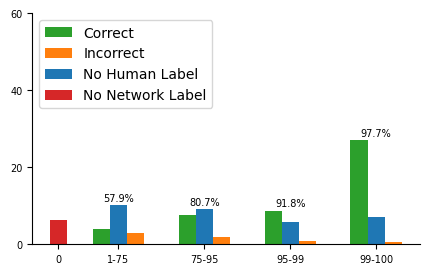

<Figure size 640x480 with 0 Axes>

In [309]:
%matplotlib inline
conf_range_cutoffs = [1, 75, 95, 99, 100]

font = {'fontname': 'DejaVu Sans', 'size': 7}

for network in networks:#["paper_all", "paper_all_red", "paper_BFP", "paper_OFP", "paper_mNeptune", "paper_noisy_all_red", "paper_noisy_all_red_fm", "paper_SWF415_all_red"]:
    network_delta_correct = []
    network_delta_incorrect = []
    network_delta_nohumanlabel = []
    network_delta_humanlowconf = []


    n_animals = len(datasets_use)

    for i in range(len(conf_range_cutoffs) - 1):
        min_conf = conf_range_cutoffs[i]
        max_conf = conf_range_cutoffs[i+1]
        if len([x for x in network_data_dict[0][network]["network_conf_correct"] if 100 * x[3] == 100]):
            print("100!")
        network_delta_correct.append(len([x for x in network_data_dict[0][network]["network_conf_correct"] if 100 * x[3] >= min_conf and 100 * x[3] < max_conf]) / n_animals)
        network_delta_incorrect.append(len([x for x in network_data_dict[0][network]["network_conf_incorrect"] if 100 * x[3] >= min_conf and 100 * x[3] < max_conf]) / n_animals)
        network_delta_nohumanlabel.append(len([x for x in network_data_dict[0][network]["network_conf_nohumanlabel"] if 100 * x[3] >= min_conf and 100 * x[3] < max_conf]) / n_animals)
        network_delta_humanlowconf.append(len([x for x in network_data_dict[0][network]["network_conf_humanlowconf"] if 100 * x[3] >= min_conf and 100 * x[3] < max_conf]) / n_animals)


    print(network_delta_correct)
    print(network_delta_incorrect)
    print(network_delta_nohumanlabel)
    print(network_delta_humanlowconf)
    tot_label = np.sum(network_delta_correct[1:]) + np.sum(network_delta_incorrect[1:]) + np.sum(network_delta_nohumanlabel[1:])  + np.sum(network_delta_humanlowconf[1:]) 
    tot_acc = np.sum(network_delta_correct[1:]) / (np.sum(network_delta_correct[1:]) + np.sum(network_delta_incorrect[1:]))
    network_delta_no_label_low_conf = [x + y for x, y in zip(network_delta_nohumanlabel, network_delta_humanlowconf)]

    # Generate x-axis labels based on the cutoffs
    x_labels = [f"{conf_range_cutoffs[i]}-{conf_range_cutoffs[i+1]}" for i in range(len(network_delta_correct))]
    x_labels = ["Human\nonly"] + x_labels
    
    # Adjusted plotting code
    fig, ax = plt.subplots(figsize=(5,3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    x = range(1, len(network_delta_correct) + 1)
    width = 0.2  # consistent width for all bars

    # Plot each category
    suffix = "*" if (network == "paper_SWF415_all_red") else ""
    human = "CePNEM" if (network == "paper_SWF415_all_red") else "Human"
    ax.bar(x, network_delta_correct, width, label='Correct'+suffix, color='C2')
    ax.bar([p + 2 * width for p in x], network_delta_incorrect, width, label='Incorrect'+suffix, color='C1')
    ax.bar([p + width for p in x], network_delta_no_label_low_conf, width, label='No '+human+' Label', color='C0')
    ax.bar([0.5], [np.mean(network_data_dict[0][network]["count_human_only"])], width, label="No Network Label", color='C3')  # Added width and adjusted position
    ax.legend(loc="upper left")

    print("Network: " + network + ", accuracy: " + str(np.array(network_delta_correct) / (np.array(network_delta_correct) + np.array(network_delta_incorrect))) + ", tot labeled: " + str(tot_label) + ", tot acc: " + str(tot_acc), ", avg lost: ", str(np.mean(network_data_dict[0][network]["count_human_only"])))
    print("Network: " + network, str(network_delta_correct))

    # Add text annotations
    for i in range(0, len(x)):
        try:
            acc = network_delta_correct[i] / (network_delta_correct[i] + network_delta_incorrect[i])
        except ZeroDivisionError:
            acc = 0
        
        ax.text(x[i] + width, max(network_delta_correct[i], network_delta_incorrect[i], network_delta_no_label_low_conf[i]) + 0.5, f'{100*acc:.1f}%', ha='center', va='bottom', fontdict=font)


    # Labeling and legending
    # ax.set_xlabel('Network Confidence (%)')
    # ax.set_ylabel('# labels per animal')
    ax.set_xticks([0.5] + [p + width for p in x])  # Adjusted to align "Human only" correctly
    ax.set_xticklabels(["0"] + [f"{conf_range_cutoffs[i]}-{conf_range_cutoffs[i+1]}" for i in range(len(network_delta_correct))], **font)
    # ax.legend(prop={'family': 'DejaVu Sans', 'size': 8})
    if network == "paper_SWF415_all_red":
        ax.set_ylim(0,10)
    else: # 
        ax.set_ylim(0, 60)
        plt.yticks([0,20,40,60], **font)
    # plt.title(network[6:] + " freely-moving only")
    plt.savefig("ACCURACYPLOT.png")
    plt.show()
plt.clf()
    # if network == "paper_all":
        # plt.savefig(f"/data3/brian/figures/figure_4/{network}_label_cat.pdf", bbox_inches='tight')

    # plt.savefig(f"/data3/prj_register/figures/figure_5/{network}_label_cat.pdf", bbox_inches='tight')

### Plot accuracy vs detections tradeoff curve

This code plots the curve for neurons that were registered to the freely-moving dataset, and requires `network_data_dict_fmonly` to be generated as described above. It does this so the network evaluated on freely-moving data is comparable to the other networks.

(0.9314338163496465, 68.57454545454546)


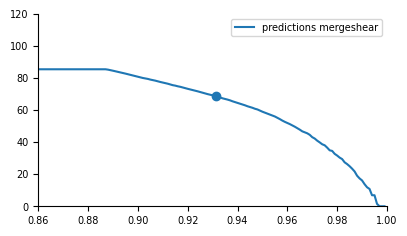

In [314]:
network_data_dict_fmonly = network_data_dict
if collapse:
    conf_range_cutoffs_detailed = np.append(np.arange(0, 99, 0.1), np.arange(99, 100, 0.001))
else:
    conf_range_cutoffs_detailed = np.append(np.arange(0, 99, 0.1), np.arange(99, 100, 0.01))
accuracy_level = np.arange(80, 100, 0.1)

acc_n = {}
conf_thresh = 75

fig = plt.figure(figsize=(4.5, 2.5))
ax = fig.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for network in networks: #["paper_all", "paper_OFP", "paper_BFP", "paper_mNeptune", "paper_all_red", "paper_noisy_all_red","paper_noisy_all_red_fm"]:
    network_cumulative_accuracy_level = []



    n_animals = len(datasets_use)

    acc_n[network] = np.zeros(len(accuracy_level))
    conf_thresh_point = 0.75

    for i in range(len(conf_range_cutoffs_detailed)):
        min_conf = conf_range_cutoffs_detailed[i]
        corr = len([x for x in network_data_dict_fmonly[0][network]["network_conf_correct"] if 100 * x[3] >= min_conf]) / n_animals
        incorr = len([x for x in network_data_dict_fmonly[0][network]["network_conf_incorrect"] if 100 * x[3] >= min_conf]) / n_animals
        nohl = len([x for x in network_data_dict_fmonly[0][network]["network_conf_nohumanlabel"] if 100 * x[3] >= min_conf and 100 * x[3] < max_conf]) / n_animals
        hlc = len([x for x in network_data_dict_fmonly[0][network]["network_conf_humanlowconf"] if 100 * x[3] >= min_conf and 100 * x[3] < max_conf]) / n_animals
        if corr + incorr == 0:
            acc = 0
        else:
            acc = corr / (corr + incorr)
        n = corr + incorr + nohl + hlc

        for (j, thresh) in enumerate(accuracy_level):
            if acc >= thresh / 100 and n > acc_n[network][j]:
                acc_n[network][j] = n
                if network == "paper_noisy_all_red" and j == 150:
                    print(str(conf_range_cutoffs_detailed[i]) + " " + str(thresh))
        if min_conf == conf_thresh:
            conf_thresh_point = (acc, n)

    plt.plot(accuracy_level / 100, acc_n[network], label=network.replace("paper_", "").replace("_", " ").replace("all red", "tagRFP-only").\
        replace("fm", "freely-moving").replace("mNeptune", "mNeptune + tagRFP").replace("OFP", "OFP + tagRFP").replace("BFP", "BFP + tagRFP").replace("all", "full").\
        replace("noisy tagRFP-only freely-moving", "tagRFP-only (on freely-moving)").replace("noisy tagRFP-only", "tagRFP-only (on low SNR)")
        )
    if conf_thresh_point:
        print(conf_thresh_point)
        plt.plot(conf_thresh_point[0], conf_thresh_point[1], 'o', color=plt.gca().lines[-1].get_color())

# Add a neutral color legend entry for the dots
# plt.plot([], [], 'o', color='grey', label='75% confidence threshold')

font = {'fontname': 'DejaVu Sans', 'size': 7}

ax.legend(prop={'family': 'DejaVu Sans', 'size': 7})
# plt.xlabel("Accuracy (%)")
# plt.ylabel("# labels per animal")
plt.xlim(0.86, 1.00)
plt.ylim(0, 120)
plt.yticks(**font)
plt.xticks(**font)
plt.savefig("TRADEOFFPLOT.png")
# plt.savefig("/data3/prj_register/figures/figure_5/label_acc.pdf", bbox_inches='tight')


## Plot Accuracy as a Function of Neuron Class

In [311]:
assert not collapse, "Can only plot timepoint-level performance by Neuron Class"
for network in networks:#["paper_all", "paper_all_red", "paper_BFP", "paper_OFP", "paper_mNeptune", "paper_noisy_all_red", "paper_noisy_all_red_fm", "paper_SWF415_all_red"]:
    datasets_use = sorted(timepoints_test)

    num_neurons = len(extracted_neuron_ids)
    n_animals = len(datasets_use)

    network_delta_correct = np.zeros((num_neurons, n_animals))
    network_delta_incorrect = np.zeros((num_neurons, n_animals))
    network_delta_nohumanlabel = np.zeros((num_neurons, n_animals))
    network_delta_humanlowconf = np.zeros((num_neurons, n_animals))


    invalid_list = []    
    for neuron in network_data_dict[0][network]["network_conf_correct"]:
        if neuron[2] in extracted_neuron_ids:
            network_delta_correct[extracted_neuron_ids.index(neuron[2]), datasets_use.index(neuron[0])] = neuron[3]
        else:
            invalid_list.append(neuron[2])

    for neuron in network_data_dict[0][network]["network_conf_incorrect"]:
        if neuron[2] in extracted_neuron_ids:
            network_delta_incorrect[extracted_neuron_ids.index(neuron[2]), datasets_use.index(neuron[0])] = neuron[3]
        else:
            invalid_list.append(neuron[2])
    print(list(set(invalid_list)))

        
print(timepoints_test[::100])

['URAD?', 'URX?', 'IL2V?', 'AWC?', 'RIM?', 'RMD?', 'URYV?', 'SMDD?', 'RMDD?', 'AIB?', 'URYD?', 'I2?', 'RMG?', 'AWB?', 'IL1V?', 'IL2?', 'SIBV?', 'AVJ?', 'AVK?', 'AUA?', 'ASJ?', 'AVE?', 'OLQD?', 'IL1D?', 'I1?', 'SMBV?', 'SIAV?', 'SAAD?', 'RIC?', 'AVD?', 'M3?', 'AIM?', 'RMDV?', 'CEPV?', 'ADA?', 'SMBD?', 'RIB?', 'AIZ?', 'SAAV?', 'ASG?', 'RIV?', 'IL2D?', 'CEPD?', 'ASE?', 'ADE?']
['2023-09-13-02_1409', '2023-10-09-01_617', '2023-01-06-01_1198', '2023-01-10-07_82', '2023-07-01-23_1194', '2023-01-06-01_994', '2023-10-09-01_798', '2023-08-21-01_1295', '2023-01-17-07_1265', '2023-06-23-08_435', '2023-01-06-01_716']


In [312]:
np.savetxt('correct_confs_testing.txt', network_delta_correct)
np.savetxt('incorrect_confs_testing.txt', network_delta_incorrect)

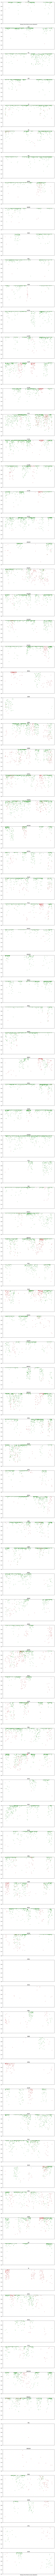

In [313]:
neuron_ids = extracted_neuron_ids[:100]
axes = plt.subplots(len(neuron_ids), 1, figsize=(10, 5 * len(neuron_ids)))[1]
for i, neuron in enumerate(neuron_ids):
    neur_corr = network_delta_correct[i]
    neur_corr[neur_corr == 0] = np.nan
    neur_incorr = network_delta_incorrect[i]
    neur_incorr[neur_incorr == 0] = np.nan
    axes[i].scatter(np.arange(network_delta_correct.shape[1]), neur_corr, c="tab:green", s=4)
    axes[i].scatter(np.arange(network_delta_correct.shape[1]), neur_incorr, c="tab:red", s=4)
    axes[i].set_ylim((0,1))
    axes[i].set_xticks([])
    axes[i].set_title(neuron)
axes[0].set_xlabel("Testing Time Points (across datasets)")
axes[i].set_xlabel("Testing Time Points (across datasets)")
plt.show()

In [ ]:
neuron_ids = extracted_neuron_ids[:100]
axes = plt.subplots(len(neuron_ids), 1, figsize=(10, 5 * len(neuron_ids)))[1]
for i, neuron in enumerate(neuron_ids):
    print([network_delta_correct[i][for an in n_animals])
    neur_corr = network_delta_correct[i]
    neur_corr[neur_corr == 0] = np.nan
    neur_incorr = network_delta_incorrect[i]
    neur_incorr[neur_incorr == 0] = np.nan
    axes[i].scatter(np.arange(network_delta_correct.shape[1]), neur_corr, c="tab:green", s=4)
    axes[i].scatter(np.arange(network_delta_correct.shape[1]), neur_incorr, c="tab:red", s=4)
    axes[i].set_ylim((0,1))
    axes[i].set_xticks([])
    axes[i].set_title(neuron)
axes[0].set_xlabel("Testing Time Points (across datasets)")
axes[i].set_xlabel("Testing Time Points (across datasets)")
plt.show()

In [194]:
network_delta_correct

array([[0.        , 0.99966729, 0.        , ..., 0.99970382, 0.99944925,
        0.        ],
       [0.        , 0.99663341, 0.        , ..., 0.99841988, 0.97643536,
        0.        ],
       [0.        , 0.99946517, 0.74523205, ..., 0.91357046, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [191]:
len(extracted_neuron_ids)

184

In [188]:
network_data_dict[0][network]["network_conf_correct"]

[('2023-09-13-02_1409', 154, 'AVER', 0.999957),
 ('2023-09-13-02_1409', 16, 'RMER', 0.9998502),
 ('2023-09-13-02_1409', 98, 'IL1VR', 0.99972004),
 ('2023-09-13-02_1409', 120, 'URXR', 0.9996538),
 ('2023-09-13-02_1409', 125, 'FLPR', 0.99942964),
 ('2023-09-13-02_1409', 132, 'IL1DR', 0.99937665),
 ('2023-09-13-02_1409', 114, 'CEPVR', 0.9992805),
 ('2023-09-13-02_1409', 173, 'CEPVL', 0.99921846),
 ('2023-09-13-02_1409', 53, 'RICR', 0.99868345),
 ('2023-09-13-02_1409', 47, 'AVDR', 0.9982395),
 ('2023-09-13-02_1409', 163, 'SMDVR', 0.9981481),
 ('2023-09-13-02_1409', 81, 'ADER', 0.9981389),
 ('2023-09-13-02_1409', 40, 'M4', 0.9971287),
 ('2023-09-13-02_1409', 139, 'OLQVR', 0.9968423),
 ('2023-09-13-02_1409', 115, 'M3L', 0.9965381),
 ('2023-09-13-02_1409', 127, 'URXL', 0.9960686),
 ('2023-09-13-02_1409', 37, 'RMED', 0.9950689),
 ('2023-09-13-02_1409', 106, 'AQR', 0.9922254),
 ('2023-09-13-02_1409', 29, 'AIBR', 0.99123305),
 ('2023-09-13-02_1409', 146, 'AIZR', 0.9885279),
 ('2023-09-13-02_1409

### Plot accuracy vs detections tradeoff curve

This code plots the curve for all neurons.

KeyError: 'paper_all'

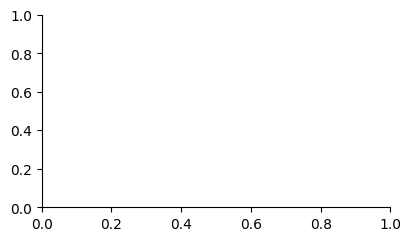

In [164]:
conf_range_cutoffs_detailed = np.arange(0, 100, 0.1)
accuracy_level = np.arange(80, 100, 0.1)

acc_n = {}
conf_thresh = 75

fig = plt.figure(figsize=(4.5, 2.5))
ax = fig.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# for network in ["paper_all", "paper_nocustomaug", "paper_noweight"]:
for network in ["paper_all"]:
    network_cumulative_accuracy_level = []

    if network == "paper_noisy_all_red":
        datasets_use = datasets_test_noisy
    else:
        datasets_use = timepoints_test

    n_animals = len(datasets_use)

    acc_n[network] = np.zeros(len(accuracy_level))
    conf_thresh_point = None

    for i in range(len(conf_range_cutoffs_detailed)):
        min_conf = conf_range_cutoffs_detailed[i]
        corr = len([x for x in network_data_dict[0][network]["network_conf_correct"] if 100 * x[3] >= min_conf]) / n_animals
        incorr = len([x for x in network_data_dict[0][network]["network_conf_incorrect"] if 100 * x[3] >= min_conf]) / n_animals
        nohl = len([x for x in network_data_dict[0][network]["network_conf_nohumanlabel"] if 100 * x[3] >= min_conf and 100 * x[3] < max_conf]) / n_animals
        hlc = len([x for x in network_data_dict[0][network]["network_conf_humanlowconf"] if 100 * x[3] >= min_conf and 100 * x[3] < max_conf]) / n_animals
        if corr + incorr == 0:
            acc = 0
        else:
            acc = corr / (corr + incorr)
        n = corr + incorr + nohl + hlc

        for (j, thresh) in enumerate(accuracy_level):
            if acc >= thresh / 100 and n > acc_n[network][j]:
                acc_n[network][j] = n
                if network == "paper_noisy_all_red" and j == 150:
                    print(str(conf_range_cutoffs_detailed[i]) + " " + str(thresh))
        if min_conf == conf_thresh:
            conf_thresh_point = (acc, n)

    plt.plot(accuracy_level / 100, acc_n[network])
    if conf_thresh_point:
        print(conf_thresh_point)
        plt.plot(conf_thresh_point[0], conf_thresh_point[1], 'o', color=plt.gca().lines[-1].get_color())

# Add a neutral color legend entry for the dots
plt.plot([], [], 'o', color=plt.gca().lines[-1].get_color(), label='75% confidence threshold')

font = {'fontname': 'DejaVu Sans', 'size': 7}

ax.legend(prop={'family': 'DejaVu Sans', 'size': 7})
# plt.xlabel("Accuracy (%)")
# plt.ylabel("# labels per animal")
plt.xlim(0.86, 1.00)
plt.ylim(0, 150)
plt.yticks(**font)
plt.xticks(**font)
# plt.savefig("/data3/prj_register/figures/figure_S4/label_acc_vs_recall.pdf", bbox_inches='tight')


### Plot network-human agreement as a fraction of human label confidence

In [ ]:
for network in networks:
    plt.figure(figsize=(1.5,1.5))
    ax = plt.gca()  # gca stands for 'get current axis'
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    vp = plt.violinplot([network_data_dicts[(1,2)][3][network]["frac_correct"], 
                        network_data_dicts[(3,3)][3][network]["frac_correct"], 
                        network_data_dicts[(4,4)][3][network]["frac_correct"], 
                        network_data_dicts[(5,5)][3][network]["frac_correct"]])

    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp[partname].set_edgecolor('none')

    # Calculate the area of each violin
    violin_areas = [np.trapz(np.abs(body.get_paths()[0].vertices[:, 1]), body.get_paths()[0].vertices[:, 0]) for body in vp['bodies']]
    max_area = max(violin_areas)

    # Normalize each violin to have the same area
    for i, body in enumerate(vp['bodies']):
        verts = body.get_paths()[0].vertices
        if violin_areas[i] != 0:
            scale_factor = 0.5 * (max_area / violin_areas[i])**0.5
        else:
            scale_factor = 1
        verts[:, 0] *= scale_factor
        # Recenter the violin
        verts[:, 0] -= np.mean(verts[:, 0])
        verts[:, 0] += i + 1  # Reposition based on their original location
        body.set_edgecolor('black')
        body.set_linewidth(1)
        body.set_alpha(1)
        body.set_facecolor('C2')  # Set the color to grey

    font = {'fontname': 'DejaVu Sans', 'size': 7}

    print(network)
    ## Statistics
    # 1-2 vs 3
    p_value = paired_permutation_test(network_data_dicts[(1,2)][3][network]["frac_correct"], network_data_dicts[(3,3)][3][network]["frac_correct"])
    print(f'1-2 vs 3: p={p_value}')

    # 3 vs 4
    p_value = paired_permutation_test(network_data_dicts[(3,3)][3][network]["frac_correct"], network_data_dicts[(4,4)][3][network]["frac_correct"])
    print(f'3 vs 4: p={p_value}')

    # 4 vs 5
    p_value = paired_permutation_test(network_data_dicts[(4,4)][3][network]["frac_correct"], network_data_dicts[(5,5)][3][network]["frac_correct"])
    print(f'4 vs 5: p={p_value}')


    plt.xticks([1, 2, 3, 4], ["1-2", "3", "4", "5"], **font)
    plt.xlim(0.75,4.5)
    # plt.xlabel("Human confidence")
    plt.ylim(0, 1)
    plt.yticks([0, 0.25, 0.5, 0.75, 1], **font)
    plt.show()
    # plt.xlim()
    # plt.ylabel("Autolabel-human\nagreement")
    plt.savefig("acc_vs_humanconf.png", bbox_inches='tight')
    print("\n")

initialRun
1-2 vs 3: p=0.01002
3 vs 4: p=0.30672
4 vs 5: p=0.24118




### Plot Neuron Accuracy as a Function of timeframes


In [ ]:
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

for network in networks:
    dataset = '2023-01-06-01'
    

    output_grid = np.zeros((num_timepoints, len(extracted_neuron_ids)))

    index_cor = [x[1] for x in network_data_dict[0][network]["network_conf_correct"]]
    index_incor = [x[1] for x in network_data_dict[0][network]["network_conf_correct"]]

    for x in network_data_dict[0][network]["network_conf_correct"]:
        if x[0].split("_")[0] != dataset:
            continue
        t = int(x[0].split("_")[1]) - 1
        try:
            output_grid[t][extracted_neuron_ids.index(x[2])] = x[3]
        except ValueError:
            # try:
            #     output_grid[t][extracted_neuron_ids.index(x[2][:-1])] = x[3]
            # except ValueError:
            print(f"Neuron {x[2]} was not found in the neuron classes list")
            continue
    
    for x in network_data_dict[0][network]["network_conf_incorrect"]:
        if x[0].split("_")[0] != dataset:
            continue
        t = int(x[0].split("_")[1]) - 1
        try:
            # index = extracted_neuron_ids.index(x[2])
            index = extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])
            if output_grid[t][index] != 0:
                print(f"Timepoint {t} is overwriting {dict_roi_to_neuron_everything[dataset][0][x[1]][0]}'s value of {output_grid[t][index]}")
            output_grid[t][index] = -x[3]
        except ValueError:
            # try:
            #     output_grid[t][extracted_neuron_ids.index(x[2][:-1])] = -x[3]
            # except ValueError:
            # print(f"Neuron {x[2]} was not found in the neuron classes list")
            continue
        
    
    # plt.imshow(output_grid)
    # # plt.imsave("framewiseGraph.png", output_grid.T, cmap = "RdYlGn")
    # plt.imsave("framewiseGraph.png", output_grid.T, cmap = cmap)
    _, ax = plt.subplots(1, 1, figsize=(256, 32))
    ax.imshow(output_grid.T, cmap = cmap)
    ax.set_yticks(range(len(extracted_neuron_ids)))
    ax.set_yticklabels(extracted_neuron_ids)
    plt.savefig("framewiseGraph.png")
    
plt.close()


Neuron IL1? was not found in the neuron classes list
Neuron AVD? was not found in the neuron classes list
Neuron IL1? was not found in the neuron classes list
Neuron I1? was not found in the neuron classes list
Neuron OLL? was not found in the neuron classes list
Neuron I1? was not found in the neuron classes list
Neuron OLL? was not found in the neuron classes list
Neuron IL1? was not found in the neuron classes list
Neuron M3? was not found in the neuron classes list
Neuron CEPV? was not found in the neuron classes list
Neuron I1? was not found in the neuron classes list
Neuron URAD? was not found in the neuron classes list
Neuron IL1D? was not found in the neuron classes list
Neuron RMD? was not found in the neuron classes list
Neuron AWA? was not found in the neuron classes list
Neuron RMD? was not found in the neuron classes list
Neuron OLQD? was not found in the neuron classes list
Neuron M3? was not found in the neuron classes list
Neuron OLL? was not found in the neuron classes

In [ ]:
interested_neuron = "ASKR"
alt_dict = {}
for x in network_data_dict[0][network]["network_conf_incorrect"]:
    if x[0].split("_")[0] != dataset or dict_roi_to_neuron_everything[dataset][0][x[1]][0] != interested_neuron:
        continue
    alt_dict[x[2]] = alt_dict.get(x[2], 0) + 1
print(alt_dict)
    

{'ADLR': 291, 'ALA': 328, 'SIBVR': 36, 'ADL?': 8, 'URXR': 8, 'CEPD?': 1, 'CEPDR': 2}


In [ ]:
plt.close()
for network in networks:
    dataset = '2023-01-06-01'
    num_timepoints = 1600


    output_grid = np.ones((num_timepoints, len(extracted_neuron_ids), 4))

    # output_grid[0][0][0] = 0.5 # Red
    # output_grid[1][1][1] = 0.5 # Green
    # output_grid[2][2][2] = 0.5 # Blue

    # output_grid[0][0] = [1, 0, 0] # Red
    # output_grid[1][1] = [0, 1, 0] # Green
    # output_grid[2][2] = [0, 0, 1] # Blue

    index_cor = [x[1] for x in network_data_dict[0][network]["network_conf_correct"]]
    index_incor = [x[1] for x in network_data_dict[0][network]["network_conf_correct"]]

    for x in network_data_dict[0][network]["network_conf_correct"]:
        if x[0].split("_")[0] != dataset:
            continue
        t = int(x[0].split("_")[1]) - 1
        try:
            output_grid[t][extracted_neuron_ids.index(x[2])] = [0, 1, 0, x[3]]
        except ValueError:
            # try:
            #     output_grid[t][extracted_neuron_ids.index(x[2][:-1])] = x[3]
            # except ValueError:
            # print(f"Neuron {x[2]} was not found in the neuron classes list")
            continue
    
    for x in network_data_dict[0][network]["network_conf_incorrect"]:
        if x[0].split("_")[0] != dataset:
            continue
        t = int(x[0].split("_")[1]) - 1
        # TODO get ROI's correct label  
        try:
            # if output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])] != 0:
            #     print(f"Timepoint {t} is overwriting {dict_roi_to_neuron_everything[dataset][0][x[1]][0]}'s value of {output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])]}")
            output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])] = [1, 0, 0, x[3]]
        except ValueError:
            # try:
            #     output_grid[t][extracted_neuron_ids.index(x[2][:-1])] = -x[3]
            # except ValueError:
            # print(f"Neuron {x[2]} was not found in the neuron classes list")
            continue

    for x in network_data_dict[0][network]["network_conf_nohumanlabel"]:
        if x[0].split("_")[0] != dataset:
            continue
        t = int(x[0].split("_")[1]) - 1
        # TODO get ROI's correct label  
        try:
            # if output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])] != 0:
            #     print(f"Timepoint {t} is overwriting {dict_roi_to_neuron_everything[dataset][0][x[1]][0]}'s value of {output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])]}")
            output_grid[t][extracted_neuron_ids.index(x[2])] = [0, 0, 1, x[3]]
        except ValueError:
            # try:
            #     output_grid[t][extracted_neuron_ids.index(x[2][:-1])] = -x[3]
            # except ValueError:
            # print(f"Neuron {x[2]} was not found in the neuron classes list")
            continue
        
    
    # plt.imshow(output_grid)
    # # plt.imsave("framewiseGraph.png", output_grid.T, cmap = "RdYlGn")
    # plt.imsave("framewiseGraph.png", output_grid.T, cmap = cmap)
    _, ax = plt.subplots(1, 1, figsize=(256, 32))
    
    ax.imshow(np.swapaxes(output_grid, 0, 1))
    ax.set_yticks(range(len(extracted_neuron_ids)))
    ax.set_yticklabels(extracted_neuron_ids)
    plt.savefig("framewiseGraph.png")
    



This next one tries to show overlaps 

In [ ]:
plt.close()
for network in networks:
    dataset = '2023-01-06-01'
    num_timepoints = 1600


    output_grid = np.zeros((num_timepoints, len(extracted_neuron_ids), 4))

    # output_grid[0][0][0] = 0.5 # Red
    # output_grid[1][1][1] = 0.5 # Green
    # output_grid[2][2][2] = 0.5 # Blue

    # output_grid[0][0] = [1, 0, 0] # Red
    # output_grid[1][1] = [0, 1, 0] # Green
    # output_grid[2][2] = [0, 0, 1] # Blue

    index_cor = [x[1] for x in network_data_dict[0][network]["network_conf_correct"]]
    index_incor = [x[1] for x in network_data_dict[0][network]["network_conf_correct"]]

    for x in network_data_dict[0][network]["network_conf_correct"]:
        if x[0].split("_")[0] != dataset:
            continue
        t = int(x[0].split("_")[1]) - 1
        try:
            # if output_grid[t][extracted_neuron_ids.index(x[2])][3] == 1:
            #     output_grid[t][extracted_neuron_ids.index(x[2])] = [0, 1, 0, x[3]]
            # else:
            output_grid[t][extracted_neuron_ids.index(x[2])][1] = 1
            output_grid[t][extracted_neuron_ids.index(x[2])][3] = max(x[3],output_grid[t][extracted_neuron_ids.index(x[2])][3])
        except ValueError:
            # try:
            #     output_grid[t][extracted_neuron_ids.index(x[2][:-1])] = x[3]
            # except ValueError:
            # print(f"Neuron {x[2]} was not found in the neuron classes list")
            continue
    
    for x in network_data_dict[0][network]["network_conf_incorrect"]:
        if x[0].split("_")[0] != dataset:
            continue
        t = int(x[0].split("_")[1]) - 1
        # TODO get ROI's correct label  
        try:
            # if output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])] != 0:
            #     print(f"Timepoint {t} is overwriting {dict_roi_to_neuron_everything[dataset][0][x[1]][0]}'s value of {output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])]}")
            output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])][0] = 1
            output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])][3] = max(x[3], output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])][3])
        except ValueError:
            # try:
            #     output_grid[t][extracted_neuron_ids.index(x[2][:-1])] = -x[3]
            # except ValueError:
            # print(f"Neuron {x[2]} was not found in the neuron classes list")
            continue

    for x in network_data_dict[0][network]["network_conf_nohumanlabel"]:
        if x[0].split("_")[0] != dataset:
            continue
        t = int(x[0].split("_")[1]) - 1
        # TODO get ROI's correct label  
        try:
            # if output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])] != 0:
            #     print(f"Timepoint {t} is overwriting {dict_roi_to_neuron_everything[dataset][0][x[1]][0]}'s value of {output_grid[t][extracted_neuron_ids.index(dict_roi_to_neuron_everything[dataset][0][x[1]][0])]}")
            output_grid[t][extracted_neuron_ids.index(x[2])][2] = 1
            output_grid[t][extracted_neuron_ids.index(x[2])][3] = max(x[3], output_grid[t][extracted_neuron_ids.index(x[2])][3])
        except ValueError:
            # try:
            #     output_grid[t][extracted_neuron_ids.index(x[2][:-1])] = -x[3]
            # except ValueError:
            # print(f"Neuron {x[2]} was not found in the neuron classes list")
            continue
        
    
    # plt.imshow(output_grid)
    # # plt.imsave("framewiseGraph.png", output_grid.T, cmap = "RdYlGn")
    # plt.imsave("framewiseGraph.png", output_grid.T, cmap = cmap)
    _, ax = plt.subplots(1, 1, figsize=(256, 32))
    
    ax.imshow(np.swapaxes(output_grid, 0, 1))
    ax.set_yticks(range(len(extracted_neuron_ids)))
    ax.set_yticklabels(extracted_neuron_ids)
    plt.savefig("framewiseGraph.png")
    



### Plot accuracy as a function of # combined frames

In [ ]:


num_collapse_samples = 10
collapse_sizes = [1, 3, 5, 10, 25, 50, 100, 1000, num_timepoints]

collapse_accuracies = {}
collapse_count = {}

for size in tqdm(collapse_sizes):
    if size in collapse_accuracies:
        continue
    n = min(num_collapse_samples, int(num_timepoints/size))

    timepoints = list(output_dicts[network].keys())
    random.shuffle(timepoints)

    collapsed_size_cor = []
    collapsed_size_incor = []
    collapsed_size_count = []
    for i in range(n):
        collapsed_output_dict = {}
        collapsed_prob_dict = {}
        for timepoint in timepoints[i * size : (i + 1) * size]:
            dataset, t = timepoint.split("_")
            
            for neuron in output_dicts[network][timepoint]:
                if neuron["neuron_class"] == "UNKNOWN":
                    continue
                if neuron["roi_id"] not in collapsed_output_dict:
                    collapsed_output_dict[neuron["roi_id"]] = [neuron]
                    collapsed_prob_dict[neuron["roi_id"]] = [prob_dicts[network][timepoint][neuron["roi_id"]]]
                else:
                    collapsed_output_dict[neuron["roi_id"]].append(neuron)
                    collapsed_prob_dict[neuron["roi_id"]].append(prob_dicts[network][timepoint][neuron["roi_id"]])

        
            blank_output_list = []
            blank_prob_list = {}
            correct = 0
            incorrect = 0
            total_labeled = 0
            for roi, roi_list in collapsed_output_dict.items():
                possibilities = {}
                for i in range(len(roi_list)):
                    match = roi_list[i]["neuron_class"]
                    if match not in possibilities:
                        possibilities[match] = ([roi_list[i]["max_prob"]], [i])
                    else:
                        possibilities[match] = (possibilities[match][0] + [roi_list[i]["max_prob"]],  possibilities[match][1] + [i])
                max_score = 0
                curr = None
                conf = None
                for option in possibilities.values():
                    score = sum(option[0])/(math.sqrt(len(option[0]))/len(option[0]))
                    if score > max_score:
                        max_score = score
                        curr = option[1][option[0].index(max(option[0]))] # Set the end result to be the most confident of the options among the biased best neuron. We do this instead of just picking a random one so that the confidences will make sense
                        # conf = np.median(option[0])
                        conf = np.max(option[0])
                # blank_output_list.append(roi_list[curr])
                # blank_output_list[-1]["max_prob"] = conf
                # blank_output_list[-1]["confidence"] = max([x for x,y in [(0, 0), (1, 0.1), (2, .5), (3, .75), (4, .95), (5, .99)] if conf > y])
                # blank_prob_list[roi] = collapsed_prob_dicts[roi][curr]
                if conf < 0.75:
                    continue
                total_labeled += 1
                if roi not in dict_roi_to_neuron_everything[dataset][1] or (
                        "-alt" in dict_roi_to_neuron_everything[dataset][0][roi][0] or (
                            "?" in dict_roi_to_neuron_everything[dataset][0][roi][0] and dict_roi_to_neuron_everything[dataset][0][roi][0][-1] != "?")):
                    continue
                        
                possible_matches = [roi_list[curr]["neuron_class"]]
                if neuron_class[-1] in ["L", "R", "?"] and neuron_class not in neuron_ids_nolr:
                    possible_matches.append(neuron_class[:-1] + "L")
                    possible_matches.append(neuron_class[:-1] + "R")
                    possible_matches.append(neuron_class[:-1] + "?")
                labeled_class = dict_roi_to_neuron_everything[dataset][0][roi][0]
                if labeled_class in possible_matches:
                    correct += 1
                else:
                    incorrect += 1
        collapsed_size_cor.append(correct)
        collapsed_size_incor.append(incorrect)
        collapsed_size_count.append(total_labeled)

    collapse_accuracies[size] = np.mean([x / (x + y) for x,y in zip(collapsed_size_cor, collapsed_size_incor)])
    collapse_count[size] = np.mean(collapsed_size_count)

print(collapse_accuracies)
print(collapse_count)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [06:35<00:00, 44.00s/it] 

{1: 0.8357225168425819, 3: 0.8402793209772739, 5: 0.8033300122286015, 10: 0.8308631804285149, 25: 0.81329698944116, 50: 0.8128674221748188, 100: 0.8012200394327385, 1000: 0.7802197802197802, 1600: 0.7802197802197802}
{1: 68.2, 3: 89.1, 5: 92.5, 10: 101.8, 25: 109.2, 50: 112.3, 100: 116.1, 1000: 122.0, 1600: 122.0}


In [ ]:
from matplotlib.collections import LineCollection
plt.clf()
x = collapse_sizes
y = [collapse_accuracies[i] for i in collapse_sizes]
lwidths=[collapse_count[i] for i in collapse_sizes]
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)
# lc = LineCollection(segments, linewidths=lwidths,color='blue')
# fig,a = plt.subplots()
# a.add_collection(lc)
# fig.show()
plt.figure(figsize=(10,6))
plt.xscale('log')
plt.scatter(x,y,s = lwidths)
plt.plot(x,y)
plt.title("Accuracy and Detection by Frames Collapsed (> 0.75)")
plt.ylabel("Accuracy")
plt.xlabel("Number of Frames Collapsed")
plt.savefig("collapse_sig.png")
plt.close()

## Manuscript numbers

In this section, replace `paper_all` with the name of the network you'd like to get the statistics for.

In [ ]:
print(networks)

['initialRun']


In [ ]:
selected_network = "initialRun"
# test_groups = ["."]
# test_groups = datasets_test
test_groups = test_groups_filtered

In [ ]:
len(test_groups_filtered)/len(timepoints_test)

0.8495897903372835

### Average number of AutoCellLabeler-labeled neurons per dataset:

In [ ]:
(len(network_data_dict[3][selected_network]["network_conf_correct"]) + len(network_data_dict[3][selected_network]["network_conf_incorrect"]) + len(network_data_dict[3][selected_network]["network_conf_humanlowconf"]) + len(network_data_dict[3][selected_network]["network_conf_nohumanlabel"])) / len(test_groups)

62.84549356223176

In [ ]:
(len(network_data_dict[2][selected_network]["network_conf_correct"]) + len(network_data_dict[2][selected_network]["network_conf_incorrect"]) + len(network_data_dict[2][selected_network]["network_conf_humanlowconf"]) + len(network_data_dict[2][selected_network]["network_conf_nohumanlabel"])) / len(test_groups)

85.46244635193133

In [ ]:
(len(network_data_dict[1][selected_network]["network_conf_correct"]) + len(network_data_dict[1][selected_network]["network_conf_incorrect"]) + len(network_data_dict[1][selected_network]["network_conf_humanlowconf"]) + len(network_data_dict[1][selected_network]["network_conf_nohumanlabel"])) / len(test_groups)

99.74463519313305

In [ ]:
(len(network_data_dict[0][selected_network]["network_conf_correct"]) + len(network_data_dict[0][selected_network]["network_conf_incorrect"]) + len(network_data_dict[0][selected_network]["network_conf_humanlowconf"]) + len(network_data_dict[0][selected_network]["network_conf_nohumanlabel"])) / len(test_groups)

99.74678111587983

### Average number of human labeled neurons per dataset:

In [ ]:
(np.sum(network_data_dict[0][selected_network]["count_human_labeled"])) / len(test_groups)

69.71137339055794

In [ ]:
neuro_total = 0
rim_total = 0
ht_total = 0
starv_total = 0
for dataset in datasets:
    total = len([roi for roi in dict_roi_to_neuron_everything[dataset][1] if dict_roi_to_neuron_everything[dataset][1][roi] >= 4])
    if dataset in datasets_prj_neuropal:
    #    print("Neuro - " + dataset + ": " + str(total))
       neuro_total += total
    elif dataset in datasets_prj_rim:
    #    print("rim - " + dataset + ": " + str(total))
       rim_total += total
    elif dataset in datasets_prj_5ht:
    #    print("5ht - " + dataset + ": " + str(total))
       ht_total += total
    elif dataset in datasets_prj_starvation:
    #    print("starv - " + dataset + ": " + str(total))
       starv_total += total

print("neuro_total:" + str(neuro_total))
print("rim_total:" + str(rim_total))
print("ht_total:" + str(ht_total))
print("starv_total:" + str(starv_total))
    

neuro_total:2428
rim_total:3984
ht_total:672
starv_total:1522


### Mean AutoCellLabeler confidence:

In [ ]:
overall_network_conf = [x[3] for x in network_data_dict[0][selected_network]["network_conf_correct"]]
overall_network_conf.extend([x[3] for x in network_data_dict[0][selected_network]["network_conf_incorrect"]])

In [ ]:
np.mean(overall_network_conf)

0.860638787579102

### Mean AutoCellLabeler confidence on low-human-confidence neurons:

In [ ]:
overall_network_conf = [x[3] for x in network_data_dicts[(1,3)][0][selected_network]["network_conf_correct"]]
overall_network_conf.extend([x[3] for x in network_data_dicts[(1,3)][0][selected_network]["network_conf_incorrect"]])

In [ ]:
np.mean(overall_network_conf)

0.740504581312533

### Mean AutoCellLabeler confidence on neurons with no human label:

In [ ]:
overall_network_conf = [x[3] for x in network_data_dicts[(4,5)][0][selected_network]["network_conf_nohumanlabel"]]

In [ ]:
np.mean(overall_network_conf)

0.7111429701589811

### Mean AutoCellLabeler confidence on its correct labels:

In [ ]:
np.mean([x[3] for x in network_data_dict[0][selected_network]["network_conf_correct"]])

0.8818797959438466

### Mean AutoCellLabeler confidence on its incorrect labels:

In [ ]:
np.mean([x[3] for x in network_data_dict[0][selected_network]["network_conf_incorrect"]])


0.6816832921061282

### Fraction of high-confidence human labels where the network assigned any label:

In [ ]:
(len(network_data_dict[0][selected_network]["network_conf_correct"]) + len(network_data_dict[0][selected_network]["network_conf_incorrect"])) / np.sum(network_data_dict[0][selected_network]["count_human_labeled"])

0.9544303797468354

### Fraction of high-confidence human labels where the network assigned a label with confidence 75% or greater:

In [ ]:
(len(network_data_dict[3][selected_network]["network_conf_correct"]) + len(network_data_dict[3][selected_network]["network_conf_incorrect"])) / np.sum(network_data_dict[3][selected_network]["count_human_labeled"])

0.9367088607594937

### AutoCellLabeler overall accuracy:

In [ ]:
len(network_data_dict[0][selected_network]["network_conf_correct"]) / (len(network_data_dict[0][selected_network]["network_conf_correct"]) + len(network_data_dict[0][selected_network]["network_conf_incorrect"]))


0.8938992042440318

### AutoCellLabeler accuracy on its 75% or greater confidence predictions:

In [ ]:
len(network_data_dict[3][selected_network]["network_conf_correct"]) / (len(network_data_dict[3][selected_network]["network_conf_correct"]) + len(network_data_dict[3][selected_network]["network_conf_incorrect"]))


0.9067567567567567

### AutoCellLabeler accuracy on all its predictions vs human low confidence neurons:

(note that this is likely a substantial underestimate because the low-confidence human labels are likely to be incorrect)

In [ ]:
len(network_data_dicts[(1,3)][0][selected_network]["network_conf_correct"]) / (len(network_data_dicts[(1,3)][0][selected_network]["network_conf_correct"]) + len(network_data_dicts[(1,3)][0][selected_network]["network_conf_incorrect"])) # network all accuracy on HUMAN 1-3 CONFIDENCE neurons


0.6451612903225806

### AutoCellLabeler accuracy on its 75% or greater confidence predictions vs human low confidence neurons:

(note that this is likely a substantial underestimate because the low-confidence human labels are likely to be incorrect)

In [ ]:
len(network_data_dicts[(1,3)][3][selected_network]["network_conf_correct"]) / (len(network_data_dicts[(1,3)][3][selected_network]["network_conf_correct"]) + len(network_data_dicts[(1,3)][3][selected_network]["network_conf_incorrect"]))

0.8410852713178295

### Fraction of all AutoCellLabeler network labels that have 75% or greater confidence

In [ ]:
(len(network_data_dict[3][selected_network]["network_conf_correct"]) + len(network_data_dict[3][selected_network]["network_conf_incorrect"]) + len(network_data_dict[3][selected_network]["network_conf_nohumanlabel"]) + len(network_data_dict[3]["paper_all"]["network_conf_humanlowconf"])) / (len(network_data_dict[0]["paper_all"]["network_conf_correct"]) + len(network_data_dict[0]["paper_all"]["network_conf_incorrect"]) + len(network_data_dict[0]["paper_all"]["network_conf_nohumanlabel"]) + len(network_data_dict[0]["paper_all"]["network_conf_humanlowconf"])) # fraction of network labels that are high confidence

0.8793800539083558

## Number of labels plots

### Plot number of labeled neurons per animal

Compare humans and AutoCellLabeler network versions

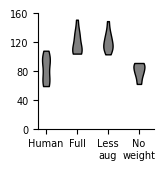

In [ ]:
plt.figure(figsize=(1.5,1.5))
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

vp = plt.violinplot([network_data_dict[3]["paper_all"]["count_human_labeled"], 
                     network_data_dict[3]["paper_all"]["count_labeled"], 
                     network_data_dict[3]["paper_nocustomaug"]["count_labeled"], 
                     network_data_dict[3]["paper_noweight"]["count_labeled"]])

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp[partname].set_edgecolor('none')

# Calculate the area of each violin
violin_areas = [np.trapz(np.abs(body.get_paths()[0].vertices[:, 1]), body.get_paths()[0].vertices[:, 0]) for body in vp['bodies']]
max_area = max(violin_areas)

# Normalize each violin to have the same area
for i, body in enumerate(vp['bodies']):
    verts = body.get_paths()[0].vertices
    scale_factor = 0.5 * (max_area / violin_areas[i])**0.5
    verts[:, 0] *= scale_factor
    # Recenter the violin
    verts[:, 0] -= np.mean(verts[:, 0])
    verts[:, 0] += i + 1  # Reposition based on their original location
    body.set_edgecolor('black')
    body.set_linewidth(1)
    body.set_alpha(1)
    body.set_facecolor('grey')  # Set the color to grey

font = {'fontname': 'DejaVu Sans', 'size': 7}

## Statistics

# Human vs full
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_human_labeled"], network_data_dict[3]["paper_all"]["count_labeled"])
print(f'Human vs full: p={p_value}')

# Full vs lessaug
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_labeled"], network_data_dict[3]["paper_nocustomaug"]["count_labeled"])
print(f'Full vs lessaug: p={p_value}')

# Full vs noweight
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_labeled"], network_data_dict[3]["paper_noweight"]["count_labeled"])
print(f'Full vs noweight: p={p_value}')

plt.xticks([1, 2, 3, 4], ["Human", "Full", "Less\naug", "No\nweight"], **font)
plt.xlim(0.75,4.5)
# plt.xlabel("Human confidence")
plt.ylim(0, 160)
plt.yticks([0,40,80,120,160],**font)
# plt.xlim()
# plt.ylabel("Autolabel-human\nagreement")

# plt.savefig("/data3/prj_register/figures/figure_4/autolabel_n_rois.pdf", bbox_inches='tight')

Compare humans, AutoCellLabeler, and CellDiscoveryNet

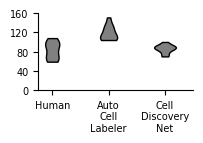

In [ ]:
# this notebook does not count new neuron detections by CellDiscoveryNet
# thus, we copy/paste the values from ANTSUN which include those detections
# we use the values from the 11 testing datasets for comparison with human/AutoCellLabeler
n_detections_deepreg = [72, 92, 88, 88, 90,100, 80, 90, 87, 87, 70]

plt.figure(figsize=(2.0,1.0))
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

vp = plt.violinplot([network_data_dict[3]["paper_all"]["count_human_labeled"], 
                     network_data_dict[3]["paper_all"]["count_labeled"], 
                     n_detections_deepreg])

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp[partname].set_edgecolor('none')

# Calculate the area of each violin
violin_areas = [np.trapz(np.abs(body.get_paths()[0].vertices[:, 1]), body.get_paths()[0].vertices[:, 0]) for body in vp['bodies']]
max_area = max(violin_areas)

# Normalize each violin to have the same area
for i, body in enumerate(vp['bodies']):
    verts = body.get_paths()[0].vertices
    scale_factor = 0.5 * (max_area / violin_areas[i])**0.5
    verts[:, 0] *= scale_factor
    # Recenter the violin
    verts[:, 0] -= np.mean(verts[:, 0])
    verts[:, 0] += i + 1  # Reposition based on their original location
    body.set_edgecolor('black')
    body.set_linewidth(1)
    body.set_alpha(1)
    body.set_facecolor('grey')  # Set the color to grey

font = {'fontname': 'DejaVu Sans', 'size': 7}

## Statistics

# Human vs full
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_human_labeled"], network_data_dict[3]["paper_all"]["count_labeled"])
print(f'Human vs full: p={p_value}')

# Full vs deepreg
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_labeled"], n_detections_deepreg)
print(f'Full vs deepreg: p={p_value}')


plt.xticks([1, 2, 3], ["Human", "Auto\nCell\nLabeler", "Cell\nDiscovery\nNet"], **font)
plt.xlim(0.75,3.5)
# plt.xlabel("Human confidence")
plt.ylim(0, 160)
plt.yticks([0,40,80,120,160],**font)
# plt.xlim()
# plt.ylabel("Autolabel-human\nagreement")

# plt.savefig("/data3/prj_register/figures/figure_6/deepreg_n_rois.pdf", bbox_inches='tight')

Compare color-limited versions of AutoCellLabeler

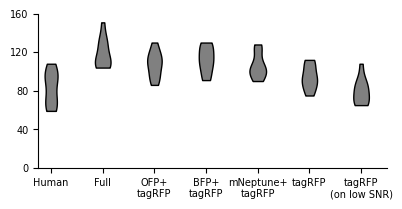

In [ ]:
plt.figure(figsize=(4.5,2))
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Define the specific shade of orange from Matplotlib's default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
specific_orange = default_colors[1]  # Second color in the cycle
specific_blue = default_colors[0]  # First color in the cycle

vp = plt.violinplot([network_data_dict[3]["paper_all"]["count_human_labeled"], 
                     network_data_dict[3]["paper_all"]["count_labeled"], 
                     network_data_dict[3]["paper_OFP"]["count_labeled"], 
                     network_data_dict[3]["paper_BFP"]["count_labeled"], 
                     network_data_dict[3]["paper_mNeptune"]["count_labeled"], 
                     network_data_dict[3]["paper_all_red"]["count_labeled"],  
                     network_data_dict[3]["paper_noisy_all_red"]["count_labeled"]])

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp[partname].set_edgecolor('none')

# Calculate the area of each violin
violin_areas = [np.trapz(np.abs(body.get_paths()[0].vertices[:, 1]), body.get_paths()[0].vertices[:, 0]) for body in vp['bodies']]
max_area = max(violin_areas)

# Normalize each violin to have the same area
for i, body in enumerate(vp['bodies']):
    verts = body.get_paths()[0].vertices
    scale_factor = 0.5 * (max_area / violin_areas[i])**0.5
    verts[:, 0] *= scale_factor
    # Recenter the violin
    verts[:, 0] -= np.mean(verts[:, 0])
    verts[:, 0] += i + 1  # Reposition based on their original location
    body.set_edgecolor('black')
    body.set_linewidth(1)
    body.set_alpha(1)
    body.set_facecolor('grey')  # Set the color to grey

font = {'fontname': 'DejaVu Sans', 'size': 7}

## Statistics

# Human vs full
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_human_labeled"], network_data_dict[3]["paper_all"]["count_labeled"])
print(f'Human vs full: p={p_value}')

# Full vs OFP
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_labeled"], network_data_dict[3]["paper_OFP"]["count_labeled"])
print(f'Full vs OFP: p={p_value}')

# Full vs BFP
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_labeled"], network_data_dict[3]["paper_BFP"]["count_labeled"])
print(f'Full vs BFP: p={p_value}')

# Full vs mNeptune
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_labeled"], network_data_dict[3]["paper_mNeptune"]["count_labeled"])
print(f'Full vs mNeptune: p={p_value}')

# Full vs tagRFP
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_labeled"], network_data_dict[3]["paper_all_red"]["count_labeled"])
print(f'Full vs tagRFP: p={p_value}')

# Full vs tagRFP (noisy)
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["count_labeled"], network_data_dict[3]["paper_noisy_all_red"]["count_labeled"])
print(f'Full vs tagRFP (noisy): p={p_value}')


plt.xlim(0.75,7.5)
# plt.xlabel("Human confidence")
plt.ylim(0, 160)
plt.yticks([0,40,80,120,160],**font)
# plt.xlim()
# plt.ylabel("Autolabel-human\nagreement")
plt.xticks([1, 2, 3, 4, 5, 6, 7], ["Human", "Full", "OFP+\ntagRFP", "BFP+\ntagRFP", "mNeptune+\ntagRFP", "tagRFP", "tagRFP\n(on low SNR)"], **font)
# plt.xlim()
# plt.ylabel("# Labeled ROIs")
# plt.savefig("/data3/prj_register/figures/figure_5/autolabel_fluorophore.pdf", bbox_inches='tight')

## Human relabeling

For a subset of neurons in each testing dataset, some humans were assigned to relabel them. This code block loads the relabeling data and computes the accuracy of the relabeling.

In [ ]:
# Convert the DataFrame into the required dictionary format
dict_roi_to_neuron_relabel = {}

for user in ["flossie", "talya", "candy", "saba"]:
    # Load the CSV file into a DataFrame
    file_path = "/data3/adam/new_unet_train/relabel_csv/" + user + " relabel.csv"
    data = pd.read_csv(file_path)
    for index, row in data.iterrows():
        dataset = row['dataset']
        roi = row['roi']
        label = row['label']
        confidence = row['confidence']

        # Initialize dictionary for the dataset if not already present
        if dataset not in dict_roi_to_neuron_relabel:
            dict_roi_to_neuron_relabel[dataset] = ({}, {})

        if label in ["GLIA", "GRANULE"]:
            label = label.lower()
        # Fill the dictionaries with ROI to label and ROI to confidence mappings
        dict_roi_to_neuron_relabel[dataset][0][roi] = label

        dict_roi_to_neuron_relabel[dataset][1][roi] = int(confidence)

# first_dataset = next(iter(dict_roi_to_neuron_relabel))
dict_roi_to_neuron_relabel

{'2023-01-17-07': ({1: 'AIZR',
   10: 'IL1VR',
   11: 'RIVR',
   34: 'AVLR',
   36: 'AUAL',
   49: 'UNKNOWN',
   57: 'IL2DR',
   66: 'AIYR',
   77: 'SMBVL',
   87: 'UNKNOWN',
   93: 'M5',
   95: 'IL1R',
   100: 'M3L',
   106: 'IL2L',
   108: 'UNKNOWN',
   111: 'CEPVL',
   120: 'SIA??',
   130: 'IL1VR',
   136: 'URADL',
   137: 'RIML',
   143: 'RMDDL',
   146: 'ADEL',
   151: 'UNKNOWN',
   154: 'ASIL',
   160: 'CEPVL',
   162: 'I6',
   167: 'BAGR',
   174: 'AVHL',
   208: 'AVLR',
   210: 'M1',
   221: 'AVKL',
   223: 'RMGR',
   232: 'AWBL',
   247: 'AIMR',
   252: 'AVER',
   255: 'UNKNOWN',
   262: 'AVLL',
   263: 'SAAD',
   268: 'UNKNOWN',
   274: 'URXR',
   277: 'VB2',
   279: 'I1R',
   290: 'AVLR',
   298: 'UNKNOWN',
   302: 'IL2DR',
   303: 'AIMR'},
  {1: 3,
   10: 5,
   11: 5,
   34: 2,
   36: 3,
   49: 0,
   57: 5,
   66: 3,
   77: 4,
   87: 0,
   93: 4,
   95: 4,
   100: 5,
   106: 4,
   108: 0,
   111: 5,
   120: 3,
   130: 5,
   136: 5,
   137: 4,
   143: 5,
   146: 3,
   151: 

In [ ]:
datasets_use = datasets_test# [d for d in datasets if d not in datasets_train]

human1_label_thresh = 4
human1_conf_thresh = human1_label_thresh
human2_conf_thresh = [0,1,2,3,4,5]
human_data_dict = {}

for conf in human2_conf_thresh:
    human_data_dict[conf] = {}
    human_data_dict[conf]["confidence_data"] = np.zeros((6,3))
    human_data_dict[conf]["neuron_class_dict"] = {neuron: np.zeros(6) for neuron in neuron_classes_all} # (N_new, N_correct, N_unknown, N_incorrect, N_lost, N_notfound)
    for neuron in neuron_classes_all:
        if neuron in neuron_ids_nolr:
            human_data_dict[conf]["neuron_class_dict"][neuron][5] = len(datasets_use)
        else:
            human_data_dict[conf]["neuron_class_dict"][neuron][5] = 2 * len(datasets_use)
    for key2 in ["conf_5_wrong", "count_labeled", "count_human1_labeled", "count_human1_only", "count_correct", "count_incorrect", "count_incorrect_excludegliagranule", "frac_correct", "human2_conf_correct", "human2_conf_incorrect", "human2_conf_incorrect_excludegliagranule", "human2_conf_humanlowconf", "human2_conf_nohumanlabel"]:
        human_data_dict[conf][key2] = []


for conf in human2_conf_thresh:
    datasets_use = dict_roi_to_neuron_relabel.keys()

    n_animals = len(datasets_use)
    
    for dataset in datasets_use:
        human_data_dict[conf]["count_labeled"].append(0)
        human_data_dict[conf]["count_correct"].append(0)
        human_data_dict[conf]["count_incorrect"].append(0)
        human_data_dict[conf]["count_incorrect_excludegliagranule"].append(0)
        human_data_dict[conf]["count_human1_labeled"].append(0)
        human_data_dict[conf]["count_human1_only"].append(0)
        for roi in dict_roi_to_neuron_relabel[dataset][0]:
            neuron_class = dict_roi_to_neuron_relabel[dataset][0][roi]
            human2_conf = dict_roi_to_neuron_relabel[dataset][1][roi]

            neuron_class_nolr = (neuron_class[:-1] if neuron_class not in neuron_ids_nolr else neuron_class)

            if "-alt" in neuron_class or neuron_class_nolr in ["glia", "granule"] or neuron_class == "UNKNOWN" or human2_conf < conf or neuron_class_nolr not in neuron_classes_all: # only glia, granule excluded for human labels
                if roi in dict_roi_to_neuron_everything[dataset][1] and dict_roi_to_neuron_everything[dataset][1][roi] >= human1_label_thresh:
                    neuron_class_human = dict_roi_to_neuron_everything[dataset][0][roi][0]
                    if neuron_class_human == "UNKNOWN" or "-alt" in neuron_class_human:
                        continue
                    neuron_class_human_nolr = (neuron_class_human[:-1] if neuron_class_human not in neuron_ids_nolr else neuron_class_human)
                    # humans are allowed to label excluded classes
                    if neuron_class_human_nolr in ["glia", "granule"]:
                        continue
                    if neuron_class_human_nolr not in neuron_classes_all:
                        continue
                    if "?" in neuron_class_human_nolr:
                        continue
                    human_data_dict[conf]["count_human1_labeled"][-1] += 1
                    human_data_dict[conf]["count_human1_only"][-1] += 1
                    # excluded classes aren't in this dictionary at all
                    if neuron_class_human_nolr in excluded_classes:
                        continue
                    human_data_dict[conf]["neuron_class_dict"][neuron_class_human_nolr][4] += 1
                    human_data_dict[conf]["neuron_class_dict"][neuron_class_human_nolr][5] -= 1
                continue

            human_data_dict[conf]["confidence_data"][data["confidence"], 0] += 1
            human_data_dict[conf]["count_labeled"][-1] += 1

            if roi not in dict_roi_to_neuron_everything[dataset][1] or dict_roi_to_neuron_everything[dataset][1][roi] < human1_label_thresh:
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][0] += 1
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                # No human label
                if roi not in dict_roi_to_neuron_everything[dataset][1]:
                    human_data_dict[conf]["human2_conf_nohumanlabel"].append((dataset, roi, neuron_class, human2_conf))
                    # Human label with low confidence
                elif dict_roi_to_neuron_everything[dataset][1][roi] < human1_label_thresh:
                    human_data_dict[conf]["human2_conf_humanlowconf"].append((dataset, roi, neuron_class, human2_conf))
                continue

            gt_neuron_class = dict_roi_to_neuron_everything[dataset][0][roi][0]
            if "-alt" in gt_neuron_class or ("?" in gt_neuron_class and gt_neuron_class[-1] != "?"):
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][0] += 1
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                # this will be counted as no human label
                human_data_dict[conf]["human2_conf_nohumanlabel"].append((dataset, roi, neuron_class, human2_conf))
                continue

            if dict_roi_to_neuron_everything[dataset][1][roi] < human1_conf_thresh:
                print("This code should not execute.")
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][2] += 1
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                human_data_dict[conf]["human2_conf_humanlowconf"].append((dataset, roi, neuron_class, human2_conf))
                continue

            possible_matches = [neuron_class]
            if neuron_class[-1] in ["L", "R", "?"] and neuron_class not in neuron_ids_nolr:
                possible_matches.append(neuron_class[:-1] + "L")
                possible_matches.append(neuron_class[:-1] + "R")
                possible_matches.append(neuron_class[:-1] + "?")
            if gt_neuron_class in possible_matches:
                human_data_dict[conf]["confidence_data"][data["confidence"], 1] += 1
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][1] += 1
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                human_data_dict[conf]["human2_conf_correct"].append((dataset, roi, neuron_class, human2_conf))
                human_data_dict[conf]["count_correct"][-1] += 1
                human_data_dict[conf]["count_human1_labeled"][-1] += 1
            else:
                human_data_dict[conf]["confidence_data"][data["confidence"], 2] += 1
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][3] += 1
                human_data_dict[conf]["neuron_class_dict"][neuron_class_nolr][5] -= 1
                human_data_dict[conf]["count_incorrect"][-1] += 1
                if gt_neuron_class not in ["glia", "granule"]:
                    human_data_dict[conf]["count_incorrect_excludegliagranule"][-1] += 1
                    human_data_dict[conf]["human2_conf_incorrect_excludegliagranule"].append((dataset, roi, neuron_class, human2_conf))
                human_data_dict[conf]["count_human1_labeled"][-1] += 1
                human_data_dict[conf]["human2_conf_incorrect"].append((dataset, roi, neuron_class, human2_conf))
                human_data_dict[conf]["conf_5_wrong"].append((dataset, roi, neuron_class, gt_neuron_class))
        human_data_dict[conf]["frac_correct"].append(human_data_dict[conf]["count_correct"][-1] / max(1e-10, human_data_dict[conf]["count_correct"][-1] + human_data_dict[conf]["count_incorrect"][-1]))
    human_data_dict[conf]["confidence_data"] = human_data_dict[conf]["confidence_data"] / n_animals


NameError: name 'dict_roi_to_neuron_relabel' is not defined

## Accuracy and confidence plots

### Plot accuracy of human relabeling and AutoCellLabeler

Plot human relabeling vs AutoCellLabeler versions

([<matplotlib.axis.YTick at 0x7f0f9302a500>,
 [Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00')])

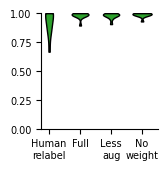

In [ ]:
plt.figure(figsize=(1.5,1.5))
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

vp = plt.violinplot([human_data_dict[4]["frac_correct"], 
                     network_data_dict[3]["paper_all"]["frac_correct"], 
                     network_data_dict[3]["paper_nocustomaug"]["frac_correct"], 
                     network_data_dict[3]["paper_noweight"]["frac_correct"]])

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp[partname].set_edgecolor('none')

# Calculate the area of each violin
violin_areas = [np.trapz(np.abs(body.get_paths()[0].vertices[:, 1]), body.get_paths()[0].vertices[:, 0]) for body in vp['bodies']]
max_area = max(violin_areas)

# Normalize each violin to have the same area
for i, body in enumerate(vp['bodies']):
    verts = body.get_paths()[0].vertices
    scale_factor = 0.5 * (max_area / violin_areas[i])**0.5
    verts[:, 0] *= scale_factor
    # Recenter the violin
    verts[:, 0] -= np.mean(verts[:, 0])
    verts[:, 0] += i + 1  # Reposition based on their original location
    body.set_edgecolor('black')
    body.set_linewidth(1)
    body.set_alpha(1)
    body.set_facecolor('C2')  # Set the color to grey

font = {'fontname': 'DejaVu Sans', 'size': 7}

## Statistics

# Human vs full
p_value = paired_permutation_test(human_data_dict[4]["frac_correct"], network_data_dict[3]["paper_all"]["frac_correct"])
print(f'Human vs full: p={p_value}')

# Full vs lessaug
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["frac_correct"], network_data_dict[3]["paper_nocustomaug"]["frac_correct"])
print(f'Full vs lessaug: p={p_value}')

# Full vs noweight
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["frac_correct"], network_data_dict[3]["paper_noweight"]["frac_correct"])
print(f'Full vs noweight: p={p_value}')


plt.xticks([1, 2, 3, 4], ["Human\nrelabel", "Full", "Less\naug", "No\nweight"], **font)
plt.xlim(0.75,4.5)
# plt.xlabel("Human confidence")
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1], **font)
# plt.xlim()
# plt.ylabel("Autolabel-human\nagreement")

# plt.savefig("/data3/prj_register/figures/figure_4/autolabel_accuracy.pdf", bbox_inches='tight')

Plot human relabeling vs AutoCellLabeler and CellDiscoveryNet

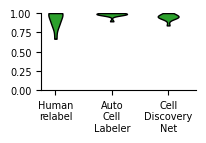

In [ ]:
idx_test = [i for i in range(len(datasets_use_deepreg)) if datasets_use_deepreg[i] in datasets_test]

plt.figure(figsize=(2.0,1.0))
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

vp = plt.violinplot([human_data_dict[4]["frac_correct"], 
                     network_data_dict[3]["paper_all"]["frac_correct"], 
                     [network_data_dict[3]["deepreg"]["frac_correct"][i] for i in idx_test]])

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp[partname].set_edgecolor('none')

# Calculate the area of each violin
violin_areas = [np.trapz(np.abs(body.get_paths()[0].vertices[:, 1]), body.get_paths()[0].vertices[:, 0]) for body in vp['bodies']]
max_area = max(violin_areas)

# Normalize each violin to have the same area
for i, body in enumerate(vp['bodies']):
    verts = body.get_paths()[0].vertices
    scale_factor = 0.5 * (max_area / violin_areas[i])**0.5
    verts[:, 0] *= scale_factor
    # Recenter the violin
    verts[:, 0] -= np.mean(verts[:, 0])
    verts[:, 0] += i + 1  # Reposition based on their original location
    body.set_edgecolor('black')
    body.set_linewidth(1)
    body.set_alpha(1)
    body.set_facecolor('C2')  # Set the color to grey

font = {'fontname': 'DejaVu Sans', 'size': 7}

## Statistics

# Human vs full
p_value = paired_permutation_test(human_data_dict[4]["frac_correct"], network_data_dict[3]["paper_all"]["frac_correct"])
print(f'Human vs full: p={p_value}')

# Full vs deepreg
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["frac_correct"], [network_data_dict[3]["deepreg"]["frac_correct"][i] for i in idx_test])
print(f'Full vs deepreg: p={p_value}')


plt.xticks([1, 2, 3], ["Human\nrelabel", "Auto\nCell\nLabeler", "Cell\nDiscovery\nNet"], **font)
plt.xlim(0.75,3.5)
# plt.xlabel("Human confidence")
plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1], **font)
# plt.xlim()
# plt.ylabel("Autolabel-human\nagreement")

# plt.savefig("/data3/prj_register/figures/figure_6/deepreg_accuracy.pdf", bbox_inches='tight')

Compare accuracy of color-limited versions of AutoCellLabeler

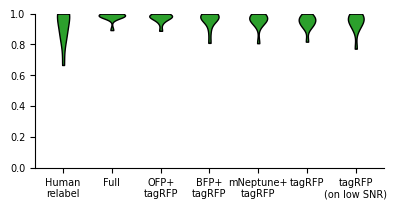

In [ ]:
plt.figure(figsize=(4.5,2))
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
vp = plt.violinplot([human_data_dict[4]["frac_correct"], 
                network_data_dict[3]["paper_all"]["frac_correct"], 
                network_data_dict[3]["paper_OFP"]["frac_correct"], 
                network_data_dict[3]["paper_BFP"]["frac_correct"],
                network_data_dict[3]["paper_mNeptune"]["frac_correct"],
                network_data_dict[3]["paper_all_red"]["frac_correct"],
                network_data_dict[3]["paper_noisy_all_red"]["frac_correct"]]
                )

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp[partname].set_edgecolor('none')

# Calculate the area of each violin
violin_areas = [np.trapz(np.abs(body.get_paths()[0].vertices[:, 1]), body.get_paths()[0].vertices[:, 0]) for body in vp['bodies']]
max_area = max(violin_areas)

# Normalize each violin to have the same area
for i, body in enumerate(vp['bodies']):
    verts = body.get_paths()[0].vertices
    scale_factor = 0.5 * (max_area / violin_areas[i])**0.5
    verts[:, 0] *= scale_factor
    # Recenter the violin
    verts[:, 0] -= np.mean(verts[:, 0])
    verts[:, 0] += i + 1  # Reposition based on their original location
    body.set_edgecolor('black')
    body.set_linewidth(1)
    body.set_alpha(1)
    body.set_facecolor('C2')  # Set the color to grey

font = {'fontname': 'DejaVu Sans', 'size': 7}

## Statistics

# Human vs full
p_value = paired_permutation_test(human_data_dict[4]["frac_correct"], network_data_dict[3]["paper_all"]["frac_correct"])
print(f'Human vs full: p={p_value}')

# Full vs OFP
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["frac_correct"], network_data_dict[3]["paper_OFP"]["frac_correct"])
print(f'Full vs OFP: p={p_value}')

# Full vs BFP
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["frac_correct"], network_data_dict[3]["paper_BFP"]["frac_correct"])
print(f'Full vs BFP: p={p_value}')

# Full vs mNeptune
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["frac_correct"], network_data_dict[3]["paper_mNeptune"]["frac_correct"])
print(f'Full vs mNeptune: p={p_value}')

# Full vs tagRFP
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["frac_correct"], network_data_dict[3]["paper_all_red"]["frac_correct"])
print(f'Full vs tagRFP: p={p_value}')

# Full vs tagRFP (noisy)
p_value = paired_permutation_test(network_data_dict[3]["paper_all"]["frac_correct"], network_data_dict[3]["paper_noisy_all_red"]["frac_correct"])
print(f'Full vs tagRFP (noisy): p={p_value}')

plt.xticks([1, 2, 3, 4, 5, 6, 7], ["Human\nrelabel", "Full", "OFP+\ntagRFP", "BFP+\ntagRFP", "mNeptune+\ntagRFP", "tagRFP", "tagRFP\n(on low SNR)"], **font)
plt.ylim(0,1)
plt.yticks(**font)
# plt.xlim()
# plt.ylabel("accuracy")
# plt.savefig("/data3/prj_register/figures/figure_5/autolabel_accuracy_fluorophore.pdf", bbox_inches='tight')

### Plot network confidence vs human label categorization

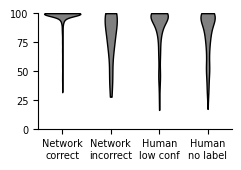

In [ ]:
plt.figure(figsize=(2.5,1.5))
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

vp = plt.violinplot([[100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_correct"]], 
                     [100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_incorrect"]], 
                     [100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_humanlowconf"]], 
                     [100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_nohumanlabel"]]])

for partname in ('cbars', 'cmins', 'cmaxes'):
    vp[partname].set_edgecolor('none')

# Calculate the area of each violin
violin_areas = [np.trapz(np.abs(body.get_paths()[0].vertices[:, 1]), body.get_paths()[0].vertices[:, 0]) for body in vp['bodies']]
max_area = max(violin_areas)

# Normalize each violin to have the same area
for i, body in enumerate(vp['bodies']):
    verts = body.get_paths()[0].vertices
    scale_factor = 0.5 * (max_area / violin_areas[i])**0.5
    verts[:, 0] *= scale_factor
    # Recenter the violin
    verts[:, 0] -= np.mean(verts[:, 0])
    verts[:, 0] += i + 1  # Reposition based on their original location
    body.set_edgecolor('black')
    body.set_linewidth(1)
    body.set_alpha(1)
    body.set_facecolor('grey')  # Set the color to grey

font = {'fontname': 'DejaVu Sans', 'size': 7}

## Statistics

# Correct vs incorrect
stat, p_value = mannwhitneyu([100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_correct"]], [100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_incorrect"]])
print(f'Correct vs incorrect: p={p_value}')

# Correct vs humanlowconf
stat, p_value = mannwhitneyu([100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_correct"]], [100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_humanlowconf"]])
print(f'Correct vs humanlowconf: p={p_value}')

# Correct vs nohumanlabel
stat, p_value = mannwhitneyu([100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_correct"]], [100 * x[3] for x in network_data_dicts[(4,5)][0]["paper_all"]["network_conf_nohumanlabel"]])
print(f'Correct vs nohumanlabel: p={p_value}')


plt.xlim(0.5,4.5)
# plt.xlabel("Human confidence")
plt.ylim(0, 1)
plt.yticks([0, 25, 50, 75, 100], **font)
# plt.xlim()
# plt.ylabel("Autolabel-human\nagreement")
          
plt.xticks([1, 2, 3, 4], ["Network\ncorrect", "Network\nincorrect", "Human\nlow conf", "Human\nno label"], **font)
plt.ylim(0,100)
# plt.xlim()
# plt.ylabel("Network confidence (%)")
# plt.savefig("/data3/prj_register/figures/figure_4/autolabel_confidence.pdf", bbox_inches='tight')

## Per-neuron analysis

### Plot per-neuron network accuracy and confidence

Modify `paper_all` to a different network version to plot this for that network.

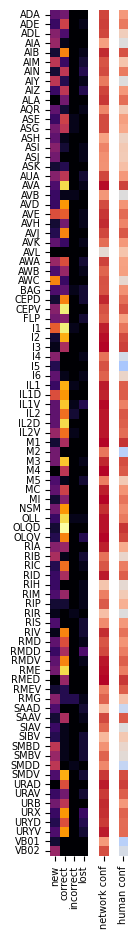

/tmp/ipykernel_3794001/3409960032.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


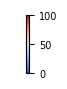

/tmp/ipykernel_3794001/3409960032.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


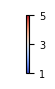

/tmp/ipykernel_3794001/3409960032.py:81: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


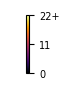

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

font = {'fontname': 'DejaVu Sans', 'size': 7}

indices_use = [0, 1, 3, 4]

indices_use = [0, 1, 3, 4]

values = [
    [network_data_dict[3]["paper_all"]["neuron_class_dict"][neuron_class][i] for i in indices_use] + 
    [np.mean(network_data_dict[0]["paper_all"]["confidence_per_neuron"][neuron_class][i]) for i in [0, 1]]
    for neuron_class in neuron_classes if neuron_class not in excluded_classes
]

# Create a dataframe from the values
df = pd.DataFrame(values, index=neuron_classes, columns=['new', 'correct', 'incorrect', 'lost', 'network conf', 'human conf'])

# Create subplots with appropriate widths
fig, axs = plt.subplots(1, 3, figsize=(1.35, 9.5), gridspec_kw={'width_ratios': [2, 0.5, 0.5]})

# Plot the first heatmap for the first 4 columns
sns.heatmap(df.iloc[:, :4], annot=False, cmap='inferno', vmin=0, vmax=22, cbar=False, square=True, ax=axs[0])
axs[0].set_xticks(np.array(range(len(df.columns[:4]))) + 0.5)
axs[0].set_xticklabels(df.columns[:4], rotation=90, **font)
axs[0].set_yticks(np.array(range(len(df.index))) + 0.5)
axs[0].set_yticklabels(df.index, **font)
# axs[0].set_ylabel('Neuron Class', fontdict=font)

# Plot the second-to-right column with scale 0 to 1
sns.heatmap(df.iloc[:, [4]], annot=False, cmap='coolwarm', vmin=0, vmax=1, cbar=False, square=True, ax=axs[1])
axs[1].set_xticks([0.5])
axs[1].set_xticklabels([df.columns[4]], rotation=90, **font)
axs[1].set_yticks([])

# Plot the rightmost column with scale 1 to 5
sns.heatmap(df.iloc[:, [5]], annot=False, cmap='coolwarm', vmin=1, vmax=5, cbar=False, square=True, ax=axs[2])
axs[2].set_xticks([0.5])
axs[2].set_xticklabels([df.columns[5]], rotation=90, **font)
axs[2].set_yticks([])

plt.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_4/autolabel_accuracy_per_class_combined.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Create the colorbar for the second-to-right column
fig, ax = plt.subplots(figsize=(0.25, 0.9))
norm = plt.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', ticks=[0, 50, 100])
cbar.set_ticklabels([0, 50, 100], **font)
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_4/autolabel_accuracy_per_class_network_conf_colorbar.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Create the colorbar for the rightmost column
fig, ax = plt.subplots(figsize=(0.25, 0.9))
norm = plt.Normalize(vmin=1, vmax=5)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', ticks=[1, 3, 5])
cbar.set_ticklabels([1, 3, 5], **font)
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_4/autolabel_accuracy_per_class_human_conf_colorbar.pdf", bbox_inches='tight', dpi=300)
plt.show()

# Create a separate figure for the colorbar
fig, ax = plt.subplots(figsize=(0.25, 0.9))  # Adjust the figsize as needed
norm = plt.Normalize(vmin=0, vmax=22)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', ticks=[0, 11, 22])
cbar.set_ticklabels([0, 11, "22+"], **font)
# disable axes
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_4/autolabel_accuracy_per_class_colorbar.pdf", bbox_inches='tight', dpi=300)


### Plot network vs human confidence

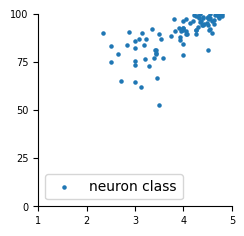

In [ ]:
plt.figure(figsize=(2.5,2.5))

ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.scatter([np.mean(network_data_dict[0]["paper_all"]["confidence_per_neuron"][neuron_class][1]) for neuron_class in neuron_classes], [100 * np.mean(network_data_dict[0]["paper_all"]["confidence_per_neuron"][neuron_class][0]) for neuron_class in neuron_classes], s=5, label="neuron class")

font = {'fontname': 'DejaVu Sans', 'size': 7}
plt.legend()

plt.yticks([0, 25, 50, 75, 100], **font)
plt.ylim(0,100)
plt.xlim(1, 5)
plt.xticks([1, 2, 3, 4, 5], **font)

# plt.savefig("/data3/prj_register/figures/figure_S4/autolabel_vs_human_conf.pdf", bbox_inches='tight')

### Plot CellDiscoveryNet per-neuron accuracy

/home/adam/.julia/conda/3/x86_64/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/adam/.julia/conda/3/x86_64/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


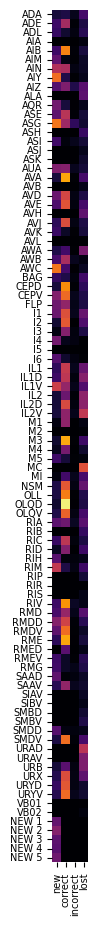

/tmp/ipykernel_3794001/3153989324.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


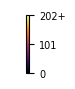

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

font = {'fontname': 'DejaVu Sans', 'size': 7}

indices_use = [0, 1, 3, 4]

values = [
    [network_data_dict[3]["deepreg"]["neuron_class_dict"][neuron_class][i] for i in indices_use] + 
    [np.mean(network_data_dict[0]["deepreg"]["confidence_per_neuron"][neuron_class][i]) for i in [0, 1]]
    for neuron_class in neuron_classes if neuron_class not in excluded_classes
]

unknown_arr = [57, 74, 54, 52, 62]

neuron_class_labels = neuron_classes.copy()

for (i, val) in enumerate(unknown_arr):
    values.append([val, 0, 0, 0, 0, 0])
    neuron_class_labels.append("NEW " + str(i+1))
    
    

# Create a dataframe from the values
df = pd.DataFrame(values, index=neuron_class_labels, columns=['new', 'correct', 'incorrect', 'lost', 'network conf', 'human conf'])

# Create subplots with appropriate widths
fig = plt.figure(figsize=(0.9, 10))
ax = plt.gca()

# Plot the first heatmap for the first 4 columns
sns.heatmap(df.iloc[:, :4], annot=False, cmap='inferno', vmin=0, vmax=202, cbar=False, square=True, ax=ax)
ax.set_xticks(np.array(range(len(df.columns[:4]))) + 0.5)
ax.set_xticklabels(df.columns[:4], rotation=90, **font)
ax.set_yticks(np.array(range(len(df.index))) + 0.5)
ax.set_yticklabels(df.index, **font)
# axs[0].set_ylabel('Neuron Class', fontdict=font)

# # Plot the second-to-right column with scale 0 to 1
# sns.heatmap(df.iloc[:, [4]], annot=False, cmap='coolwarm', vmin=0, vmax=1, cbar=False, square=True, ax=axs[1])
# axs[1].set_xticks([0.5])
# axs[1].set_xticklabels([df.columns[4]], rotation=90, **font)
# axs[1].set_yticks([])

# # Plot the rightmost column with scale 1 to 5
# sns.heatmap(df.iloc[:, [5]], annot=False, cmap='coolwarm', vmin=1, vmax=5, cbar=False, square=True, ax=axs[2])
# axs[2].set_xticks([0.5])
# axs[2].set_xticklabels([df.columns[5]], rotation=90, **font)
# axs[2].set_yticks([])

plt.tight_layout()

# plt.savefig("/data3/prj_register/figures/figure_6/deepreg_accuracy_per_class.pdf", bbox_inches='tight', dpi=300)
plt.show()


# Create a separate figure for the colorbar
fig, ax = plt.subplots(figsize=(0.25, 0.9))  # Adjust the figsize as needed
norm = plt.Normalize(vmin=0, vmax=202)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', ticks=[0, 101, 202])
cbar.set_ticklabels([0, 101, "202+"], **font)
# disable axes
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_6/deepreg_accuracy_per_class_colorbar.pdf", bbox_inches='tight', dpi=300)

### Plot various colorbars

/tmp/ipykernel_8968/1627491338.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


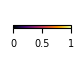

In [ ]:
font = {'fontname': 'DejaVu Sans', 'size': 7}


# Create a separate figure for the colorbar
fig, ax = plt.subplots(figsize=(0.75, 0.25))  # Adjust the figsize as needed
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='inferno', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', ticks=[0, 0.5, 1.0])
cbar.set_ticklabels([0, 0.5, 1], **font)
# disable axes
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_4/confidence_image_colorbar.pdf", bbox_inches='tight', dpi=300)


/tmp/ipykernel_8968/578959429.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


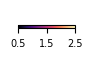

In [ ]:
font = {'fontname': 'DejaVu Sans', 'size': 7}


# Create a separate figure for the colorbar
fig, ax = plt.subplots(figsize=(0.75, 0.25))  # Adjust the figsize as needed
norm = plt.Normalize(vmin=0.5, vmax=2.5)
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', ticks=[0.5, 1.5, 2.5])
cbar.set_ticklabels([0.5, 1.5, 2.5], **font)
# disable axes
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_3/F_Fmean_colorbar.pdf", bbox_inches='tight', dpi=300)


/tmp/ipykernel_8968/4169598625.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


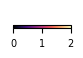

In [ ]:
font = {'fontname': 'DejaVu Sans', 'size': 7}


# Create a separate figure for the colorbar
fig, ax = plt.subplots(figsize=(0.75, 0.25))  # Adjust the figsize as needed
norm = plt.Normalize(vmin=0, vmax=2)
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', ticks=[0, 1, 2])
cbar.set_ticklabels([0, 1, 2], **font)
# disable axes
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_3/F_colorbar.pdf", bbox_inches='tight', dpi=300)


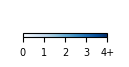

In [ ]:
font = {'fontname': 'DejaVu Sans', 'size': 7}


# Create a separate figure for the colorbar
fig, ax = plt.subplots(figsize=(1.5, 0.75))  # Adjust the figsize as needed
norm = plt.Normalize(vmin=0, vmax=4)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', ticks=[0, 1, 2, 3, 4])
cbar.set_ticklabels([0, 1, 2, 3, "4+"], **font)
# disable axes
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_S4/confusion_colorbar.pdf", bbox_inches='tight')

/tmp/ipykernel_8968/1748551211.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


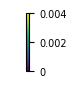

In [ ]:
font = {'fontname': 'DejaVu Sans', 'size': 7}


# Create a separate figure for the colorbar
fig, ax = plt.subplots(figsize=(0.25, 0.75))  # Adjust the figsize as needed
norm = plt.Normalize(vmin=0, vmax=0.004)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', ticks=[0, 0.002, 0.004])
cbar.set_ticklabels([0, 0.002, 0.004], **font)
# disable axes
ax.axis('off')
fig.tight_layout()
# plt.savefig("/data3/prj_register/figures/figure_3/regmap_colorbar.pdf", bbox_inches='tight', dpi=300)


### Plot confusion matrix

Plot only entries where there was at least one incorrect label

6


Text(0.5, 1.0, 'Confusion Matrix')

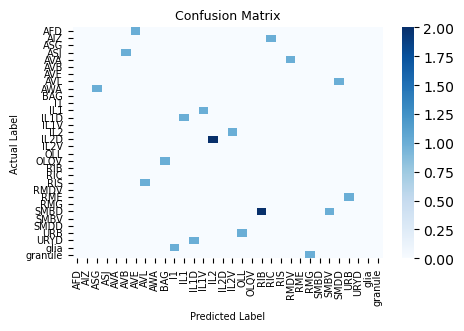

In [ ]:
actual_labels = []
predicted_labels = []

for dataset, roi, network_label, network_confidence in network_data_dict[3]["paper_all"]["network_conf_incorrect"]:
    human_label = dict_roi_to_neuron_everything[dataset][0][roi][0]
    network_label_nolr = (network_label[:-1] if network_label not in neuron_ids_nolr else network_label)
    human_label_nolr = (human_label[:-1] if human_label not in neuron_ids_nolr else human_label)
    actual_labels.append(human_label_nolr)
    predicted_labels.append(network_label_nolr)

# for dataset, roi, network_label, network_confidence in network_data_dict[3]["paper_all"]["network_conf_correct"]:
#     human_label = dict_roi_to_neuron_everything[dataset][0][roi][0]
#     network_label_nolr = (network_label[:-1] if network_label not in neuron_ids_nolr else network_label)
#     human_label_nolr = (human_label[:-1] if human_label not in neuron_ids_nolr else human_label)
#     actual_labels.append(human_label_nolr)
#     predicted_labels.append(network_label_nolr)

print(len([lab for lab in actual_labels if "IL1" in lab or "IL2" in lab or "granule" in lab]))

# Combine the actual and predicted labels to get the unique set of labels present in the data
unique_labels = np.unique(actual_labels + predicted_labels)

# Generate the confusion matrix with the correct labels
cm = confusion_matrix(actual_labels, predicted_labels, labels=unique_labels)

font = {'fontname': 'DejaVu Sans', 'size': 7}

# Plot the confusion matrix
plt.figure(figsize=(5, 3))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
ax.set_xticklabels(ax.get_xticklabels(), fontdict=font)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font)
plt.xlabel('Predicted Label', **font)
plt.ylabel('Actual Label', **font)
plt.title('Confusion Matrix', **{'fontname': 'DejaVu Sans', 'size': 9})
# plt.savefig("/data3/prj_register/figures/figure_S4/confusion_matrix.pdf", bbox_inches='tight', dpi=300)

Plot all entries, capping the colorbar at 4 to avoid the correct labels oversaturating the plot

107
9.694117647058823


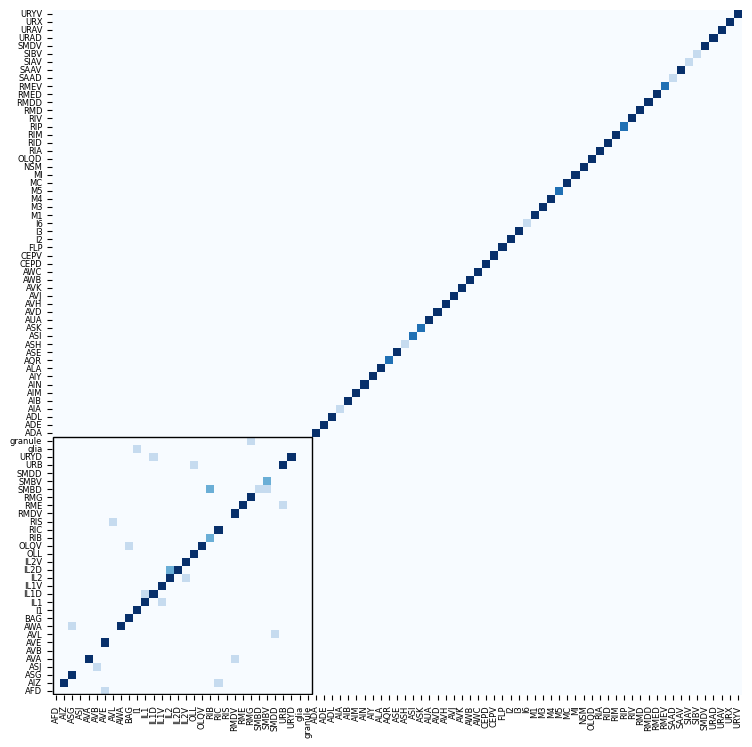

In [ ]:
actual_labels = []
predicted_labels = []

# Add incorrect labels
for dataset, roi, network_label, network_confidence in network_data_dict[3]["paper_all"]["network_conf_incorrect"]:
    human_label = dict_roi_to_neuron_everything[dataset][0][roi][0]
    network_label_nolr = (network_label[:-1] if network_label not in neuron_ids_nolr else network_label)
    human_label_nolr = (human_label[:-1] if human_label not in neuron_ids_nolr else human_label)
    actual_labels.append(human_label_nolr)
    predicted_labels.append(network_label_nolr)

unique_labels_wrong = list(np.unique(actual_labels + predicted_labels))


# Add correct labels
for dataset, roi, network_label, network_confidence in network_data_dict[3]["paper_all"]["network_conf_correct"]:
    human_label = dict_roi_to_neuron_everything[dataset][0][roi][0]
    network_label_nolr = (network_label[:-1] if network_label not in neuron_ids_nolr else network_label)
    human_label_nolr = (human_label[:-1] if human_label not in neuron_ids_nolr else human_label)
    actual_labels.append(human_label_nolr)
    predicted_labels.append(network_label_nolr)

print(len([lab for lab in actual_labels if "IL1" in lab or "IL2" in lab or "granule" in lab]))

# Combine the actual and predicted labels to get the unique set of labels present in the data
unique_labels = list(np.unique(actual_labels + predicted_labels))

unique_labels = unique_labels_wrong + [lab for lab in unique_labels if lab not in unique_labels_wrong]

# Generate the confusion matrix with the correct labels
cm = confusion_matrix(actual_labels, predicted_labels, labels=unique_labels)
print(np.mean([cm[i,i] for i in range(len(unique_labels))]))

# Cap the diagonal values at 4
np.fill_diagonal(cm, np.minimum(np.diagonal(cm), 4))

# Reorganize the confusion matrix to have the current labels in the top left
# sorted_labels = unique_labels
# sorted_index = {label: index for index, label in enumerate(sorted_labels)}
# cm_sorted = cm[np.ix_([sorted_index[label] for label in unique_labels], [sorted_index[label] for label in unique_labels])]

font = {'fontname': 'DejaVu Sans', 'size': 6}

# Plot the confusion matrix
plt.figure(figsize=(8.9, 8.9))  # Adjust the size if necessary
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels, vmin=0, vmax=4, cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), fontdict=font)
ax.set_yticklabels(ax.get_yticklabels(), fontdict=font)
font = {'fontname': 'DejaVu Sans', 'size': 7}

plt.gca().invert_yaxis()

box_size = len(unique_labels_wrong)
rect = patches.Rectangle((0.05, 0.05), box_size, box_size, linewidth=1, edgecolor='black', facecolor='none')
plt.gca().add_patch(rect)

# plt.xlabel('Predicted Label', **font)
# plt.ylabel('Actual Label', **font)
# plt.title('Confusion Matrix', **{'fontname': 'DejaVu Sans', 'size': 9})
# plt.savefig("/data3/prj_register/figures/figure_S4/confusion_matrix_full.pdf", bbox_inches='tight')
plt.show()

## Human relabel analysis

### Compute fraction of ROIs that originally had low confidence labels that got labeled successfully by new human labelers

In [ ]:
n_high_conf_demote = 0
n_high_conf_stay = 0

n_low_conf_promote = 0
n_low_conf_stay = 0

n_nolabel_promote = 0
n_nolabel_stay = 0

for dataset in dict_roi_to_neuron_relabel:
    labels, conf = dict_roi_to_neuron_relabel[dataset]
    for roi in conf:
        if roi in dict_roi_to_neuron_everything[dataset][1]:
            if dict_roi_to_neuron_everything[dataset][1][roi] >= 4: # already had a high confidence label
                if conf[roi] >= 4:
                    n_high_conf_stay += 1
                else:
                    n_high_conf_demote += 1
                continue
            if conf[roi] >= 4 and labels[roi] not in ["glia", "granule"]:
                n_low_conf_promote += 1
            else:
                n_low_conf_stay += 1
        elif conf[roi] >= 4 and labels[roi] not in ["glia", "granule"]:
            n_nolabel_promote += 1
        else:
            n_nolabel_stay += 1

print(n_high_conf_stay / (n_high_conf_demote + n_high_conf_stay))
print(n_low_conf_promote / (n_low_conf_promote + n_low_conf_stay))
print(n_nolabel_promote / (n_nolabel_promote + n_nolabel_stay))
print((n_low_conf_promote + n_nolabel_promote) / (n_low_conf_promote + n_low_conf_stay + n_nolabel_promote + n_nolabel_stay))


0.5454545454545454
0.205761316872428
0.2169811320754717
0.20916905444126074


### Human-human relabeling accuracy

In [ ]:
len(human_data_dict[4]["human2_conf_correct"]) / (len(human_data_dict[4]["human2_conf_incorrect"]) + len(human_data_dict[4]["human2_conf_correct"])) # accuracy of human relabeling at confidence 4-5

0.9230769230769231

### Human relabel vs network accuracy on neurons not originally human-labeled

In [ ]:
human_conf_thresh = 4
n_correct_nohumanlabel = 0
n_incorrect_nohumanlabel = 0

for (dataset, roi, label, conf) in network_data_dict[3]["paper_all"]["network_conf_nohumanlabel"]:
    if dataset in dict_roi_to_neuron_relabel and roi in dict_roi_to_neuron_relabel[dataset][0] and dict_roi_to_neuron_relabel[dataset][1][roi] >= human_conf_thresh:

        gt_neuron_class = dict_roi_to_neuron_relabel[dataset][0][roi]
        if "?" in gt_neuron_class[:-1]:
            continue
        possible_matches = [label]
        if label[-1] in ["L", "R", "?"] and label not in neuron_ids_nolr:
            possible_matches.append(label[:-1] + "L")
            possible_matches.append(label[:-1] + "R")
            possible_matches.append(label[:-1] + "?")
        if gt_neuron_class in possible_matches:
            n_correct_nohumanlabel += 1
        else:
            print(dataset, roi, label, conf, dict_roi_to_neuron_relabel[dataset][0][roi], dict_roi_to_neuron_relabel[dataset][1][roi])
            n_incorrect_nohumanlabel += 1

network_acc_nohumanlabel_relabel = n_correct_nohumanlabel / (n_correct_nohumanlabel + n_incorrect_nohumanlabel)
print(network_acc_nohumanlabel_relabel)

2023-01-06-01 36 RMDVL 0.8415755433940758 glia 4
2023-01-17-07 100 IL2L 0.9986954909854239 M3L 5
2023-08-21-01 55 IL1DL 0.9785343016831913 glia 4
0.88


### Human relabel vs network accuracy on neurons originally labeled at low confidence

In [ ]:
human_conf_thresh = 4
n_correct_humanlowconf = 0
n_incorrect_humanlowconf = 0

for (dataset, roi, label, conf) in network_data_dict[3]["paper_all"]["network_conf_humanlowconf"]:
    if dataset in dict_roi_to_neuron_relabel and roi in dict_roi_to_neuron_relabel[dataset][0] and dict_roi_to_neuron_relabel[dataset][1][roi] >= human_conf_thresh:

        gt_neuron_class = dict_roi_to_neuron_relabel[dataset][0][roi]
        if "?" in gt_neuron_class[:-1]:
            continue
        possible_matches = [label]
        if label[-1] in ["L", "R", "?"] and label not in neuron_ids_nolr:
            possible_matches.append(label[:-1] + "L")
            possible_matches.append(label[:-1] + "R")
            possible_matches.append(label[:-1] + "?")
        if gt_neuron_class in possible_matches:
            n_correct_humanlowconf += 1
        else:
            print(dataset, roi, label, conf, dict_roi_to_neuron_relabel[dataset][0][roi], dict_roi_to_neuron_relabel[dataset][1][roi])
            n_incorrect_humanlowconf += 1

network_acc_humanlowconf_relabel = n_correct_humanlowconf / (n_correct_humanlowconf + n_incorrect_humanlowconf)
network_acc_humanlowconf_relabel

2023-07-07-18 120 RMGL 0.9765183592062819 granule 5
2023-06-23-08 18 RIAL 0.9998321216998902 SAAVL 4
2023-06-23-08 171 I6 0.955275835522917 FLPL 4
2023-06-23-08 6 AWC? 0.8829652794931439 AWAR 5
2023-10-09-01 86 RMDDL 0.9766421097374778 RMDL 4


0.8611111111111112

### Network accuracy vs all high-confidence new human labels

In [ ]:
human_conf_thresh = 4
n_correct_prevlabel = 0
n_incorrect_prevlabel = 0

for k in ["network_conf_correct", "network_conf_incorrect"]:
    for (dataset, roi, label, conf) in network_data_dict[3]["paper_all"][k]:
        if dataset in dict_roi_to_neuron_relabel and roi in dict_roi_to_neuron_relabel[dataset][0] and dict_roi_to_neuron_relabel[dataset][1][roi] >= human_conf_thresh:

            gt_neuron_class = dict_roi_to_neuron_relabel[dataset][0][roi]
            if "?" in gt_neuron_class[:-1]:
                continue
            possible_matches = [label]
            if label[-1] in ["L", "R", "?"] and label not in neuron_ids_nolr:
                possible_matches.append(label[:-1] + "L")
                possible_matches.append(label[:-1] + "R")
                possible_matches.append(label[:-1] + "?")
            if gt_neuron_class in possible_matches:
                n_correct_prevlabel += 1
            else:
                print(dataset, roi, label, conf, dict_roi_to_neuron_relabel[dataset][0][roi], dict_roi_to_neuron_relabel[dataset][1][roi], dict_roi_to_neuron_everything[dataset][0][roi], dict_roi_to_neuron_everything[dataset][1][roi])
                n_incorrect_prevlabel += 1

network_acc_humanlowconf_prevlabel = n_correct_prevlabel / (n_correct_prevlabel + n_incorrect_prevlabel)
network_acc_humanlowconf_prevlabel

2023-08-22-01 185 AVER 0.9996330496330252 AVAR 4 ['AVER'] 5.0
2023-08-22-01 57 AVDR 0.9984905870625298 RIMR 4 ['AVDR'] 4.0
2023-01-06-01 69 RID 0.9716520168271597 URXL 4 ['RID'] 5.0
2023-01-10-07 126 URYVR 0.9999841283308748 BAGR 5 ['URYVR'] 5.0
2023-01-17-07 106 I3 0.9998229112585885 IL2L 4 ['I3'] 5.0
2023-01-17-07 137 AVEL 0.9855923694384131 RIML 4 ['AVEL'] 5.0
2023-08-21-01 47 AIBL 0.9990349716514458 AVEL 4 ['AIBL'] 5
2023-08-21-01 14 IL2VL 0.9684014946310586 OLQVL 4 ['IL2VL'] 4


0.9207920792079208

### Plot network accuracy vs human relabels

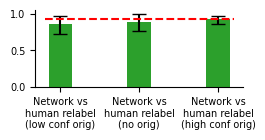

In [ ]:
# Define a function to perform bootstrap resampling and compute the accuracy
def bootstrap_accuracy(correct, incorrect, n_bootstrap=100000):
    accuracies = []
    n_total = correct + incorrect
    for _ in range(n_bootstrap):
        sample = np.random.choice([1, 0], size=n_total, p=[correct/n_total, incorrect/n_total])
        accuracies.append(np.sum(sample) / n_total)
    return accuracies, np.percentile(accuracies, [2.5, 97.5])


# Bootstrap error bars
accuracies_humanlowconf, conf_interval_humanlowconf = bootstrap_accuracy(n_correct_humanlowconf, n_incorrect_humanlowconf)
accuracies_nohumanlabel, conf_interval_nohumanlabel = bootstrap_accuracy(n_correct_nohumanlabel, n_incorrect_nohumanlabel)
accuracies_prevlabel, conf_interval_prevlabel = bootstrap_accuracy(n_correct_prevlabel, n_incorrect_prevlabel)

# Adjusted plotting code
fig, ax = plt.subplots(figsize=(2.75, 1.5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

width = 0.3  # consistent width for all bars

font = {'fontname': 'DejaVu Sans', 'size': 7}

# Calculate accuracies
accuracy_humanlowconf = n_correct_humanlowconf / (n_correct_humanlowconf + n_incorrect_humanlowconf)
accuracy_nohumanlabel = n_correct_nohumanlabel / (n_correct_nohumanlabel + n_incorrect_nohumanlabel)
accuracy_prevlabel = n_correct_prevlabel / (n_correct_prevlabel + n_incorrect_prevlabel)

# Plot bars with error bars
plt.bar([0, 1, 2], [accuracy_humanlowconf, accuracy_nohumanlabel, accuracy_prevlabel], width, yerr=[
    [accuracy_humanlowconf - conf_interval_humanlowconf[0], accuracy_nohumanlabel - conf_interval_nohumanlabel[0], accuracy_prevlabel - conf_interval_prevlabel[0]],
    [conf_interval_humanlowconf[1] - accuracy_humanlowconf, conf_interval_nohumanlabel[1] - accuracy_nohumanlabel, conf_interval_prevlabel[1] - accuracy_prevlabel]
], color=["C2", "C2"], capsize=5)

# Plotting the human agreement fraction
frac_human_corr = len(human_data_dict[4]["human2_conf_correct"]) / (
        len(human_data_dict[4]["human2_conf_correct"]) + len(human_data_dict[4]["human2_conf_incorrect"]))
plt.plot([-0.2, 2.2], [frac_human_corr, frac_human_corr], '--', color="red")

## Statistics

# Bootstrap confidence intervals for human
accuracies_human, conf_interval_human = bootstrap_accuracy(len(human_data_dict[4]["human2_conf_correct"]), len(human_data_dict[4]["human2_conf_incorrect"]))

# compute p-values
p_value = 2 * min(np.mean(np.array(accuracies_human) > accuracies_humanlowconf), np.mean(np.array(accuracies_human) < accuracies_humanlowconf))
print("Human agreement vs. network accuracy at low confidence: p = ", p_value)

p_value = 2 * min(np.mean(np.array(accuracies_human) > accuracies_nohumanlabel), np.mean(np.array(accuracies_human) < accuracies_nohumanlabel))
print("Human agreement vs. network accuracy at no human label: p = ", p_value)

p_value = 2 * min(np.mean(np.array(accuracies_human) > accuracies_prevlabel), np.mean(np.array(accuracies_human) < accuracies_prevlabel))
print("Human agreement vs. network accuracy at previous label: p = ", p_value)



# Labeling and legending
ax.set_ylim(0, 1.05)
ax.set_xticks([0, 1, 2])  # Adjusted to align "Human only" correctly
ax.set_xticklabels(["Network vs\nhuman relabel\n(low conf orig)", "Network vs\nhuman relabel\n(no orig)", "Network vs\nhuman relabel\n(high conf orig)"], **font)
plt.yticks([0,0.5,1], **font)

fig.tight_layout()

# plt.savefig("/data3/prj_register/figures/figure_4/autolabel_accuracy_human_relabel.pdf", bbox_inches='tight')
plt.show()

### Human relabel accuracy by confidence (of the relabeler)

/tmp/ipykernel_8968/4290958280.py:22: RuntimeWarning: invalid value encountered in divide
  print("human accuracy: " + str(np.array(human_delta_correct) / (np.array(human_delta_correct) + np.array(human_delta_incorrect))))


human accuracy: [       nan 0.33333333 0.77777778 0.81081081 0.98113208]


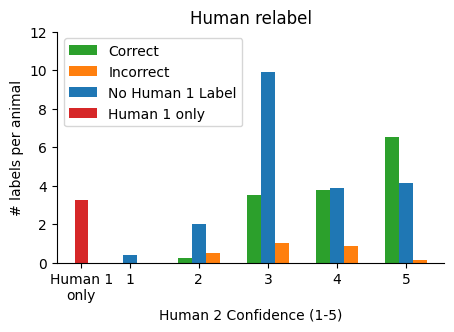

In [ ]:
conf_range_cutoffs = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]

human_delta_correct = []
human_delta_incorrect = []
human_delta_nohumanlabel = []
human_delta_humanlowconf = []


datasets_use = dict_roi_to_neuron_relabel.keys()

n_animals = len(datasets_use)

for i in range(len(conf_range_cutoffs) - 1):
    min_conf = conf_range_cutoffs[i]
    max_conf = conf_range_cutoffs[i+1]
    human_delta_correct.append(len([x for x in human_data_dict[0]["human2_conf_correct"] if x[3] >= min_conf and x[3] < max_conf]) / n_animals)
    human_delta_incorrect.append(len([x for x in human_data_dict[0]["human2_conf_incorrect"] if x[3] >= min_conf and x[3] < max_conf]) / n_animals)
    human_delta_nohumanlabel.append(len([x for x in human_data_dict[0]["human2_conf_nohumanlabel"] if x[3] >= min_conf and x[3] < max_conf]) / n_animals)
    human_delta_humanlowconf.append(len([x for x in human_data_dict[0]["human2_conf_humanlowconf"] if x[3] >= min_conf and x[3] < max_conf]) / n_animals)


print("human accuracy: " + str(np.array(human_delta_correct) / (np.array(human_delta_correct) + np.array(human_delta_incorrect))))
# Compute the sum for the third category
human_delta_no_label_low_conf = [x + y for x, y in zip(human_delta_nohumanlabel, human_delta_humanlowconf)]

# Generate x-axis labels based on the cutoffs
x_labels = [f"{conf_range_cutoffs[i]}-{conf_range_cutoffs[i+1]}" for i in range(len(human_delta_correct))]
x_labels = ["Human\nonly"] + x_labels

# Adjusted plotting code
fig, ax = plt.subplots(figsize=(5,3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x = range(1, len(human_delta_correct) + 1)
width = 0.2  # consistent width for all bars

# Plot each category
suffix = ""
human = "Human"
ax.bar(x, human_delta_correct, width, label='Correct'+suffix, color='C2')
ax.bar([p + 2 * width for p in x], human_delta_incorrect, width, label='Incorrect'+suffix, color='C1')
ax.bar([p + width for p in x], human_delta_no_label_low_conf, width, label='No '+human+' 1 Label', color='C0')
ax.bar([0.5], [np.mean(human_data_dict[0]["count_human1_only"])], width, label="Human 1 only", color='C3')  # Added width and adjusted position

# Labeling and legending
ax.set_xlabel('Human 2 Confidence (1-5)')
ax.set_ylabel('# labels per animal')
ax.set_xticks([0.5] + [p + width for p in x])  # Adjusted to align "Human only" correctly
ax.set_xticklabels(["Human 1\nonly"] + [str(int((conf_range_cutoffs[i] + conf_range_cutoffs[i+1]) // 2)) for i in range(len(human_delta_correct))])
ax.legend()
if human == "paper_SWF415_all_red":
    ax.set_ylim(0,10)
else:
    ax.set_ylim(0, 12)


# plt.show()
plt.title("Human relabel")
# plt.savefig(f"/data3/prj_register/figures/figure_5/human_label_cat.pdf", bbox_inches='tight')